In [1]:
import cython
import numpy as np

import CyRK
print(CyRK.__version__)

0.10.0a3.dev18


In [2]:
from CyRK.cy.cysolver2 import test_cysolve_baseline

In [3]:
x = test_cysolve_baseline()

In [4]:
print(x.size)

360


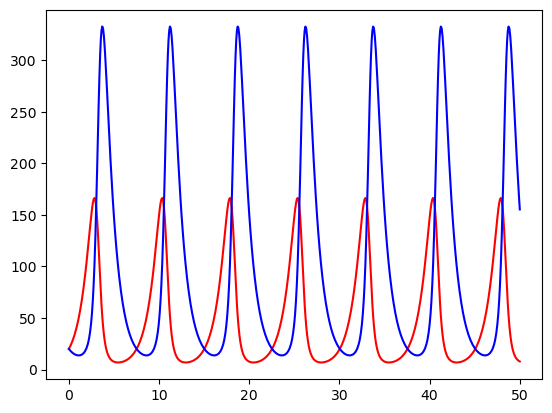

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(x.t, x.y[0], c='r')
ax.plot(x.t, x.y[1], c='b')

plt.show()

In [9]:
%timeit test_cysolve_baseline()

82.1 µs ± 1.09 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [2]:
%load_ext cython

In [7]:
%%cython --annotate --force --compile-args=/openmp --link-args=/openmp -a
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

cdef tuple x = (1.0, "red", 3)

def f(int x, int y, double a, str b, int c):

    print(a)
    print(b)
    print(c)

f(-1, -2, *x)

Content of stdout:
_cython_magic_03971e746be1e4780319438c2d370ea9c01457cc.cpp
LINK : warning LNK4044: unrecognized option '/openmp'; ignored
   Creating library C:\Users\jrenaud\.ipython\cython\Users\jrenaud\.ipython\cython\_cython_magic_03971e746be1e4780319438c2d370ea9c01457cc.cp311-win_amd64.lib and object C:\Users\jrenaud\.ipython\cython\Users\jrenaud\.ipython\cython\_cython_magic_03971e746be1e4780319438c2d370ea9c01457cc.cp311-win_amd64.exp
Generating code
Finished generating code1.0
red
3


In [4]:
%%cython --annotate --force --compile-args=/openmp --link-args=/openmp -a
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

from libcpp.vector cimport vector
from libcpp cimport bool as cpp_bool

cdef extern from * nogil:
    """
#include <vector>
#include <limits>
#include <cmath>
#include <cstring>
#include <cstdio>

// Integration Constants
// Multiply steps computed from asymptotic behaviour of errors by this.
double SAFETY         = 0.9;  // Error coefficient factor (1 == use calculated error; < 1 means be conservative).
double MIN_FACTOR     = 0.2;  // Minimum allowed decrease in a step size.
double MAX_FACTOR     = 10.;  // Maximum allowed increase in a step size.
double INF            = std::numeric_limits<double>::infinity();
double MAX_STEP       = INF;
double EPS            = std::numeric_limits<double>::epsilon();
double EPS_10         = EPS * 10.0;
double EPS_100        = EPS * 100.0;
size_t MAX_SIZET_SIZE = std::numeric_limits<size_t>::max();
size_t MAX_INT_SIZE   = std::numeric_limits<int>::max();

// Solution parameters
double DYNAMIC_GROWTH_RATE = 1.618;
// To learn why the golden ratio is used, read this:
// https://stackoverflow.com/questions/1100311/what-is-the-ideal-growth-rate-for-a-dynamically-allocated-array
double SIZE_MAX_DBL = 0.99 * SIZE_MAX;


void find_max_num_steps(
        size_t num_y,
        size_t num_extra,
        size_t max_num_steps,
        size_t max_ram_MB,
        bool capture_extra,
        bool* user_provided_max_num_steps,
        size_t* max_num_steps_touse) {
    
    // Determine the maximum number of steps permitted during integration run.
    double max_num_steps_ram_dbl;
    max_num_steps_ram_dbl = max_ram_MB * (1000 * 1000);

    // Divide by number of dependnet and extra variables that will be stored. The extra "1" is for the time domain.
    if (capture_extra)
    {
        max_num_steps_ram_dbl /= (sizeof(double) * (1.0 + num_y + num_extra));
    } else {
        max_num_steps_ram_dbl /= (sizeof(double) * (1.0 + num_y));
    }
    size_t max_num_steps_ram = std::floor(max_num_steps_ram_dbl);

    // Parse user-provided max number of steps
    user_provided_max_num_steps[0] = false;
    if (max_num_steps == 0)
    {
        // No user input; use ram-based value
        max_num_steps_touse[0] = max_num_steps_ram;
    } else {
        if (max_num_steps > max_num_steps_ram)
        {
            max_num_steps_touse[0] = max_num_steps_ram;
        } else {
            user_provided_max_num_steps[0] = true;
            max_num_steps_touse[0] = max_num_steps;
        }
    }

    // Make sure that max number of steps does not exceed size_t limit
    if (max_num_steps_touse[0] > (MAX_SIZET_SIZE / 10))
    {
        max_num_steps_touse[0] = (MAX_SIZET_SIZE / 10);
    }
}


typedef void (*DiffeqFuncType)(double*, double, double*, double*);

class CySolverResult {

    protected:
        // ** Attributes **
        // Message storage
        char message[512];

        // Metadata
        size_t num_y;
        size_t num_dy;
        double num_dy_dbl;
        
        // Current storage information
        size_t storage_capacity;

        // ** Methods **
        void expand_storage() {

            double new_storage_size_dbl = std::floor(DYNAMIC_GROWTH_RATE * this->storage_capacity);
            // Check if this new size is okay.
            if ((new_storage_size_dbl / this->num_dy_dbl) > SIZE_MAX_DBL)
            {
                this->error_code = -4;
                strcpy(this->message_ptr, "Attempted to expand solution storage beyond the limits of `size_t`.");
            } else {
                this->storage_capacity = new_storage_size_dbl;
                this->time_domain_ptr->reserve(this->storage_capacity);
                this->solution_ptr->reserve(this->storage_capacity * this->num_dy);
            }
        }

    public:
        // ** Attributes **
        // Status information
        char* message_ptr;
        bool success;
        int error_code;
        size_t size;

        // Storage for arrays
        std::vector<double> time_domain;
        std::vector<double> solution;
        std::vector<double> *time_domain_ptr;
        std::vector<double> *solution_ptr;

        // ** Methods **
        CySolverResult() {}
        CySolverResult(size_t num_y, size_t num_dy, size_t expected_size){
            // Set pointers to our storage
            this->message_ptr     = &this->message[0];
            this->time_domain_ptr = &this->time_domain;
            this->solution_ptr    = &this->solution;

            // Pull out known information
            this->num_y  = num_y;
            this->num_dy = num_dy;
            this->num_dy_dbl = num_dy;

            // Initialize other parameters
            this->size       = 0;
            this->success    = false;
            this->error_code = 0;
            std::strcpy(this->message_ptr, "CySolverResult Initialized.");

            // Initialize storage
            this->storage_capacity = expected_size;

            // Initialize the storage arrays to the expected size
            this->time_domain_ptr->reserve(expected_size);
            this->solution_ptr->reserve(expected_size * this->num_dy);
        }

        void save_data(double new_t, double* new_solution_y, double* new_solution_dy, bool success, int error_code, char* message){
            if (success)
            {
                // Update size and check if there is enough storage in the vectors.
                this->size++;

                if (this->size > this->storage_capacity)
                {
                    this->expand_storage();
                }

                if (this->error_code == 0) // Checks to make sure there was no issue with the storage expansion.
                {
                    this->time_domain_ptr->push_back(new_t);

                    // We use num_dy instead of num_y in the following loop because the user may have requested to
                    // capture additional output from the differential equation.
                    for (size_t dy_i = 0; dy_i < this->num_dy; dy_i++)
                    {   
                        if (dy_i < this->num_y)
                        {
                            // Store dependent results
                            this->solution_ptr->push_back(new_solution_y[dy_i]);
                        } else {
                            // Store extra output
                            this->solution_ptr->push_back(new_solution_dy[dy_i]);
                        }
                    }
                } else {
                    // Nothing was saved so decrement counter;
                    this->size--;
                }

            } else {
                // Something failed. Don't save this data set and update the code and message
                this->success = false;
                this->error_code = error_code;
                std::sprintf(this->message_ptr, "Integration failed at time step %d. Message:\\n %s", this->size + 1, message);
            }
            
        }
};

class CySolverBase {

    protected:
        // ** Attributes **
        // Status variables
        bool reset_called;
        char message[512];

        // Time variables
        double t_start;
        double t_end;
        double t_old;
        double t_delta;
        double t_delta_abs;
        double direction_inf;
        bool direction_flag;

        // Dependent variables
        size_t num_y;
        double num_y_dbl;
        double num_y_sqrt;
        size_t num_dy;
        // The size of the stack allocated tracking arrays is equal to the maximum allowed `num_y` (50).
        double y0[50];
        double y_old[50];
        double y_now[50];
        // For dy, both the dy/dt and any extra outputs are stored. So the maximum size is `num_y` (50) + `num_extra` (50)
        double dy_old[100];
        double dy_now[100];

        // dy_now_ptr and y_now_ptr are declared in public.
        double* y0_ptr = &y0[0];
        double* y_old_ptr = &y_old[0];
        double* dy_old_ptr = &dy_old[0];

        // Integration step information
        size_t len_t;
        size_t max_num_steps;
        bool user_provided_max_num_steps;

        // Information on capturing extra information during integration.
        bool capture_extra;
        size_t num_extra;

        // Differential equation information
        double* args_ptr;
        DiffeqFuncType diffeq_ptr;

        // ** Methods **
        virtual void step_implementation(){
            // Overwritten by subclasses.
        }

    public:

        // ** Attributes **
        int status;
        // Error Codes:
        // -1 : Attribute Error
        // -2 : Value Error
        // -3 : Not Implemented Error
        // -4 : <Reserved>
        // -5 : Runtime error
        int error_code;
        char* message_ptr;

        // State properties
        double t_now;
        double* y_now_ptr = &y_now[0];
        double* dy_now_ptr = &dy_now[0];

        // ** Methods **
        // Constructors
        CySolverBase() {}
        CySolverBase(
                // Input variables
                DiffeqFuncType diffeq_ptr,
                double t_start,
                double t_end,
                double* y0_ptr,
                size_t num_y,
                bool capture_extra = false,
                size_t num_extra = 0,
                double* args_ptr = nullptr,
                size_t max_num_steps = 0,
                size_t max_ram_MB = 2000
                ) {
            // Assume no errors for now.
            this->error_code = 0;
            this->reset_called = false;
            this->status = 0;
            this->message_ptr = &message[0];
            std::strcpy(this->message_ptr, "CySolverBase Initializing.");

            // Check for errors
            if (capture_extra)
            {
                if (num_extra == 0)
                {
                    this->error_code = -1;
                    std::strcpy(this->message_ptr, "CySolverBase Attribute Error: `capture_extra` set to True, but `num_extra` set to 0.");
                } else if (num_extra > 50)
                {
                    this->error_code = -1;
                    std::strcpy(this->message_ptr, "CySolverBase Attribute Error: `num_extra` exceeds the maximum supported value of 50.");
                }
                
            } else if (num_extra > 0)
            {
                this->error_code = -1;
                std::strcpy(this->message_ptr, "CySolverBase Attribute Error: `capture_extra` set to False, but `num_extra` > 0.");
            }

            if (num_y > 50)
            {
                this->error_code = -1;
                std::strcpy(this->message_ptr, "CySolverBase Attribute Error: `num_y` exceeds the maximum supported value of 50.");
            } else if (num_y == 0)
            {
                this->error_code = -1;
                std::strcpy(this->message_ptr, "CySolverBase Attribute Error: Integration completed. `num_y` = 0 so nothing to integrate.");
            }

            // Parse differential equation
            this->diffeq_ptr = diffeq_ptr;
            this->args_ptr = args_ptr;

            // Parse capture extra information
            this->capture_extra = capture_extra;
            this->num_extra = num_extra;

            // Parse y values
            this->num_y      = num_y;
            this->num_y_dbl  = this->num_y;
            this->num_y_sqrt = std::sqrt(this->num_y_dbl);
            this->num_dy     = this->num_y + this->num_extra;
            // Make a copy of y0
            for (size_t y_i = 0; y_i < this->num_y; y_i++)
            {
                this->y0_ptr[y_i] = y0_ptr[y_i];
            }

            // Parse time information
            this->t_start = t_start;
            this->t_end = t_end;
            this->t_delta = t_end - t_start;
            this->t_delta_abs = std::fabs(this->t_delta);
            if (this->t_delta >= 0.0)
            {
                // Forward integration
                this->direction_flag = true;
                this->direction_inf = INF;
            } else {
                // Backward integration
                this->direction_flag = false;
                this->direction_inf = -INF;
            }

            // Parse maximum number of steps
            find_max_num_steps(
                this->num_y,
                num_extra,
                max_num_steps,
                max_ram_MB,
                capture_extra,
                &this->user_provided_max_num_steps,
                &this->max_num_steps);
        }

        void diffeq(){
            // Call differential equation
            this->diffeq_ptr(this->dy_now_ptr, this->t_now, this->y_now_ptr, this->args_ptr);
        }

        virtual void reset(){
            
            double temp_double;

            this->reset_called = false;

            // Reset time
            this->t_now = this->t_start;
            this->t_old = this->t_start;
            this->len_t = 1;

            // Reset ys
            for (size_t y_i = 0; y_i < this->num_y; y_i++)
            {
                temp_double = this->y0_ptr[y_i];
                this->y_now_ptr[y_i] = temp_double;
                this->y_old_ptr[y_i] = temp_double;
            }

            // Call differential equation to set dy0
            this->diffeq();

            // Update dys
            for (size_t dy_i = 0; dy_i < this->num_dy; dy_i++)
            {
                this->dy_old_ptr[dy_i] = this->dy_now_ptr[dy_i];
            }

            this->reset_called = true;
            
        }

        void take_step(){
            
            if (!this->reset_called)
            {
                // Reset must be called first.
                this->reset();
            }
            
            if (this->status == 0)
            {
                if (this->t_now == this->t_end)
                {
                    this->t_old = this->t_end;
                    this->status = 1;
                } else if (this->len_t > this->max_num_steps)
                {
                    if (user_provided_max_num_steps)
                    {
                        // Maximum number of steps reached (as set by user).
                        this->status = -2;
                        this->error_code = -5;
                        strcpy(this->message_ptr, "Maximum number of steps (set by user) exceeded during integration.\\n");
                    } else {
                        // Maximum number of steps reached (as set by RAM limitations).
                        this->status = -3;
                        this->error_code = -5;
                        strcpy(this->message_ptr, "Maximum number of steps (set by system architecture) exceeded during integration.\\n");
                    }
                } else {
                    // ** Make call to solver's step implementation **
                    this->step_implementation();
                    this->len_t++;
                }
            } else {
                this->error_code = -5;
                strcpy(this->message_ptr, "Warning: Step called when status != 0.");
            }
        }
};


class RKSolver: public CySolverBase {

    protected:
        // ** Attributes **

        // Step globals
        double error_safety    = MIN_FACTOR;
        double min_step_factor = MAX_FACTOR;
        double max_step_factor = SAFETY;

        // RK static constants
        int order = 0;
        int error_estimator_order = 0;
        double error_exponent = std::nan("");
        size_t n_stages = 0;
        size_t len_Acols = 0;
        size_t len_C = 0;

        // The maximum size for each container is chosen.
        // When a container cares about the number of y values, as is the case for K, then the max supported num_y of 50
        // is used.
        double C[1]  = {std::nan("")};
        double A[1]  = {std::nan("")};
        double B[1]  = {std::nan("")};
        double E3[1] = {std::nan("")};
        double E5[1] = {std::nan("")};
        double P[1]  = {std::nan("")};
        double D[1]  = {std::nan("")};

        // K is not static const
        double K[1] = {0.0};

        double* C_ptr;
        double* A_ptr;
        double* B_ptr;
        double* E_ptr;
        double* E3_ptr;
        double* E5_ptr;
        double* P_ptr;
        double* D_ptr;

        // K is not static const
        double* K_ptr;

        // Tolerances
        // For the same reason num_y is limited, the total number of tolerances are limited.
        double rtols[50];
        double atols[50];
        double* rtols_ptr = &rtols[0];
        double* atols_ptr = &atols[0];
        bool use_array_rtols;
        bool use_array_atols;

        // Step size parameters
        double step;
        double step_size_old;
        double step_size;
        double max_step_size;
        double user_provided_first_step_size;

        // Error estimate
        double error_norm;

        // ** Methods **
        void estimate_error(){
            
            double error_dot, scale;

            // Initialize rtol and atol
            double rtol = this->rtols_ptr[0];
            double atol = this->atols_ptr[0];

            this->error_norm = 0.0;
            for (size_t y_i = 0; y_i < this->num_y; y_i++) {
                if (this->use_array_rtols)
                {
                    rtol = this->rtols_ptr[y_i];
                }
                
                if (this->use_array_atols)
                {
                    atol = this->atols_ptr[y_i];
                }

                // Find scale of y for error calculations
                scale = atol + std::fmax(std::fabs(this->y_old_ptr[y_i]), std::fabs(this->y_now_ptr[y_i])) * rtol;

                // Set last array of K equal to dydt
                this->K_ptr[this->n_stages * this->num_y + y_i] = this->dy_now_ptr[y_i];
                
                // Initialize
                error_dot = 0.0;

                for (size_t j = 0; j < (this->n_stages + 1); j++) {
                    error_dot += this->K_ptr[j * this->num_y + y_i] * this->E_ptr[j];
                }

                // We need the absolute value but since we are taking the square, it is guaranteed to be positive.
                // TODO: This will need to change if CySolver ever accepts complex numbers
                // error_norm_abs = fabs(error_dot_1)
                error_dot *= (this->step / scale);

                this->error_norm += (error_dot * error_dot);
            }
            this->error_norm = std::sqrt(this->error_norm) / this->num_y_sqrt;
        }


        void step_implementation() override {
            // Initialize step variables
            double step_factor, time_tmp, t_delta_check;
            double temp_double, error_pow;

            // Initialize tolerances to the 0 place. If `use_array_rtols` (or atols) is set then this will change in the loop.
            double rtol = this->rtols_ptr[0];
            double atol = this->atols_ptr[0];

            // Run RK integration step
            // Determine step size based on previous loop
            // Find minimum step size based on the value of t (less floating point numbers between numbers when t is large)
            double min_step_size = 10. * std::fabs(std::nextafter(this->t_old, this->direction_inf) - this->t_old);
            // Look for over/undershoots in previous step size
            if (this->step_size > this->max_step_size) {
                this->step_size = this->max_step_size;
            } else if (this->step_size < min_step_size) {
                this->step_size = min_step_size;
            }

            // Optimization variables
            // Define a very specific A (Row 1; Col 0) now since it is called consistently and does not change.
            double A_at_10 = this->A_ptr[1 * this->len_Acols + 0];

            // Determine new step size
            bool step_accepted = false;
            bool step_rejected = false;
            bool step_error    = false;
            
            printf("\\t LEN C = %d \\n", this->len_C);
            for (size_t s = 1; s < this->len_C; s++) {
            
                printf("C[%d] = %e\\n", s, this->C[s]);
            }

            // !! Step Loop
            while (!step_accepted) {

                // Check if step size is too small
                // This will cause integration to fail: step size smaller than spacing between numbers
                if (this->step_size < min_step_size) {
                    step_error  = true;
                    this->status = -1;
                    break;
                }

                // Move time forward for this particular step size
                if (this->direction_flag) {
                    this->step    = this->step_size;
                    this->t_now   = this->t_old + this->step;
                    t_delta_check = this->t_now - this->t_end;
                } else {
                    this->step    = -this->step_size;
                    this->t_now   = this->t_old + this->step;
                    t_delta_check = this->t_end - this->t_now;
                }

                // Check that we are not at the end of integration with that move
                if (t_delta_check > 0.0) {
                    this->t_now = this->t_end;

                    // If we are, correct the step so that it just hits the end of integration.
                    this->step = this->t_now - this->t_old;
                    if (this->direction_flag){
                        this->step_size = this->step;
                    } else {
                        this->step_size = -this->step;
                    }
                }

                // !! Calculate derivative using RK method

                // t_now must be updated for each loop of s in order to make the diffeq method calls.
                // But we need to return to its original value later on. Store in temp variable.
                time_tmp = this->t_now;

                for (size_t s = 1; s < this->len_C; s++) {
                    // Find the current time based on the old time and the step size.
                    this->t_now = this->t_old + this->C_ptr[s] * this->step;

                    // Dot Product (K, a) * step
                    if (s == 1) {
                        for (size_t y_i = 0; y_i < this->num_y; y_i++) {
                            // Set the first column of K
                            temp_double = this->dy_old_ptr[y_i];
                            // K[0, :] == first part of the array
                            this->K_ptr[y_i] = temp_double;

                            // Calculate y_new for s==1
                            this->y_now_ptr[y_i] = this->y_old_ptr[y_i] + (temp_double * A_at_10 * this->step);
                        }
                    } else {
                        for (size_t j = 0; j < s; j++) {
                            temp_double = this->A_ptr[s * this->len_Acols + j] * this->step;
                            for (size_t y_i = 0; y_i < this->num_y; y_i++) {
                                if (j == 0){
                                    // Initialize
                                    this->y_now_ptr[y_i] = this->y_old_ptr[y_i];
                                }
                                this->y_now_ptr[y_i] += this->K_ptr[j * this->num_y + y_i] * temp_double;
                            }
                        }
                    }
                    // Call diffeq method to update K with the new dydt
                    // This will use the now updated dy_now_ptr based on the values of y_now_ptr and t_now_ptr.
                    this->diffeq();

                    // Update K based on the new dy values.
                    for (size_t y_i = 0; y_i < this->num_y; y_i++) {
                        this->K_ptr[s * this->num_y + y_i] = this->dy_now_ptr[y_i];
                    }
                }

                // Restore t_now to its previous value.
                this->t_now = time_tmp;
                
                // Dot Product (K, B) * step
                for (size_t j = 0; j < this->n_stages; j++) {
                    temp_double = this->B_ptr[j] * this->step;
                    // We do not use rk_n_stages_plus1 here because we are chopping off the last row of K to match
                    //  the shape of B.
                    for (size_t y_i = 0; y_i < this->num_y; y_i++) {
                        if (j == 0) {
                            // Initialize
                            this->y_now_ptr[y_i] = this->y_old_ptr[y_i];
                        }
                        this->y_now_ptr[y_i] += this->K_ptr[j * this->num_y + y_i] * temp_double;
                    }
                }
                
                // Find final dydt for this timestep
                // This will use the now updated dy_now_ptr based on the values of y_now_ptr and t_now_ptr.
                this->diffeq();

                // Check how well this step performed by calculating its error.
                this->estimate_error();

                // Check the size of the error
                if (this->error_norm < 1.0) {
                    // We found our step size because the error is low!
                    // Update this step for the next time loop
                    if (this->error_norm == 0.0) {
                        step_factor = this->max_step_factor;
                    } else {
                        error_pow = std::pow(this->error_norm, -this->error_exponent);
                        step_factor = std::fmin(this->max_step_factor, this->error_safety * error_pow);
                    }

                    if (step_rejected) {
                        // There were problems with this step size on the previous step loop. Make sure factor does
                        //   not exasperate them.
                        step_factor = std::fmin(step_factor, 1.);
                    }

                    // Update step size
                    this->step_size *= step_factor;
                    step_accepted = true;
                } else {
                    // Error is still large. Keep searching for a better step size.
                    error_pow = std::pow(this->error_norm, -this->error_exponent);
                    this->step_size *= std::fmax(this->min_step_factor, this->error_safety * error_pow);
                    step_rejected = true;
                }
            }

            // Update status depending if there were any errors.
            if (step_error) {
                // Issue with step convergence
                this->status = -1;
            } else if (!step_accepted) {
                // Issue with step convergence
                this->status = -7;
            }

            // End of RK step. 
            // Update "old" pointers
            this->t_old = t_now;
            for (size_t y_i = 0; y_i < this->num_y; y_i++) {
                this->y_old_ptr[y_i]  = this->y_now_ptr[y_i];
                this->dy_old_ptr[y_i] = this->dy_now_ptr[y_i];
            }
        }

    public:
        // ** Attributes **
        
        // ** Methods **
        // Constructors
        RKSolver(){}
        RKSolver(
                // Input variables
                DiffeqFuncType diffeq_ptr,
                double t_start,
                double t_end,
                double* y0_ptr,
                size_t num_y,
                bool capture_extra = false,
                size_t num_extra = 0,
                double* args_ptr = nullptr,
                size_t max_num_steps = 0,
                size_t max_ram_MB = 2000,
                double rtol = 1.0e-3,
                double atol = 1.0e-6,
                double* rtols_ptr = nullptr,
                double* atols_ptr = nullptr,
                double max_step_size = MAX_STEP,
                double first_step_size = 0.0
                ) : CySolverBase(diffeq_ptr, t_start, t_end, y0_ptr, num_y, capture_extra, num_extra, args_ptr, max_num_steps, max_ram_MB) {
            
            // Check for errors
            printf("RKSolver  Init called.\\n");
            if (first_step_size != 0.0)
            {
                if (first_step_size < 0.)
                {
                    this->error_code = -1;
                    strcpy(this->message_ptr, "User-provided initial step size must be a positive number.");
                } else if (first_step_size > (this->t_delta_abs * 0.5))
                {
                    this->error_code = -1;
                    strcpy(this->message_ptr, "User-provided initial step size must be smaller than 50% of the time span size.");
                }
            }

            // Setup tolerances
            // User can provide an array of relative tolerances, one for each y value.
            // The length of the pointer array must be the same as y0 (and <= 50).
            this->use_array_rtols = false;
            this->use_array_atols = false;

            double temp_double;
            double min_rtol = INF;
            if (rtols_ptr)
            {
                // rtol for each y
                use_array_rtols = true;
                for (size_t y_i = 0; y_i < this->num_y; y_i++)
                {
                    temp_double = rtols_ptr[y_i];
                    if (temp_double < EPS_100)
                    {
                        temp_double = EPS_100;
                    }
                    min_rtol = std::fmin(min_rtol, temp_double);
                    this->rtols_ptr[y_i] = temp_double;
                }
            } else {
                // only one rtol
                temp_double = rtol;
                if (temp_double < EPS_100)
                {
                    temp_double = EPS_100;
                }
                min_rtol = std::fmin(min_rtol, temp_double);
                this->rtols_ptr[0] = temp_double;
            }

            if (atols_ptr)
            {
                // atol for each y
                use_array_atols = true;
                for (size_t y_i = 0; y_i < this->num_y; y_i++)
                {
                    this->atols_ptr[y_i] = atols_ptr[y_i];
                }
            } else {
                // only one atol
                this->atols_ptr[0] = atol;
            }
        
            // Setup step size
            this->max_step_size = max_step_size;
            this->user_provided_first_step_size = first_step_size;
            printf("RKSolver  Init Done.\\n");
        }
    
    void reset() override {
        // Call base class reset.
        printf("RKSolver reset called.\\n");
        CySolverBase::reset();
        
        printf("RKSolver reset pointers.\\n");
        // Setup RK pointers
        this->C_ptr  = &this->C[0];
        this->A_ptr  = &this->A[0];
        this->B_ptr  = &this->B[0];
        // E and E3 point to the same memory. E3 is only used for DOP853 method other RK methods use E.
        this->E3_ptr = &this->E3[0];
        this->E_ptr  = &this->E3[0];
        this->E5_ptr = &this->E5[0];
        this->P_ptr  = &this->P[0];
        this->D_ptr  = &this->D[0];
        this->K_ptr  = &this->K[0];

        // Update initial step size
        if (this->user_provided_first_step_size == 0)
        {
            // User did not provide a step size. Try to find a good guess.
            this->calc_first_step_size();
        } else {
            this->step_size = this->user_provided_first_step_size;
            this->step_size_old = this->step_size;
        }

        // It is important to initialize the K variable with zeros
        for (size_t i = 0; i < (this->n_stages + 1); i++)
        {
            for (size_t y_i = 0; y_i < this->num_y; y_i++)
            {
                this->K_ptr[i * this->num_y + y_i] = 0.0;
            }
        }
        printf("RKSolver reset Done.\\n");
    }

    void calc_first_step_size() {
        /*
            Select an initial step size based on the differential equation.
            .. [1] E. Hairer, S. P. Norsett G. Wanner, "Solving Ordinary Differential 
                Equations I: Nonstiff Problems", Sec. II.4.
        */

        double d0, d1, d2, d0_abs, d1_abs, d2_abs, scale;
        double h0, h0_direction, h1;
        double y_old_tmp;

        // Initialize tolerances to the 0 place. If `use_array_rtols` (or atols) is set then this will change in the loop.
        double rtol = this->rtols_ptr[0];
        double atol = this->atols_ptr[0];

        if (this->num_y == 0)
        {
            this->step_size = INF;
        } else {
            // Find the norm for d0 and d1
            d0 = 0.0;
            d1 = 0.0;
            for (size_t y_i = 0; y_i < this->num_y; y_i++)
            {
                y_old_tmp = this->y_old_ptr[y_i];

                if (this->use_array_rtols)
                {
                    rtol = this->rtols_ptr[y_i];
                }
                if (this->use_array_atols)
                {
                    atol = this->atols_ptr[y_i];
                }
                
                scale = atol + std::fabs(y_old_tmp) * rtol;
                d0_abs = std::fabs(y_old_tmp / scale);
                d1_abs = std::fabs(dy_old_ptr[y_i] / scale);
                d0 += (d0_abs * d0_abs);
                d1 += (d1_abs * d1_abs);
            }

            d0 = std::sqrt(d0) / this->num_y_sqrt;
            d1 = std::sqrt(d1) / this->num_y_sqrt;

            if ((d0 < 1.0e-5) || (d1 < 1.0e-5))
            {
                h0 = 1.0e-6;
            } else {
                h0 = 0.01 * d0 / d1;
            }

            if (this->direction_flag)
            {
                h0_direction = h0;
            } else {
                h0_direction = -h0;
            }

            this->t_now = this->t_old + h0_direction;
            for (size_t y_i = 0; y_i < this->num_y; y_i++)
            {
                this->y_now_ptr[y_i] = this->y_old_ptr[y_i] + h0_direction * this->dy_old_ptr[y_i];
            }

            // Update dy
            this->diffeq();

            // Find the norm for d2
            d2 = 0.0;
            for (size_t y_i = 0; y_i < this->num_y; y_i++)
            {
                if (this->use_array_rtols)
                {
                    rtol = this->rtols_ptr[y_i];
                }
                if (this->use_array_atols)
                {
                    atol = this->atols_ptr[y_i];
                }

                scale = atol + std::fabs(this->y_old_ptr[y_i]) * rtol;
                d2_abs = std::fabs((this->dy_now_ptr[y_i] - this->dy_old_ptr[y_i]) / scale);
                d2 += (d2_abs * d2_abs);
            }

            d2 = std::sqrt(d2) / (h0 * this->num_y_sqrt);

            if ((d1 <= 1.0e-15) && (d2 <= 1.0e-15))
            {
                h1 = std::fmax(1.0e-6, h0 * 1.0e-3);
            } else {
                h1 = std::pow((0.01 / std::fmax(d1, d2)), this->error_exponent);
            }
            this->step_size = std::fmax(10. * std::fabs(std::nextafter(this->t_old, this->direction_inf) - this->t_old), std::fmin(100.0 * h0, h1));
            this->step_size_old = this->step_size;
        }
    }
};


class RK23: public RKSolver {

    protected:
        int order = 3;
        size_t n_stages = 3;
        size_t len_Acols = 3;
        size_t len_C = 3;
        int error_estimator_order = 2;
        double error_exponent = 1.0 / (2.0 + 1.0);  // Defined as 1 / (error_order + 1)

        double A[9] = {
            // A - Row 0
            0.0,
            0.0,
            0.0,
            // A - Row 1
            1.0 / 2.0,
            0.0,
            0.0,
            // A - Row 2
            0.0,
            3.0 / 4.0,
            0.0
        };
        double B[3] = {
            2.0 / 9.0,
            1.0 / 3.0,
            4.0 / 9.0
        };
        double C[3] = {
            0.0,
            1.0 / 2.0,
            3.0 / 4.0
        };
        double E3[4] = {
            5.0 / 72.0,
            -1.0 / 12.0,
            -1.0 / 9.0,
            1.0 / 8.0
        };
        // K is not a but we do want to initialize it with zeros
        double K[4 * 50];

    public:
        // Copy over base class static constructors
        using RKSolver::RKSolver;

};

class RK45: public RKSolver {

    protected:
        int order = 5;
        size_t n_stages = 6;
        size_t len_Acols = 5;
        size_t len_C = 6;
        int error_estimator_order = 4;
        double error_exponent = 1.0 / (4.0 + 1.0);  // Defined as 1 / (error_order + 1)

        double A[30] = {
            // A - Row 0
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            // A - Row 1
            1.0 / 5.0,
            0.0,
            0.0,
            0.0,
            0.0,
            // A - Row 2
            3.0 / 40.0,
            9.0 / 40.0,
            0.0,
            0.0,
            0.0,
            // A - Row 3
            44.0 / 45.0,
            -56.0 / 15.0,
            32.0 / 9.0,
            0.0,
            0.0,
            // A - Row 4
            19372.0 / 6561.0,
            -25360.0 / 2187.0,
            64448.0 / 6561.0,
            -212.0 / 729.0,
            0.0,
            // A - Row 5
            9017.0 / 3168.0,
            -355.0 / 33.0,
            46732.0 / 5247.0,
            49.0 / 176.0,
            -5103.0 / 18656.0
        };
        double B[6] = {
            35.0 / 384.0,
            0.0,
            500.0 / 1113.0,
            125.0 / 192.0,
            -2187.0 / 6784.0,
            11.0 / 84.0
        };
        double C[6] = {
            0.0,
            1.0 / 5.0,
            3.0 / 10.0,
            4.0 / 5.0,
            8.0 / 9.0,
            1.0
        };
        double E3[7] = {
            -71.0 / 57600.0,
            0.0,
            71.0 / 16695.0,
            -71.0 / 1920.0,
            17253.0 / 339200.0,
            -22.0 / 525.0,
            1.0 / 40.0
        };
        // K is not a static const
        double K[7 * 50];

    public:
        // Copy over base class static constructors
        using RKSolver::RKSolver;
};
"""
    ctypedef void (*DiffeqFuncType)(double*, double, double*, double*) noexcept nogil
    
    cdef cppclass CySolverResult:
        CySolverResult()
        CySolverResult(size_t num_y, size_t num_dy, size_t expected_size)
        char* message_ptr
        cpp_bool success
        int error_code
        size_t size
        vector[double]* time_domain_ptr
        vector[double]* solution_ptr
        void save_data(double new_t, double* new_solution_y, double* new_solution_dy, cpp_bool success, int error_code, char* message)
        
    
    cdef cppclass CySolverBase:
        CySolverBase()
        CySolverBase(
            DiffeqFuncType diffeq_ptr,
            double t_start,
            double t_end,
            double* y0_ptr,
            size_t num_y,
            cpp_bool capture_extra,
            size_t num_extra,
            double* args_ptr,
            size_t max_num_steps,
            size_t max_ram_MB
        )
        int status
        int error_code
        char* message_ptr
        double t_now
        double* y_now_ptr
        double* dy_now_ptr
        void reset() noexcept nogil
        void take_step() noexcept nogil
    
    cdef cppclass RKSolver(CySolverBase):
        RKSolver()
        RKSolver(
            DiffeqFuncType diffeq_ptr,
            double t_start,
            double t_end,
            double* y0_ptr,
            size_t num_y,
            cpp_bool capture_extra,
            size_t num_extra,
            double* args_ptr,
            size_t max_num_steps,
            size_t max_ram_MB,
            double rtol,
            double atol,
            double* rtols_ptr,
            double* atols_ptr,
            double max_step_size,
            double first_step_size
        )
    
    cdef cppclass RK23(RKSolver):
        RK23()
        RK23(
            DiffeqFuncType diffeq_ptr,
            double t_start,
            double t_end,
            double* y0_ptr,
            size_t num_y,
            cpp_bool capture_extra,
            size_t num_extra,
            double* args_ptr,
            size_t max_num_steps,
            size_t max_ram_MB,
            double rtol,
            double atol,
            double* rtols_ptr,
            double* atols_ptr,
            double max_step_size,
            double first_step_size
        )
    
    cdef cppclass RK45(RKSolver):
        RK45()
        RK45(
            DiffeqFuncType diffeq_ptr,
            double t_start,
            double t_end,
            double* y0_ptr,
            size_t num_y,
            cpp_bool capture_extra,
            size_t num_extra,
            double* args_ptr,
            size_t max_num_steps,
            size_t max_ram_MB,
            double rtol,
            double atol,
            double* rtols_ptr,
            double* atols_ptr,
            double max_step_size,
            double first_step_size
        )


cdef void test_diffeq_cpp(double* dy_ptr, double time, double* y_ptr, double* args_ptr) noexcept nogil:
    # Unpack y
    cdef double y0, y1
    y0 = y_ptr[0]
    y1 = y_ptr[1]

    dy_ptr[0] = (1. - 0.01 * y1) * y0
    dy_ptr[1] = (0.02 * y0 - 1.) * y1

from libc.string cimport strcpy

from libc.math cimport INFINITY as INF

import numpy as np
cimport numpy as np
from libc.stdio cimport printf


def test_full_cpp():
    
    cdef DiffeqFuncType diffeq_func_test_ptr = test_diffeq_cpp
    
    cdef double[2] time_span
    cdef double* time_span_ptr = &time_span[0]
    time_span[0] = 0.
    time_span[1] = 50.
    
    cdef double t_start = time_span[0]
    cdef double t_end = time_span[1]
    
    cdef double[2] y0
    cdef double* y0_ptr = &y0[0]
    y0[0] = 20.
    y0[1] = 20.
    cdef size_t num_y = 2
    
    cdef double rtol = 1.0e-7
    cdef double atol = 1.0e-8
    
    cdef size_t expected_size = 300
    cdef CySolverResult* result = new CySolverResult(num_y, num_y, expected_size);
    
    cdef RK45 solver = RK45(
        diffeq_func_test_ptr,
        t_start,
        t_end,
        y0_ptr,
        num_y,
        False,
        0,
        NULL,
        0,
        2000,
        rtol,
        atol,
        NULL,
        NULL,
        INF,
        0.0
    )
    cdef cpp_bool step_success = False
    
    
    # Save initial conditions
    printf("CP1\n");
    solver.reset()
    printf("CP2\n");
    result.save_data(solver.t_now, solver.y_now_ptr, solver.dy_now_ptr, True, solver.error_code, solver.message_ptr)
    printf("CP3\n");
    
    while (solver.status == 0) and (solver.error_code == 0): # and (result.cyres_ptr.error_code == 0):
        # Perform Step
        printf("CP4\n");
        solver.take_step()
        printf("CP5\n");
        if solver.status < 0:
            break
        
        step_success = (solver.status == 0) or (solver.status == 1)
        if not step_success:
            break
        
        # Save Result
        result.save_data(solver.t_now, solver.y_now_ptr, solver.dy_now_ptr, step_success, solver.error_code, solver.message_ptr)
            
        if solver.status == 1:
            break
        
        printf("\t t = %e\n", solver.t_now)
    
    cdef bint success = False
    if solver.status == 1:
        success = True
    
    cdef size_t final_size = result.size
    cdef size_t sol_size = final_size * 2
    
    cdef np.ndarray[np.float64_t, ndim=2] all_out = np.empty((3, final_size), dtype=np.float64, order='C')

    cdef double[:, ::1] all_out_view = all_out
    
    
    cdef size_t i, j
    for i in range(final_size):
        all_out_view[0, i] = result.time_domain_ptr[0][i]
        for j in range(2):
            all_out_view[j+1, i] = result.solution_ptr[0][2 * i + j]
    del result
    
    return success, solver.status, str(solver.message_ptr, "UTF-8"), all_out


Content of stdout:
_cython_magic_1d709382d608374008af5b94be3ec2eeba837544.cpp
C:\Users\joepr\.ipython\cython\_cython_magic_1d709382d608374008af5b94be3ec2eeba837544.cpp(1233): warning C4244: '=': conversion from 'size_t' to 'double', possible loss of data
C:\Users\joepr\.ipython\cython\_cython_magic_1d709382d608374008af5b94be3ec2eeba837544.cpp(1242): warning C4244: 'initializing': conversion from 'double' to 'size_t', possible loss of data
C:\Users\joepr\.ipython\cython\_cython_magic_1d709382d608374008af5b94be3ec2eeba837544.cpp(1295): warning C4244: '=': conversion from 'double' to 'size_t', possible loss of data
C:\Users\joepr\.ipython\cython\_cython_magic_1d709382d608374008af5b94be3ec2eeba837544.cpp(1326): warning C4244: '=': conversion from 'size_t' to 'double', possible loss of data
C:\Users\joepr\.ipython\cython\_cython_magic_1d709382d608374008af5b94be3ec2eeba837544.cpp(1379): warning C4477: 'sprintf' : format string '%d' requires an argument of type 'int', but variadic argument 1 

In [ ]:
success, status, message, yz = test_full_cpp()
print(success, status, message)
t = yz[0, :]
y = yz[1:, :]
diff_plot(t, y)

In [149]:
t

array([0.01414214, 0.0169395 , 0.05285248, 0.1171158 ])

In [134]:
%%cython --annotate --force --compile-args=/openmp --link-args=/openmp -a
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

# from libcpp.vector cimport vector

from libc.math cimport fabs, fmin, fmax, floor, sqrt, nextafter
from libc.math cimport INFINITY as INF
from libc.stdint cimport SIZE_MAX, INT32_MAX
from libc.string cimport strcpy

from CyRK.rk.rk cimport find_rk_properties

from libc.float cimport DBL_EPSILON as EPS

# # Integration Constants
# Multiply steps computed from asymptotic behaviour of errors by this.
cdef double SAFETY           = 0.9
cdef double MIN_FACTOR       = 0.2  # Minimum allowed decrease in a step size.
cdef double MAX_FACTOR       = 10.  # Maximum allowed increase in a step size.
cdef double MAX_STEP         = INF
cdef double EPS_10           = EPS * 10.
cdef double EPS_100          = EPS * 100.
cdef size_t MAX_SIZET_SIZE = <size_t>(SIZE_MAX)
cdef size_t MAX_INT_SIZE   = <size_t>(INT32_MAX)

# # Memory management constants
# Assume that a cpu has a L1 of 300KB. Say that this progam will have access to 75% of that total.
cdef double CPU_CACHE_SIZE = 0.75 * 300_000.
# Number of entities we can fit into that size is based on the size of double (or double complex)
cdef double MAX_ARRAY_PREALLOCATE_SIZE_DBL      = 600_000.
cdef double MAX_ARRAY_PREALLOCATE_SIZE_DBLCMPLX = 300_000.
cdef double MIN_ARRAY_PREALLOCATE_SIZE = 10.
cdef double ARRAY_PREALLOC_TABS_SCALE  = 1000.  # A delta_t_abs higher than this value will start to grow array size.
cdef double ARRAY_PREALLOC_RTOL_SCALE  = 1.0e-5  # A rtol lower than this value will start to grow array size.
# RAM_BUFFER_SIZE should be set to the max size we expect cyrk_ode or CySolver to be before integration starts.
#  i.e., before the solution arrays start to grow.
# As of CyRK v0.8.3 CySolver is around 1200 bytes. Buffer this up to 2000.
# Note this does not need to be precise. It just should be close.
cdef size_t RAM_BUFFER_SIZE = 2000


cdef extern from "<vector>" namespace "std" nogil:
    cdef cppclass vector[T,ALLOCATOR=*]:
        ctypedef T value_type
        ctypedef ALLOCATOR allocator_type

        # these should really be allocator_type.size_type and
        # allocator_type.difference_type to be true to the C++ definition
        # but cython doesn't support deferred access on template arguments
        ctypedef size_t size_type
        ctypedef ptrdiff_t difference_type

        cppclass const_iterator
        cppclass iterator:
            iterator()
            iterator(iterator&)
            T& operator*()
            iterator operator++()
            iterator operator--()
            iterator operator++(int)
            iterator operator--(int)
            iterator operator+(size_type)
            iterator operator-(size_type)
            difference_type operator-(iterator)
            difference_type operator-(const_iterator)
            bint operator==(iterator)
            bint operator==(const_iterator)
            bint operator!=(iterator)
            bint operator!=(const_iterator)
            bint operator<(iterator)
            bint operator<(const_iterator)
            bint operator>(iterator)
            bint operator>(const_iterator)
            bint operator<=(iterator)
            bint operator<=(const_iterator)
            bint operator>=(iterator)
            bint operator>=(const_iterator)
        cppclass const_iterator:
            const_iterator()
            const_iterator(iterator&)
            const_iterator(const_iterator&)
            operator=(iterator&)
            const T& operator*()
            const_iterator operator++()
            const_iterator operator--()
            const_iterator operator++(int)
            const_iterator operator--(int)
            const_iterator operator+(size_type)
            const_iterator operator-(size_type)
            difference_type operator-(iterator)
            difference_type operator-(const_iterator)
            bint operator==(iterator)
            bint operator==(const_iterator)
            bint operator!=(iterator)
            bint operator!=(const_iterator)
            bint operator<(iterator)
            bint operator<(const_iterator)
            bint operator>(iterator)
            bint operator>(const_iterator)
            bint operator<=(iterator)
            bint operator<=(const_iterator)
            bint operator>=(iterator)
            bint operator>=(const_iterator)

        cppclass const_reverse_iterator
        cppclass reverse_iterator:
            reverse_iterator()
            reverse_iterator(reverse_iterator&)
            T& operator*()
            reverse_iterator operator++()
            reverse_iterator operator--()
            reverse_iterator operator++(int)
            reverse_iterator operator--(int)
            reverse_iterator operator+(size_type)
            reverse_iterator operator-(size_type)
            difference_type operator-(iterator)
            difference_type operator-(const_iterator)
            bint operator==(reverse_iterator)
            bint operator==(const_reverse_iterator)
            bint operator!=(reverse_iterator)
            bint operator!=(const_reverse_iterator)
            bint operator<(reverse_iterator)
            bint operator<(const_reverse_iterator)
            bint operator>(reverse_iterator)
            bint operator>(const_reverse_iterator)
            bint operator<=(reverse_iterator)
            bint operator<=(const_reverse_iterator)
            bint operator>=(reverse_iterator)
            bint operator>=(const_reverse_iterator)
        cppclass const_reverse_iterator:
            const_reverse_iterator()
            const_reverse_iterator(reverse_iterator&)
            operator=(reverse_iterator&)
            const T& operator*()
            const_reverse_iterator operator++()
            const_reverse_iterator operator--()
            const_reverse_iterator operator++(int)
            const_reverse_iterator operator--(int)
            const_reverse_iterator operator+(size_type)
            const_reverse_iterator operator-(size_type)
            difference_type operator-(iterator)
            difference_type operator-(const_iterator)
            bint operator==(reverse_iterator)
            bint operator==(const_reverse_iterator)
            bint operator!=(reverse_iterator)
            bint operator!=(const_reverse_iterator)
            bint operator<(reverse_iterator)
            bint operator<(const_reverse_iterator)
            bint operator>(reverse_iterator)
            bint operator>(const_reverse_iterator)
            bint operator<=(reverse_iterator)
            bint operator<=(const_reverse_iterator)
            bint operator>=(reverse_iterator)
            bint operator>=(const_reverse_iterator)

        vector()
        vector(vector&)
        vector(size_type)
        vector(size_type, T&)
        #vector[InputIt](InputIt, InputIt)
        T& operator[](size_type)
        #vector& operator=(vector&)
        bint operator==(vector&, vector&)
        bint operator!=(vector&, vector&)
        bint operator<(vector&, vector&)
        bint operator>(vector&, vector&)
        bint operator<=(vector&, vector&)
        bint operator>=(vector&, vector&)
        void assign(size_type, const T&)
        void assign[InputIt](InputIt, InputIt)
        T& at(size_type)
        T& back()
        iterator begin()
        const_iterator const_begin "begin"()
        const_iterator cbegin()
        size_type capacity()
        void clear()
        bint empty()
        iterator end()
        const_iterator const_end "end"()
        const_iterator cend()
        iterator erase(iterator)
        iterator erase(iterator, iterator)
        T& front()
        iterator insert(iterator, const T&)
        iterator insert(iterator, size_type, const T&)
        iterator insert[InputIt](iterator, InputIt, InputIt)
        size_type max_size()
        void pop_back()
        void push_back(T&)
        reverse_iterator rbegin()
        const_reverse_iterator const_rbegin "rbegin"()
        const_reverse_iterator crbegin()
        reverse_iterator rend()
        const_reverse_iterator const_rend "rend"()
        const_reverse_iterator crend()
        void reserve(size_type)
        void resize(size_type)
        void resize(size_type, T&)
        size_type size()
        void swap(vector&)

        # C++11 methods
        T* data()
        const T* const_data "data"()
        void shrink_to_fit()
        iterator emplace(const_iterator, ...)
        T& emplace_back(...)

ctypedef void(*DiffeqFuncType)(double*, double, double*, double*) noexcept nogil

cdef extern from * nogil:
    """
#include <stddef.h>   // `size_t`
#include <stdbool.h>  // `bool`
#include <math.h>     // `fmin`, `fmax`, `fabs`
typedef void (*DiffeqFuncType)(double*, double, double*, double*);

int cf_rk_step(
        // Pointer to differential equation
        DiffeqFuncType diffeq_ptr,

        // t-related variables
        double t_end,
        bool direction_flag,
        double direction_inf,

        // y-related variables
        size_t y_size,
        double y_size_dbl,
        double y_size_sqrt,

        // diffeq related variables
        double* args_ptr,

        // Pointers to attributes that can change during rk_step call.
        double* t_now_ptr,
        double* y_ptr,
        double* dy_ptr,
        double* t_old_ptr,
        double* y_old_ptr,
        double* dy_old_ptr,
        double* step_size_ptr,
        int* status_ptr,

        // Integration tolerance variables and pointers
        bool use_array_rtols,
        bool use_array_atols,
        double* atols_ptr,
        double* rtols_ptr,
        double max_step,

        // RK specific variables and pointers
        int rk_method,
        size_t rk_n_stages,
        size_t rk_n_stages_plus1,
        size_t len_Acols,
        size_t len_C,
        double* A_ptr,
        double* B_ptr,
        double* C_ptr,
        double* K_ptr,
        double* E_ptr,
        double* E3_ptr,
        double* E5_ptr,
        double error_expo,
        double min_step_factor,
        double max_step_factor,
        double error_safety
        ){
    /**
     * Performs a Runge-Kutta step calculation including local error determination. 
    */

    // Initialize step variables
    double min_step, step, step_factor, time_tmp, t_delta_check;
    double scale, temp_double;
    double error_norm, error_dot_1, error_pow;
    bool step_accepted, step_rejected, step_error;

    // Store values from pointers so that they do not have to be dereferenced multiple times
    double t_now = *t_now_ptr;
    double t_old = *t_old_ptr;
    double step_size = *step_size_ptr;

    // Initialize tolerances to the 0 place. If `use_array_rtols` (or atols) is set then this will change in the loop.
    double rtol = rtols_ptr[0];
    double atol = atols_ptr[0];

    // Run RK integration step
    // Determine step size based on previous loop
    // Find minimum step size based on the value of t (less floating point numbers between numbers when t is large)
    min_step = 10. * fabs(nextafter(t_old, direction_inf) - t_old);
    // Look for over/undershoots in previous step size
    if (step_size > max_step) {
        step_size = max_step;
    } else if (step_size < min_step) {
        step_size = min_step;
    }

    // Determine new step size
    step_accepted = false;
    step_rejected = false;
    step_error    = false;

    // Optimization variables
    // Define a very specific A (Row 1; Col 0) now since it is called consistently and does not change.
    double A_at_10 = A_ptr[1 * len_Acols + 0];

    // !! Step Loop
    while (!step_accepted) {

        // Check if step size is too small
        // This will cause integration to fail: step size smaller than spacing between numbers
        if (step_size < min_step) {
            step_error  = true;
            *status_ptr = -1;
            break;
        }

        // Move time forward for this particular step size
        if (direction_flag) {
            step          = step_size;
            t_now         = t_old + step;
            t_delta_check = t_now - t_end;
        } else {
            step          = -step_size;
            t_now         = t_old + step;
            t_delta_check = t_end - t_now;
        }

        // Check that we are not at the end of integration with that move
        if (t_delta_check > 0.0) {
            t_now = t_end;

            // If we are, correct the step so that it just hits the end of integration.
            step = t_now - t_old;
            if (direction_flag){
                step_size = step;
            } else {
                step_size = -step;
            }
        }

        // !! Calculate derivative using RK method

        // t_now must be updated for each loop of s in order to make the diffeq method calls.
        // But we need to return to its original value later on. Store in temp variable.
        time_tmp = t_now;

        for (size_t s = 1; s < len_C; s++) {
            // Find the current time based on the old time and the step size.
            t_now = t_old + C_ptr[s] * step;
            // Update the value stored at the t_now pointer so it can be used in the diffeq method.
            *t_now_ptr = t_now;

            // Dot Product (K, a) * step
            if (s == 1) {
                for (size_t i = 0; i < y_size; i++) {
                    // Set the first column of K
                    temp_double = dy_old_ptr[i];
                    // K[0, :] == first part of the array
                    K_ptr[i] = temp_double;

                    // Calculate y_new for s==1
                    y_ptr[i] = y_old_ptr[i] + (temp_double * A_at_10 * step);
                }
            } else {
                for (size_t j = 0; j < s; j++) {
                    temp_double = A_ptr[s * len_Acols + j] * step;
                    for (size_t i = 0; i < y_size; i++) {
                        if (j == 0){
                            // Initialize
                            y_ptr[i] = y_old_ptr[i];
                        }
                        y_ptr[i] += K_ptr[j * y_size + i] * temp_double;
                    }
                }
            }
            // Call diffeq method to update K with the new dydt
            // This will use the now updated values at y_ptr and t_now_ptr. It will update values at dy_ptr.
            diffeq_ptr(dy_ptr, t_now, y_ptr, args_ptr);

            // Update K based on the new dy values.
            for (size_t i = 0; i < y_size; i++) {
                K_ptr[s * y_size + i] = dy_ptr[i];
            }
        }

        // Restore t_now to its previous value.
        t_now = time_tmp;
        // Update the pointer.
        *t_now_ptr = t_now;

        // Dot Product (K, B) * step
        for (size_t j = 0; j < rk_n_stages; j++) {
            temp_double = B_ptr[j] * step;
            // We do not use rk_n_stages_plus1 here because we are chopping off the last row of K to match
            //  the shape of B.
            for (size_t i = 0; i < y_size; i++) {
                if (j == 0) {
                    // Initialize
                    y_ptr[i] = y_old_ptr[i];
                }
                y_ptr[i] += K_ptr[j * y_size + i] * temp_double;
            }
        }

        // Find final dydt for this timestep
        // This will use the now final values at y_ptr and t_now_ptr. It will update values at dy_ptr.
        diffeq_ptr(dy_ptr, t_now, y_ptr, args_ptr);

        // Check how well this step performed by calculating its error.
        if (rk_method == 2) {
             double error_norm3, error_norm5, error_dot_2, error_denom; 
            // Calculate Error for DOP853
            // Dot Product (K, E5) / scale and Dot Product (K, E3) * step / scale
            error_norm3 = 0.0;
            error_norm5 = 0.0;
            for (size_t i = 0; i < y_size; i++) {

                if (use_array_rtols)
                {
                    rtol = rtols_ptr[i];
                }

                if (use_array_atols)
                {
                    atol = atols_ptr[i];
                }


                // Find scale of y for error calculations
                scale = (atol + fmax(fabs(y_old_ptr[i]), fabs(y_ptr[i])) * rtol);

                // Set last array of K equal to dydt
                K_ptr[rk_n_stages * y_size + i] = dy_ptr[i];

                // Initialize
                error_dot_1 = 0.0;
                error_dot_2 = 0.0;

                for (size_t j = 0; j < rk_n_stages_plus1; j++) {
                    temp_double = K_ptr[j * y_size + i];
                    error_dot_1 += temp_double * E3_ptr[j];
                    error_dot_2 += temp_double * E5_ptr[j];
                }
                // We need the absolute value but since we are taking the square, it is guaranteed to be positive.
                // TODO: This will need to change if CySolver ever accepts complex numbers
                // error_norm3_abs = fabs(error_dot_1)
                // error_norm5_abs = fabs(error_dot_2)
                error_dot_1 /= scale;
                error_dot_2 /= scale;

                error_norm3 += (error_dot_1 * error_dot_1);
                error_norm5 += (error_dot_2 * error_dot_2);
            }
            // Check if errors are zero
            if ((error_norm5 == 0.0) && (error_norm3) == 0.0) {
                error_norm = 0.0;
            } else {
                error_denom = error_norm5 + 0.01 * error_norm3;
                error_norm = step_size * error_norm5 / sqrt(error_denom * y_size_dbl);
            }
        } else {
            // Calculate Error for RK23 and RK45
            // Dot Product (K, E) * step / scale
            error_norm = 0.0;
            for (size_t i = 0; i < y_size; i++) {
                if (use_array_rtols)
                {
                    rtol = rtols_ptr[i];
                }

                if (use_array_atols)
                {
                    atol = atols_ptr[i];
                }

                // Find scale of y for error calculations
                scale = (atol + fmax(fabs(y_old_ptr[i]), fabs(y_ptr[i])) * rtol);

                // Set last array of K equal to dydt
                K_ptr[rk_n_stages * y_size + i] = dy_ptr[i];

                // Initialize
                error_dot_1 = 0.0;

                for (size_t j = 0; j < rk_n_stages_plus1; j++) {
                    error_dot_1 += K_ptr[j * y_size + i] * E_ptr[j];
                }

                // We need the absolute value but since we are taking the square, it is guaranteed to be positive.
                // TODO: This will need to change if CySolver ever accepts complex numbers
                // error_norm_abs = fabs(error_dot_1)
                error_dot_1 *= (step / scale);

                error_norm += (error_dot_1 * error_dot_1);
            }
            error_norm = sqrt(error_norm) / y_size_sqrt;
        }

        // Check the size of the error
        if (error_norm < 1.0) {
            // We found our step size because the error is low!
            // Update this step for the next time loop
            if (error_norm == 0.0) {
                step_factor = max_step_factor;
            } else {
                error_pow = pow(error_norm, -error_expo);
                step_factor = fmin(max_step_factor, error_safety * error_pow);
            }

            if (step_rejected) {
                // There were problems with this step size on the previous step loop. Make sure factor does
                //   not exasperate them.
                step_factor = fmin(step_factor, 1.);
            }

            // Update step size
            step_size *= step_factor;
            step_accepted = true;
        } else {
            // Error is still large. Keep searching for a better step size.
            error_pow = pow(error_norm, -error_expo);
            step_size *= fmax(min_step_factor, error_safety * error_pow);
            step_rejected = true;
        }
    }

    // Update status depending if there were any errors.
    if (step_error) {
        // Issue with step convergence
        *status_ptr = -1;
    } else if (!step_accepted) {
        // Issue with step convergence
        *status_ptr = -7;
    }

    // End of RK step. 
    // Update "old" pointers
    *t_old_ptr = t_now;
    for (size_t i = 0; i < y_size; i++) {
        y_old_ptr[i]  = y_ptr[i];
        dy_old_ptr[i] = dy_ptr[i];
    }

    // Update any other pointers
    *step_size_ptr = step_size;

    return 0;
}
"""
    
    int cf_rk_step(
        
        # Pointer to differential equation
        DiffeqFuncType diffeq_ptr,

        # t-related variables
        double t_end,
        bint direction_flag,
        double direction_inf,

        # y-related variables
        size_t y_size,
        double y_size_dbl,
        double y_size_sqrt,

        # diffeq related variables
        double* args_ptr,

        # Pointers to class attributes that can change during rk_step call.
        double* t_now_ptr,
        double* y_ptr,
        double* dy_ptr,
        double* t_old_ptr,
        double* y_old_ptr,
        double* dy_old_ptr,
        double* step_size_ptr,
        int* status_ptr,

        # Integration tolerance variables and pointers
        bint use_array_rtols,
        bint use_array_atols,
        double* atols_ptr,
        double* rtols_ptr,
        double max_step,

        # RK specific variables and pointers
        int rk_method,
        size_t rk_n_stages,
        size_t rk_n_stages_plus1,
        size_t len_Acols,
        size_t len_C,
        double* A_ptr,
        double* B_ptr,
        double* C_ptr,
        double* K_ptr,
        double* E_ptr,
        double* E3_ptr,
        double* E5_ptr,
        double error_expo,
        double min_step_factor,
        double max_step_factor,
        double error_safety
        ) noexcept nogil
    

cdef size_t find_expected_size(
        size_t y_size,
        size_t num_extra,
        double t_delta_abs,
        double rtol_min,
        bint capture_extra,
        bint is_complex) noexcept nogil:

    cdef double temp_expected_size
    # Pick starting value that works with most problems
    temp_expected_size = 500.0
    # If t_delta_abs is very large or rtol is very small, then we may need more. 
    temp_expected_size = \
        fmax(
            temp_expected_size,
            fmax(
                t_delta_abs / ARRAY_PREALLOC_TABS_SCALE,
                ARRAY_PREALLOC_RTOL_SCALE / rtol_min
                )
            )
    # Fix values that are very small/large
    temp_expected_size = fmax(temp_expected_size, MIN_ARRAY_PREALLOCATE_SIZE)

    if is_complex:
        max_expected = MAX_ARRAY_PREALLOCATE_SIZE_DBL
    else:
        max_expected = MAX_ARRAY_PREALLOCATE_SIZE_DBLCMPLX
    if capture_extra:
        max_expected /= (y_size + num_extra)
    else:
        max_expected /= y_size
    
    temp_expected_size = fmin(temp_expected_size, max_expected)
    # Store result as int
    cdef size_t expected_size_to_use = <size_t>floor(temp_expected_size)
    return expected_size_to_use


from libc.stdio cimport printf

cdef void find_max_num_steps(
        size_t y_size,
        size_t num_extra,
        size_t max_num_steps,
        size_t max_ram_MB,
        bint capture_extra,
        bint is_complex,
        bint* user_provided_max_num_steps,
        size_t* max_num_steps_touse) noexcept nogil:

    # Determine max number of steps
    cdef double max_num_steps_ram_dbl
    max_num_steps_ram_dbl = max_ram_MB * (1000 * 1000)
    # As of CyRK v0.8.3, the CySolver class takes up about 1200 Bytes of memory. Let's assume cyrk_ode takes up a 
    #  similar amount.
    # Buffer the expeceted size up a bit (set by RAM_BUFFER_SIZE) and subtract this from the total we are allowed.
    max_num_steps_ram_dbl -= <double> RAM_BUFFER_SIZE
    # Divide by size of data that will be stored in main loop
    if is_complex:
        max_num_steps_ram_dbl /= sizeof(double complex)
    else:
        max_num_steps_ram_dbl /= sizeof(double)
    # Divide by number of dependnet and extra variables that will be stored. The extra "1" is for the time domain.
    if capture_extra:
        max_num_steps_ram_dbl /= (1 + y_size + num_extra)
    else:
        max_num_steps_ram_dbl /= (1 + y_size)
    cdef size_t max_num_steps_ram = <size_t> floor(max_num_steps_ram_dbl)

    # Parse user-provided max number of steps
    user_provided_max_num_steps[0] = False
    if max_num_steps == 0:
        # No user input; use ram-based value
        max_num_steps_touse[0] = max_num_steps_ram
    else: 
        if max_num_steps > max_num_steps_ram:
            max_num_steps_touse[0] = max_num_steps_ram
        else:
            user_provided_max_num_steps[0] = True
            max_num_steps_touse[0] = max_num_steps
    # Make sure that max number of steps does not exceed size_t limit
    if max_num_steps_touse[0] > (MAX_SIZET_SIZE / 10):
        max_num_steps_touse[0] = (MAX_SIZET_SIZE / 10)


cdef void calc_first_step(
        # Input and output variables
        double* step_size,
        double* t_now,
        double* t_old,
        double* y_ptr,
        double* y_old_ptr,
        double* dy_ptr,
        double* dy_old_ptr,
        # Input-only variables
        DiffeqFuncType diffeq_ptr,
        double* args_ptr,
        size_t num_y,
        double num_y_sqrt,
        double direction_inf,
        bint direction_flag,
        double* rtols_ptr,
        double* atols_ptr,
        bint use_array_rtols,
        bint use_array_atols,
        double error_expo
        ) noexcept nogil:
    """
    Select an initial step size based on the differential equation.
    .. [1] E. Hairer, S. P. Norsett G. Wanner, "Solving Ordinary Differential
            Equations I: Nonstiff Problems", Sec. II.4.
    """

    cdef size_t y_i
    cdef double d0, d1, d2, d0_abs, d1_abs, d2_abs, scale
    cdef double h0, h0_direction, h1
    cdef double y_old_tmp

    # Initialize tolerances to the 0 place. If `use_array_rtols` (or atols) is set then this will change in the loop.
    cdef double rtol = rtols_ptr[0]
    cdef double atol = atols_ptr[0]

    if num_y == 0:
        step_size[0] = INF
    else:
        # Find the norm for d0 and d1
        d0 = 0.
        d1 = 0.
        for y_i in range(num_y):
            y_old_tmp = y_old_ptr[y_i]

            if use_array_rtols:
                rtol = rtols_ptr[y_i]
            if use_array_atols:
                atol = atols_ptr[y_i]

            scale = atol + fabs(y_old_tmp) * rtol

            d0_abs = fabs(y_old_tmp / scale)
            d1_abs = fabs(dy_old_ptr[y_i] / scale)
            d0 += (d0_abs * d0_abs)
            d1 += (d1_abs * d1_abs)

        d0 = sqrt(d0) / num_y_sqrt
        d1 = sqrt(d1) / num_y_sqrt

        if d0 < 1.e-5 or d1 < 1.e-5:
            h0 = 1.e-6
        else:
            h0 = 0.01 * d0 / d1

        if direction_flag:
            h0_direction = h0
        else:
            h0_direction = -h0

        t_now[0] = t_old[0] + h0_direction
        for y_i in range(num_y):
            y_ptr[y_i] = y_old_ptr[y_i] + h0_direction * dy_old_ptr[y_i]

        # Update dy_ptr
        diffeq_ptr(dy_ptr, t_now[0], y_ptr, args_ptr)

        # Find the norm for d2
        d2 = 0.
        for y_i in range(num_y):

            if use_array_rtols:
                rtol = rtols_ptr[y_i]
            if use_array_atols:
                atol = atols_ptr[y_i]

            scale = atol + fabs(y_old_ptr[y_i]) * rtol
            d2_abs = fabs((dy_ptr[y_i] - dy_old_ptr[y_i]) / scale)
            d2 += (d2_abs * d2_abs)

        d2 = sqrt(d2) / (h0 * num_y_sqrt)

        if d1 <= 1.e-15 and d2 <= 1.e-15:
            h1 = fmax(1.e-6, h0 * 1.e-3)
        else:
            h1 = (0.01 / fmax(d1, d2))**error_expo

        step_size[0] = fmax(10. * fabs(nextafter(t_old[0], direction_inf) - t_old[0]), fmin(100. * h0, h1))



cdef double DYNAMIC_GROWTH_RATE = 1.618
# To learn why the golden ratio is used, read this:
# https://stackoverflow.com/questions/1100311/what-is-the-ideal-growth-rate-for-a-dynamically-allocated-array

cdef double SIZE_MAX_DBL = 0.99 * <double> SIZE_MAX

cdef int cf_cyvp(
        
        # Modified variables
        vector[double]* time_domain_ptr, # Can be allocated empty. Will be resized as needed.
        vector[double]* solution_ptr,    # Can be allocated empty. will be resized as needed.
        char* message_ptr,               # Should point to at least 256 bytes of storage.
        bint* success_ptr,

        # Input variables
        DiffeqFuncType diffeq_ptr,
        const double* time_span_ptr,
        const double* y0_ptr,
        size_t num_y,

        # Optional inputs
        double rtol = 1.0e-6,
        double atol = 1.0e-8,
        double* args_ptr = NULL,
        size_t num_args = 0,
        int rk_method = 1,
        double max_step = MAX_STEP,
        double* rtols_ptr_in = NULL,
        double* atols_ptr_in = NULL,
        bint capture_extra = False,
        size_t num_extra = 0,
        size_t expected_size = 0,
        double first_step_size = 0.,
        size_t max_num_steps_in = 0,
        size_t max_ram_MB = 2000,

    ) noexcept nogil:
    
    # Error checking
    cdef int error_code = 0
    success_ptr[0] = False
    # Error Codes:
    # -1 : Attribute Error
    # -2 : Value Error
    # -3 : Not Implemented Error
    # -10/-19: Runtime Errors:
    #       * 
    # 


    # -- Check `num_y`: To allow for stack allocation of various variables we limit the user to 50 dependent y-values.
    #    this choice is arbitrary but balances the memory usage and the performance increase of avoiding any num_y heap
    #    allocation. Same goes for `num_extra`.
    if num_y > 50:
        error_code = -1
        strcpy(message_ptr, "`num_y` exceeds the maximum supported value of 50.")
        return error_code
    elif num_y < 1:
        error_code = -1
        strcpy(message_ptr, "`num_y` must be at least 1.")
        return error_code
    elif num_y == 0:
        error_code = 1
        strcpy(message_ptr, "Integration completed. `num_y` = 0 so nothing to integrate.")
        return error_code
    
    if capture_extra:
        if num_extra < 1:
            error_code = -1
            strcpy(message_ptr, "When `capture_extra` flag is set, `num_extra` must exceed 1.")
            return error_code
        elif num_extra > 50:
            error_code = -1
            strcpy(message_ptr, "`num_extra` exceeds the maximum supported value of 50.")
            return error_code
    elif num_extra > 0:
        error_code = -1
        strcpy(message_ptr, "`num_extra` greater than 0 but `capture_extra` set to False.")
        return error_code
    
    if args_ptr is not NULL:
        if num_args < 1:
            error_code = -1
            strcpy(message_ptr, "When `args_ptr` is provided then `num_args` must exceed 1.")
            return error_code
    elif num_args > 0:
        error_code = -1
        strcpy(message_ptr, "`num_args` greater than 0 but `args_ptr` not provided.")
        return error_code
    
    if rk_method < 0:
        error_code = -1
        strcpy(message_ptr, "`rk_method` must be a positive integer.")
        return error_code
    elif rk_method > 2:
        error_code = -3
        strcpy(message_ptr, "Only 0 (RK23), 1 (RK45), and 2 (DOP853) are valid models for `rk_method`")

    # Loop indices
    cdef size_t i, j, y_i, temp_index, loop_to

    # Other helpers
    cdef double temp_double

    # Define time domain limits
    cdef double t_start     = time_span_ptr[0]
    cdef double t_end       = time_span_ptr[1]
    cdef double t_delta     = t_end - t_start
    cdef double direction_inf
    cdef bint direction_flag
    if t_delta >= 0.:
        # Integration is moving forward in time.
        direction_flag = True
        direction_inf  = INF
        t_delta_abs    = t_delta
    else:
        # Integration is moving backwards in time.
        direction_flag = False
        direction_inf  = -INF
        t_delta_abs    = -t_delta

    # Determine integration tolerances
    # Tolerances can either be provided as a constant used for all y's, or as an array (pointer) with different
    # tolerances for each y. The size of the array must be the same as y.
    cdef double* rtols_ptr
    cdef double* atols_ptr
    cdef bint use_array_rtols = False
    cdef bint use_array_atols = False

    if rtols_ptr_in is not NULL:
        rtols_ptr = rtols_ptr_in
        use_array_rtols = True
    else:
        rtols_ptr = &rtol
    
    if atols_ptr_in is not NULL:
        atols_ptr = atols_ptr_in
        use_array_atols = True
    else:
        atols_ptr = &atol

    # Check for tolerance values. Store min relative tolerance.
    cdef double rtol_min = INF
    if use_array_rtols:
        loop_to = num_y
    else:
        # Perform the following for loop for only 1 value, the value of rtol
        loop_to = 1

    for i in range(loop_to):
        temp_double = rtols_ptr[i]
        if temp_double < EPS_100:
            temp_double = EPS_100
        rtol_min = fmin(rtol_min, temp_double)
        rtols_ptr[i] = temp_double

    # Set initial size for vectors
    if expected_size == 0:
        # Try to guess a good size for the problem.
        expected_size = find_expected_size(num_y, num_extra, t_delta_abs, rtol_min, capture_extra, False)
    
    # Resize solution vectors to the expected size
    cdef size_t current_storage_space     = expected_size
    cdef double current_storage_space_dbl = <double> current_storage_space
    time_domain_ptr.reserve(current_storage_space)
    # The solution is stored as y0(t=0), y1(t=0), y2(t=0), ..., E0(t=0), E1(t=0), ..., y0(t=1), y1(t=1), ...
    # so its size is equal to `expected_size` * (`num_ys` + `num_extra`)
    cdef size_t num_dy
    cdef double num_y_dbl  = <double>num_y
    cdef double num_y_sqrt = sqrt(num_y_dbl)
    if capture_extra:
        num_dy = num_y + num_extra
    else:
        num_dy = num_y
    cdef double num_dy_dbl = <double> num_dy
    solution_ptr.reserve(current_storage_space * num_dy)

    # Determine max number of steps
    cdef bint user_provided_max_num_steps
    cdef size_t max_num_steps
    find_max_num_steps(
        num_y,
        num_extra,
        max_num_steps_in,
        max_ram_MB,
        capture_extra,
        False,
        &user_provided_max_num_steps,
        &max_num_steps)
    
    # Integration method specific variables
    # TODO: offload this to a different function that initializes a more generic constant array for non-RK integrators.
    # Initialize RK arrays
    # -- RK method information
    cdef size_t rk_order, error_order, rk_n_stages, rk_n_stages_plus1
    cdef double error_expo
    cdef size_t len_C, len_Arows, len_Acols
    cdef double* A_ptr
    cdef double* B_ptr
    cdef double* C_ptr
    cdef double* E_ptr
    cdef double* E3_ptr
    cdef double* E5_ptr
    # K is not constant. It is a temp storage variable used in RK calculations
    # Its size is based on the largest supported y (50) * largest RK n-stage (+1) of 13 (for DOP853)
    cdef double[650] K_array
    cdef double* K_ptr = &K_array[0]

    find_rk_properties(
        rk_method,
        &rk_order,
        &error_order,
        &rk_n_stages,
        &len_Arows,
        &len_Acols,
        &A_ptr,
        &B_ptr,
        &C_ptr,
        &E_ptr,
        &E3_ptr,
        &E5_ptr
        )
    
    len_C             = rk_n_stages
    rk_n_stages_plus1 = rk_n_stages + 1
    error_expo        = 1. / (<double>error_order + 1.)

    # State varibles
    cdef double t_old = t_start
    cdef double t_now = t_start

    # Number of independent steps taken (since y0 is provided this starts at 1).
    cdef size_t len_t = 1

    # The size of the stack allocated tracking arrays is equal to the maximum allowed `num_y` (50).
    cdef double[50] y_array, y_old_array
    cdef double* y_ptr      = &y_array[0]
    cdef double* y_old_ptr  = &y_old_array[0]
    # For dy, both the dy/dt and any extra outputs are stored. So the maximum size is `num_y` (50) + `num_extra` (50)
    cdef double[100] dy_array, dy_old_array
    cdef double* dy_ptr     = &dy_array[0]
    cdef double* dy_old_ptr = &dy_old_array[0]

    # Initialize variables
    for i in range(rk_n_stages_plus1):
        for y_i in range(num_y):
            # It is important K be initialized with 0s
            K_ptr[i * num_y + y_i] = 0.

            # While we have this loop; set y back to initial conditions
            if i == 0:
                temp_double    = y0_ptr[y_i]
                y_ptr[y_i]     = temp_double
                y_old_ptr[y_i] = temp_double

    # Make initial call to the differential equation to set dy0 variables
    diffeq_ptr(dy_ptr, t_now, y_ptr, args_ptr)

    # Store copy of dy0
    for y_i in range(num_dy):
        dy_old_ptr[y_i] = dy_ptr[y_i]
    
    # Save initial conditions to output array
    time_domain_ptr.push_back(t_now)
    for y_i in range(num_dy):
        # Store dependent results
        if y_i < num_y:
            solution_ptr.push_back(y_ptr[y_i])
        else:
            solution_ptr.push_back(dy_ptr[y_i])
    
    # Determine the initial step size
    cdef double step_size
    if first_step_size == 0.:
        # Determine initial step size
        calc_first_step(
            # Input and output variables
            &step_size,
            &t_now,
            &t_old,
            y_ptr,
            y_old_ptr,
            dy_ptr,
            dy_old_ptr,
            # Input-only variables
            diffeq_ptr,
            args_ptr,
            num_y,
            num_y_sqrt,
            direction_inf,
            direction_flag,
            rtols_ptr,
            atols_ptr,
            use_array_rtols,
            use_array_atols,
            error_expo
            )
    else:
        if first_step_size < 0.:
            error_code = -1
            strcpy(message_ptr, "User-provided initial step size must be a positive number.")
            return error_code
        elif first_step_size > (t_delta_abs * 0.5):
            error_code = -1
            strcpy(message_ptr, "User-provided initial step size must be smaller than 50% of the time span size.")
            return error_code
        step_size = first_step_size

    # # Main Integration Loop
    cdef int status = 0

    while status == 0:

        # Check that integration is not complete.
        if t_now == t_end:
            t_old = t_end
            status = 1
            break

        # Check that maximum number of steps has not been exceeded.
        if len_t > max_num_steps:
            if user_provided_max_num_steps:
                status = -2
            else:
                status = -3
            break
        
        # # Perform RK Step
        rk_step_output = cf_rk_step(
            diffeq_ptr,
            t_end,
            direction_flag,
            direction_inf,
            num_y,
            num_y_dbl,
            num_y_sqrt,
            args_ptr,
            &t_now,
            y_ptr,
            dy_ptr,
            &t_old,
            y_old_ptr,
            dy_old_ptr,
            &step_size,
            &status,
            use_array_rtols,
            use_array_atols,
            atols_ptr,
            rtols_ptr,
            max_step,
            rk_method,
            rk_n_stages,
            rk_n_stages_plus1,
            len_Acols,
            len_C,
            A_ptr,
            B_ptr,
            C_ptr,
            K_ptr,
            E_ptr,
            E3_ptr,
            E5_ptr,
            error_expo,
            MIN_FACTOR,
            MAX_FACTOR,
            SAFETY
            )
        
        # Check if an error occurred during step calculations before storing data.
        if status != 0:
            break

        # Check if we have enough storage space
        if len_t > current_storage_space:
            # There is more data then we have room for in our vecotrs.
            # Expand the storage (and increase the memory usage) to allow for new data to be stored.
            # This will require a reallocation so it is a bit expensive.
            current_storage_space_dbl = floor(DYNAMIC_GROWTH_RATE * current_storage_space_dbl)
            if (current_storage_space_dbl / num_dy_dbl) > SIZE_MAX_DBL:
                # Requried storage size would exceed the size of `size_t`
                status = -4
                break
            current_storage_space = <size_t>current_storage_space_dbl
            
            time_domain_ptr.reserve(current_storage_space)
            solution_ptr.reserve(current_storage_space * num_dy)

        # Store results
        time_domain_ptr.push_back(t_now)
       
        for y_i in range(num_dy):
            # Store dependent results
            if y_i < num_y:
                solution_ptr.push_back(y_ptr[y_i])
            else:
                solution_ptr.push_back(dy_ptr[y_i])
        
        # Next loop
        len_t += 1

    # # Integration completed
    if status == 1:
        # Success
        success_ptr[0] = True
    else:
        success_ptr[0] = False
    # Shrink vectors if needed
#     time_domain_ptr.shrink_to_fit()
#     solution_ptr.shrink_to_fit()
    current_storage_space = time_domain_ptr.size()  ## Should be the same as len_t

    # Clean up results; perform interpolation
    # if success_ptr[0]:

    # Update integration message
    if status == 1:
        strcpy(message_ptr, "Integration completed without issue.\n")
    elif status == 0:
        strcpy(message_ptr, "Integration is/was ongoing (perhaps it was interrupted?).\n")
    elif status == -1:
        strcpy(message_ptr, "Error in step size calculation:\n\tRequired step size is less than spacing between numbers.\n")
    elif status == -2:
        strcpy(message_ptr, "Maximum number of steps (set by user) exceeded during integration.\n")
    elif status == -3:
        strcpy(message_ptr, "Maximum number of steps (set by system architecture) exceeded during integration.\n")
    elif status == -4:
        strcpy(message_ptr, "Required storage exceeds size of uint (size_t).\n")
    elif status == -6:
        strcpy(message_ptr, "Integration never started: y-size is zero.\n")
    elif status == -7:
        strcpy(message_ptr, "Error in step size calculation:\n\tError in step size acceptance.\n")



# cdef DiffeqFuncType test_diffeq

cdef void test_diffeq(double* dy_ptr, double time, double* y_ptr, double* args_ptr) noexcept nogil:
    # Unpack y
    cdef double y0, y1
    y0 = y_ptr[0]
    y1 = y_ptr[1]

    dy_ptr[0] = (1. - 0.01 * y1) * y0
    dy_ptr[1] = (0.02 * y0 - 1.) * y1


import numpy as np
cimport numpy as np
def test():
    
    cdef DiffeqFuncType diffeq_func_test_ptr = test_diffeq
    cdef char[256] message
    cdef char* message_ptr = &message[0]
    cdef bint success = False
    
    cdef vector[double] time_domain
    cdef vector[double] solution
    
    cdef double[2] time_span
    cdef double* time_span_ptr = &time_span[0]
    time_span[0] = 0.
    time_span[1] = 5000.
    
    cdef double[2] y0
    cdef double* y0_ptr = &y0[0]
    y0[0] = 20.
    y0[1] = 20.
    cdef size_t num_y = 2
    
    cdef double rtol = 1.0e-7
    cdef double atol = 1.0e-8
    
    cf_cyvp(
        
        # Modified variables
        &time_domain, # Can be allocated empty. Will be resized as needed.
        &solution,    # Can be allocated empty. will be resized as needed.
        message_ptr,               # Should point to at least 256 bytes of storage.
        &success,

        # Input variables
        diffeq_func_test_ptr,
        time_span_ptr,
        y0_ptr,
        num_y,

        # Optional inputs
       rtol=rtol,
       atol=atol
    )
    
    cdef size_t final_size = time_domain.size()
    cdef size_t sol_size = final_size * 2
    
    cdef double* time_domain_data_ptr = &time_domain[0]
    cdef double* solution_data_ptr = &solution[0]
    
    cdef np.ndarray[np.float64_t, ndim=1] time_out = np.empty(final_size, dtype=np.float64, order='C')
    cdef np.ndarray[np.float64_t, ndim=2] y_out = np.empty((2, final_size), dtype=np.float64, order='C')
    

    cdef double[::1] time_out_view = time_out
    cdef double[:, ::1] y_out_view = y_out
    
    cdef size_t i, j
    for i in range(final_size):
        time_out_view[i] = time_domain_data_ptr[i]
        for j in range(2):
            y_out_view[j, i] = solution_data_ptr[2 * i + j]
    
    
    return success, str(message_ptr, 'UTF-8'), time_out, y_out

Content of stdout:
_cython_magic_fd65755c48d4b2f778101c6993d803f55003920e.cpp
C:\Users\joepr\anaconda3\envs\dev311\Lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\joepr\.ipython\cython\_cython_magic_fd65755c48d4b2f778101c6993d803f55003920e.cpp(19991): warning C4244: '=': conversion from 'size_t' to 'double', possible loss of data
C:\Users\joepr\.ipython\cython\_cython_magic_fd65755c48d4b2f778101c6993d803f55003920e.cpp(29461): warning C4551: function call missing argument list
LINK : warning LNK4044: unrecognized option '/openmp'; ignored
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_fd65755c48d4b2f778101c6993d803f55003920e.cp311-win_amd64.lib and object C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_fd65755c48d4b2f778101c6993d803f55003920e.cp311-win_amd64.exp
Generating code

CyRK (Cython - CySolver) Solution


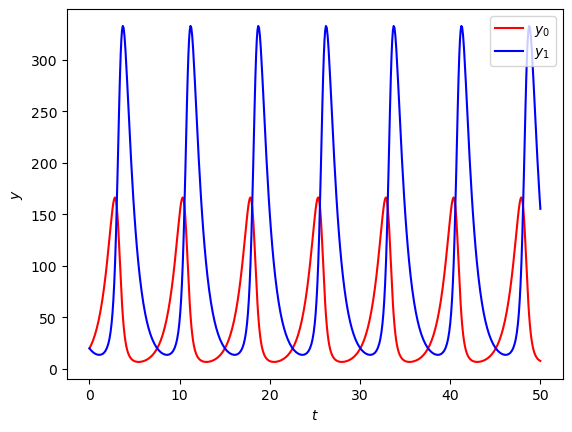

(2, 360)
(2, 361)
[20. 20.]
[  7.80876693 155.29101197]
[20.22627417 19.83029437]
[  7.80876693 155.29101197]
(361,)
(2, 361)


In [46]:
# %timeit test()
# for i in range(1000):
#     success, message, t, y = test()
#     if i % 30 == 0:
#         print(success, message)
#         diff_plot(t, y)
        

from CyRK.cy.cysolvertest import CySolverTester as CySolverTester

initial_conds = np.asarray((20., 20.), dtype=np.float64)
args = tuple()
time_span = (0., 50.)
rtol = 1.0e-7
atol = 1.0e-8

# CyRK - Cython CySolver
CySolverTesterInst = CySolverTester(time_span, initial_conds, rk_method=1, args=args, rtol=rtol, atol=atol, auto_solve=True)
print('CyRK (Cython - CySolver) Solution')
diff_plot(CySolverTesterInst.t, CySolverTesterInst.y, fig_name='CyRK_CySolver')

print(CySolverTesterInst.y.shape)
print(y.shape)
print(CySolverTesterInst.y[:, 0])
print(CySolverTesterInst.y[:, -1])
print(y[:, 0])
print(y[:, -1])

# for i in range(10_000):
#     if i % 1000 == 0:
#         print('Testing i: ', i)
#     success, message, t, y = test()
#     CySolverTesterInst = CySolverTester(time_span, initial_conds, rk_method=1, args=args, rtol=rtol, atol=atol, auto_solve=True)
#     assert np.allclose(t, CySolverTesterInst.t)
#     assert np.allclose(y, CySolverTesterInst.y)
        

print(t.shape)
print(y.shape)

In [278]:
t

array([2.77958238e+001, 3.31768836e+001, 3.96133722e+001, ...,
       7.17686209e+000, 4.99995729e+003, 1.40709149e-229])

In [276]:
# (50) 92.1us; 91.5us; 91.1us
# (500) 863us; 855us; 860us
# (5000) 8.43ms; 8.51ms; 8.5ms

%timeit test()

8.62 ms ± 61 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


CyRK (Cython - CySolver) Solution


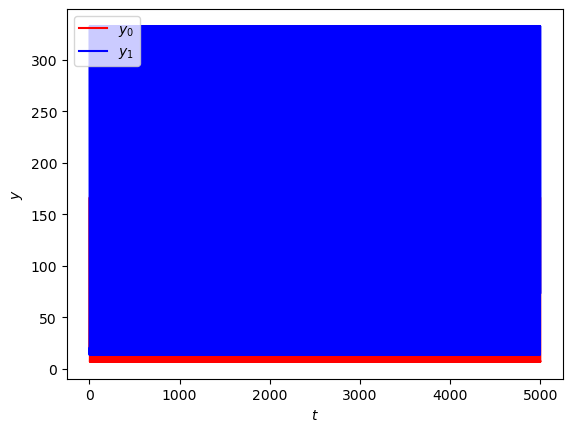

(2, 35293)


In [6]:
import numpy as np
from CyRK.cy.cysolvertest import CySolverTester as CySolverTester

initial_conds = np.asarray((20., 20.), dtype=np.float64)
args = tuple()
time_span = (0., 5000.)
rtol = 1.0e-7
atol = 1.0e-8

# CyRK - Cython CySolver
CySolverTesterInst = CySolverTester(time_span, initial_conds, rk_method=1, args=args, rtol=rtol, atol=atol, auto_solve=True)
print('CyRK (Cython - CySolver) Solution')
diff_plot(CySolverTesterInst.t, CySolverTesterInst.y, fig_name='CyRK_CySolver')

print(CySolverTesterInst.y.shape)

In [10]:
print(CySolverTesterInst.t[0], CySolverTesterInst.y[:, 0])
print(CySolverTesterInst.t[1], CySolverTesterInst.y[:, 1])
print(CySolverTesterInst.t[-2], CySolverTesterInst.y[:, -2])
print(CySolverTesterInst.t[-1], CySolverTesterInst.y[:, -1])

0.0 [20. 20.]
0.016939499668337042 [20.27322359 19.79866938]
49.912761495493996 [  8.23650756 167.09408194]
50.0 [  7.80876693 155.29101197]


In [7]:
# (50) 93.8us; 93.5us; 93.7us
# (500) 1.33ms; 1.33ms; 1.33ms
# (5000) 12.7ms; 12.6ms; 12.7ms


%timeit CySolverTester(time_span, initial_conds, rk_method=1, args=args, rtol=rtol, atol=atol, auto_solve=True)

12.6 ms ± 165 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [188]:
%timeit test_full_cpp()

101 µs ± 648 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [105]:
%%cython --annotate --force
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

from libcpp cimport bool as bool_cpp_t
from libc.math cimport sqrt, fabs, nextafter, fmax, fmin, isnan, NAN, pow, floor

from libc.stdlib cimport free

import numpy as np
cimport numpy as np

np.import_array()

from CyRK.utils.utils cimport allocate_mem, reallocate_mem
from CyRK.rk.rk cimport find_rk_properties
from CyRK.cy.common cimport interpolate, SAFETY, MIN_FACTOR, MAX_FACTOR, MAX_STEP, INF, EPS_100, \
    find_expected_size, find_max_num_steps

cdef (double, double) EMPTY_T_SPAN = (NAN, NAN)

from libc.stdio cimport printf

cdef class CySolver:
    # Class attributes
    # -- Solution variables
    cdef double* solution_y_ptr
    cdef double* solution_t_ptr
    cdef double* solution_extra_ptr
    cdef double[::1] solution_t_view
    cdef double[::1] solution_y_view
    cdef double[::1] solution_extra_view

    # -- Dependent (y0) variable information
    cdef size_t y_size
    cdef double y_size_dbl, y_size_sqrt
    cdef double* y0_ptr

    # -- Time information
    cdef double t_start, t_end, t_delta, t_delta_abs, direction_inf
    cdef bool_cpp_t direction_flag

    # -- Optional args info
    cdef size_t num_args
    cdef double* args_ptr
    cdef bool_cpp_t use_args

    # -- Extra output info
    cdef bool_cpp_t capture_extra
    cdef size_t num_extra

    # -- Integration information
    cdef readonly char status
    cdef readonly str message
    cdef public bool_cpp_t success
    cdef double* tol_ptrs
    cdef double* rtols_ptr
    cdef double* atols_ptr
    cdef double first_step, max_step
    cdef bool_cpp_t user_provided_max_num_steps
    cdef size_t max_num_steps
    cdef size_t expected_size, current_size, num_concats
    cdef bool_cpp_t recalc_first_step
    cdef bool_cpp_t force_fail

    # -- Interpolation info
    cdef bool_cpp_t run_interpolation
    cdef bool_cpp_t interpolate_extra
    cdef size_t len_t_eval
    cdef double* t_eval_ptr

    # -- RK method information
    cdef size_t rk_method, rk_order, error_order, rk_n_stages, rk_n_stages_plus1
    cdef double error_expo
    cdef size_t len_C, len_Arows, len_Acols
    cdef double* A_ptr
    cdef double* B_ptr
    cdef double* C_ptr
    cdef double* E_ptr
    cdef double* E3_ptr
    cdef double* E5_ptr
    # K is not constant. It is a temp storage variable used in RK calculations
    cdef double* K_ptr

    # -- Live variables
    cdef double t_now, t_old, step_size
    cdef size_t len_t, len_t_touse
    cdef double* temporary_y_ptrs
    cdef double* y_ptr
    cdef double* y_old_ptr
    cdef double* dy_ptr
    cdef double* dy_old_ptr
    cdef double* extra_output_ptrs
    cdef double* extra_output_init_ptr
    cdef double* extra_output_ptr

    # -- Pointers used during solve method
    cdef double* _solve_time_domain_array_ptr
    cdef double* _solve_y_results_array_ptr
    cdef double* _solve_extra_array_ptr

    # -- Pointers used during interpolation
    cdef double* _interpolate_solution_t_ptr
    cdef double* _interpolate_solution_y_ptr
    cdef double* _interpolate_solution_extra_ptr


    def __init__(self,
            (double, double) t_span,
            const double[::1] y0,
            tuple args = None,
            double rtol = 1.e-3,
            double atol = 1.e-6,
            const double[::1] rtols = None,
            const double[::1] atols = None,
            unsigned char rk_method = 1,
            double max_step = MAX_STEP,
            double first_step = 0.,
            size_t max_num_steps = 0,
            const double[::1] t_eval = None,
            bool_cpp_t capture_extra = False,
            size_t num_extra = 0,
            bool_cpp_t interpolate_extra = False,
            size_t expected_size = 0,
            size_t max_ram_MB = 2000,
            bool_cpp_t call_first_reset = True,
            bool_cpp_t auto_solve = True,
            bool_cpp_t force_fail = False):
        """
        Initialize new CySolver instance.

        Parameters
        ----------
        t_span : (double, double)
            Values of independent variable at beginning and end of integration.
        y0 : double[::1]
            Initial values for the dependent y variables at `t_span[0]`.
        args : tuple or None, default=None
            Additional arguments used by the differential equation.
            None (default) will tell the solver to not use additional arguments.
        rk_method : int, default=1
            Runge-Kutta method that will be used. Currently implemented models:
                0: ‘RK23’: Explicit Runge-Kutta method of order 3(2).
                1: ‘RK45’ (default): Explicit Runge-Kutta method of order 5(4).
                2: ‘DOP853’: Explicit Runge-Kutta method of order 8.
        rtol : double, default=1.0e-3
            Relative tolerance using in local error calculation.
        atol : double, default=1.0e-6
            Absolute tolerance using in local error calculation.
        rtols : const double[::1], default=None
            np.ndarray of relative tolerances, one for each dependent y variable.
            None (default) will use the same tolerance (set by `rtol`) for each y variable.
        atols : const double[::1], default=None
            np.ndarray of absolute tolerances, one for each dependent y variable.
            None (default) will use the same tolerance (set by `atol`) for each y variable.
        max_step : double, default=+Inf
            Maximum allowed step size.
        first_step : double, default=0
            First step's size (after `t_span[0]`).
            If set to 0 (the default) then the solver will attempt to guess a suitable initial step size.
        max_num_steps : size_t, default=0
            Maximum number of step sizes allowed before solver will auto fail.
            If set to 0 (the default) then the maximum number of steps will be equal to max integer size
            allowed on system architecture.
        t_eval : double[::1], default=None
            If not set to None, then a final interpolation will be performed on the solution to fit it to this array.
        capture_extra : bool = False
            If True, then additional output from the differential equation will be collected (but not used to determine
             integration error).
             Example:
                ```
                def diffeq(t, y, dy):
                    a = ... some function of y and t.
                    dy[0] = a**2 * sin(t) - y[1]
                    dy[1] = a**3 * cos(t) + y[0]

                    # Storing extra output in dy even though it is not part of the diffeq.
                    dy[2] = a
                ```
        num_extra : int = 0
            The number of extra outputs the integrator should expect. With the previous example there is 1 extra output.
        interpolate_extra : bool_cpp_t, default=False
            Flag if interpolation should be run on extra parameters.
            If set to False when `run_interpolation=True`, then interpolation will be run on solution's y, t. These will
            then be used to recalculate extra parameters rather than an interpolation on the extra parameters captured
            during integration.
        expected_size : size_t, default=0
            Anticipated size of integration range, i.e., how many steps will be required.
            Used to build temporary storage arrays for the solution results.
            If set to 0 (the default), then the solver will attempt to guess on a suitable expected size based on the
            relative tolerances and size of the integration domain.
        call_first_reset : bool, default=True
            If set to True, then the solver will call its `reset_state` method at the end of initialization. This flag
            is overridden by the `auto_solve` flag.
        auto_solve : bool_cpp_t, default=True
            If set to True, then the solver's `solve` method will be called at the end of initialization.
            Otherwise, the user will have to call `solver_instance = CySolver(...); solver_instance.solve()`
            to perform integration.
        """
        
        printf('\n\nNEW\nINITIALIZE\n')
        # Initialize all class pointers to null
        self.tol_ptrs = NULL
        self.rtols_ptr = NULL
        self.atols_ptr = NULL
        self.solution_y_ptr = NULL
        self.solution_t_ptr = NULL
        self.solution_extra_ptr = NULL
        self.y0_ptr = NULL
        self.args_ptr = NULL
        self.t_eval_ptr = NULL
        self.A_ptr = NULL
        self.B_ptr = NULL
        self.C_ptr = NULL
        self.E_ptr = NULL
        self.E3_ptr = NULL
        self.E5_ptr = NULL
        self.K_ptr = NULL
        self.temporary_y_ptrs = NULL
        self.y_ptr = NULL
        self.y_old_ptr = NULL
        self.dy_ptr = NULL
        self.dy_old_ptr = NULL
        self.extra_output_ptrs = NULL
        self.extra_output_init_ptr = NULL
        self.extra_output_ptr = NULL
        self._solve_time_domain_array_ptr = NULL
        self._solve_y_results_array_ptr = NULL
        self._solve_extra_array_ptr = NULL
        self._interpolate_solution_t_ptr = NULL
        self._interpolate_solution_y_ptr = NULL 
        self._interpolate_solution_extra_ptr = NULL

        # Loop variables
        cdef size_t i

        # Set integration information
        self.status  = -4  # Status code to indicate that integration has not started.
        self.message = 'Integration has not started.'
        self.success = False
        self.recalc_first_step = False
        self.force_fail = force_fail

        # Store y0 values and determine y-size information
        self.y_size = y0.size
        self.y_size_dbl = <double> self.y_size

        self.y_size_sqrt = sqrt(self.y_size_dbl)
        self.y0_ptr = <double *> allocate_mem(self.y_size * sizeof(double), 'y0_ptr (init)')
        for i in range(self.y_size):
            self.y0_ptr[i] = y0[i]

        # Determine time domain information
        self.t_start = t_span[0]
        self.t_end   = t_span[1]
        self.t_delta = self.t_end - self.t_start
        if self.t_delta >= 0.:
            # Integration is moving forward in time.
            self.direction_flag = True
            self.direction_inf  = INF
            self.t_delta_abs    = self.t_delta
        else:
            # Integration is moving backwards in time.
            self.direction_flag = False
            self.direction_inf  = -INF
            self.t_delta_abs    = -self.t_delta

        # Determine integration tolerances
        self.tol_ptrs  = <double *> allocate_mem(2 * self.y_size * sizeof(double), 'tol_ptrs (init)')
        self.rtols_ptr = &self.tol_ptrs[0]
        self.atols_ptr = &self.tol_ptrs[self.y_size]
        cdef double rtol_tmp, rtol_min
        rtol_min = INF

        if rtols is not None:
            # User provided an arrayed version of rtol.
            if len(rtols) != self.y_size:
                raise AttributeError('rtol array must be the same size as y0.')
            for i in range(self.y_size):
                rtol_tmp = rtols[i]
                # Check that the tolerances are not too small.
                if rtol_tmp < EPS_100:
                    rtol_tmp = EPS_100
                rtol_min = fmin(rtol_min, rtol_tmp)
                self.rtols_ptr[i] = rtol_tmp
        else:
            # No array provided. Use the same rtol for all ys.
            # Check that the tolerances are not too small.
            if rtol < EPS_100:
                rtol = EPS_100
            rtol_min = rtol
            for i in range(self.y_size):
                self.rtols_ptr[i] = rtol

        if atols is not None:
            # User provided an arrayed version of atol.
            if len(atols) != self.y_size:
                raise AttributeError('atol array must be the same size as y0.')
            for i in range(self.y_size):
                self.atols_ptr[i] = atols[i]
        else:
            # No array provided. Use the same atol for all ys.
            for i in range(self.y_size):
                self.atols_ptr[i] = atol
        
        # Determine extra outputs
        self.capture_extra = capture_extra
        # To avoid memory access violations we need to set the extra output arrays no matter if they are used.
        # If not used, just set them to size zero.
        if self.capture_extra:
            if num_extra <= 0:
                self.status = -8
                raise AttributeError('Capture extra set to True, but number of extra set to 0 (or negative).')
            self.num_extra = num_extra
        else:
            # Even though we are not capturing extra, we still want num_extra to be equal to 1 so that nan arrays
            # are properly initialized
            self.num_extra = 1

        # Expected size of output arrays.
        if expected_size == 0:
            # CySolver will attempt to guess on a best size for the arrays.
            self.expected_size = find_expected_size(
                self.y_size,
                num_extra,
                self.t_delta_abs,
                rtol_min,
                capture_extra,
                False)
        else:
            self.expected_size = expected_size
        # Set the current size to the expected size.
        # `expected_size` should never change but current might grow if expected size is not large enough.
        
        printf('EXPECTED (INPUT) SIZE: %d\n', expected_size)
        self.current_size = self.expected_size
        printf('EXPECTED SIZE: %d\n', self.expected_size)
        printf('CURRENT SIZE: %d\n', self.current_size)

        # Determine max number of steps
        find_max_num_steps(
            self.y_size,
            self.num_extra,
            max_num_steps,
            max_ram_MB,
            capture_extra,
            False,
            &self.user_provided_max_num_steps,
            &self.max_num_steps)

        # This variable tracks how many times the storage arrays have been appended.
        # It starts at 1 since there is at least one storage array present.
        self.num_concats = 1

        # Determine optional arguments
        if args is None:
            self.use_args = False
            # Even though there are no args set arg size to 1 to initialize nan arrays
            self.num_args = 1
        else:
            self.use_args = True
            self.num_args = len(args)
        self.args_ptr = <double *> allocate_mem(self.num_args * sizeof(double), 'args_ptr (init)')
        for i in range(self.num_args):
            if self.use_args:
                self.args_ptr[i] = args[i]
            else:
                self.args_ptr[i] = NAN

        # Initialize live variable arrays
        self.temporary_y_ptrs = <double *> allocate_mem(4 * self.y_size * sizeof(double), 'temporary_y_ptrs (init)')
        self.y_ptr      = &self.temporary_y_ptrs[0 * self.y_size]
        self.y_old_ptr  = &self.temporary_y_ptrs[1 * self.y_size]
        self.dy_ptr     = &self.temporary_y_ptrs[2 * self.y_size]
        self.dy_old_ptr = &self.temporary_y_ptrs[3 * self.y_size]

        self.extra_output_ptrs = <double *> allocate_mem(2 * self.num_extra * sizeof(double), 'extra_output_ptrs (init)')

        self.extra_output_init_ptr = &self.extra_output_ptrs[0 * self.num_extra]
        self.extra_output_ptr      = &self.extra_output_ptrs[1 * self.num_extra]
       
        for i in range(self.num_extra):
            self.extra_output_init_ptr[i] = NAN
            self.extra_output_ptr[i]      = NAN

        # Initialize storage variables
        self.solution_t_ptr = <double *> allocate_mem(sizeof(double), 'solution_t_ptr (init)')
        self.solution_t_ptr[0] = NAN

        self.solution_y_ptr = <double *> allocate_mem(self.y_size * sizeof(double), 'solution_y_ptr (init)')
        for i in range(self.y_size):
            self.solution_y_ptr[i] = NAN

        self.solution_extra_ptr = <double *> allocate_mem(self.num_extra * sizeof(double), 'solution_extra_ptr (init)')
        for i in range(self.num_extra):
            self.solution_extra_ptr[i] = NAN

        # Have solution memoryviews point to these addresses
        self.solution_t_view     = <double[:1]> self.solution_t_ptr
        self.solution_y_view     = <double[:self.y_size]> self.solution_y_ptr
        self.solution_extra_view = <double[:self.num_extra]> self.solution_extra_ptr

        # Determine interpolation information
        if t_eval is None:
            self.run_interpolation = False
            self.interpolate_extra = False
            # Even though we are not using t_eval, set its size equal to one so that nan arrays can be built
            self.len_t_eval = 1
        else:
            self.run_interpolation = True
            self.interpolate_extra = interpolate_extra
            self.len_t_eval = len(t_eval)

        self.t_eval_ptr = <double *> allocate_mem(self.len_t_eval * sizeof(double), 't_eval_ptr (init)')
        for i in range(self.len_t_eval):
            if self.run_interpolation:
                self.t_eval_ptr[i] = t_eval[i]
            else:
                self.t_eval_ptr[i] = NAN

        # Initialize RK arrays
        self.rk_method = rk_method
        find_rk_properties(
            self.rk_method,
            &self.rk_order,
            &self.error_order,
            &self.rk_n_stages,
            &self.len_Arows,
            &self.len_Acols,
            &self.A_ptr,
            &self.B_ptr,
            &self.C_ptr,
            &self.E_ptr,
            &self.E3_ptr,
            &self.E5_ptr
            )

        if self.rk_order == 0:
            raise AttributeError('Unknown or not-yet-implemented RK method requested.')
        
        self.len_C             = self.rk_n_stages
        self.rk_n_stages_plus1 = self.rk_n_stages + 1
        self.error_expo        = 1. / (<double>self.error_order + 1.)

        # Initialize other RK-related Arrays
        self.K_ptr = <double *> allocate_mem(self.rk_n_stages_plus1 * self.y_size * sizeof(double), 'K_ptr (init)')

        # Store user provided step information
        self.first_step = first_step
        self.max_step   = max_step

        # Parameters are initialized but may not be set to correct values.
        # Call reset state to ensure everything is ready.
        if call_first_reset or auto_solve:
            self.reset_state()

        # Run solver if requested
        printf('END INIT\n')
        if auto_solve:
            # We know for a fact that this is the first time solve will be called and we just reset the Sovler's state
            # So we can safely tell the solve method not to reset.
            self._solve(reset=False)


    cpdef void reset_state(self):
        """ Resets the class' state variables so that integration can be rerun. """
        cdef size_t i, j
        cdef double temp_double
        
        printf('RESET\n')

        # Set current and old time variables equal to t0
        self.t_old = self.t_start
        self.t_now = self.t_start
        # Track number of steps.
        # Initial conditions were provided so the number of steps is already 1
        self.len_t = 1

        # It is important K be initialized with 0s
        for i in range(self.rk_n_stages_plus1):
            for j in range(self.y_size):
                self.K_ptr[i * self.y_size + j] = 0.

                # While we have this loop; set y back to initial conditions
                if i == 0:
                    temp_double       = self.y0_ptr[j]
                    self.y_ptr[j]     = temp_double
                    self.y_old_ptr[j] = temp_double

        # Update any constant parameters that the user has set
        printf('UPDATE CONSTANTS\n')
        self.update_constants()

        # Make initial call to diffeq()
        printf('PRE-DIFEQ\n')
        self.diffeq()

        # Store first dydt
        for i in range(self.y_size):
            self.dy_old_ptr[i] = self.dy_ptr[i]

        # Store extra outputs for the first time step
        if self.capture_extra:
            for i in range(self.num_extra):
                self.extra_output_init_ptr[i] = self.extra_output_ptr[i]

        # Determine first step's size
        if self.first_step == 0. or self.recalc_first_step:
            self.step_size = self.calc_first_step()
        else:
            if self.first_step <= 0.:
                self.status = -8
                self.message = "Attribute error."
                raise AttributeError('Error in user-provided step size: Step size must be a positive number.')
            elif self.first_step > self.t_delta_abs:
                self.status = -8
                self.message = "Attribute error."
                raise AttributeError('Error in user-provided step size: Step size can not exceed bounds.')
            self.step_size = self.first_step

        # Reset output storage
        self.current_size = self.expected_size
        
        printf('EXPECTED (RESET) SIZE: %d\n', self.expected_size)
        printf('CURRENT (RESET) SIZE: %d\n', self.current_size)
        self.num_concats = 1

        # Reset storage variables to clear any old solutions and to avoid access violations if solve() is not called.
        self.solution_t_ptr[0] = NAN
        for i in range(self.y_size):
            self.solution_y_ptr[i] = NAN
        for i in range(self.num_extra):
            self.solution_extra_ptr[i] = NAN

        # Have solution memoryviews point to these addresses
        self.solution_t_view     = <double[:1]> self.solution_t_ptr
        self.solution_y_view     = <double[:self.y_size]> self.solution_y_ptr
        self.solution_extra_view = <double[:self.num_extra]> self.solution_extra_ptr

        # Other integration flags and messages
        self.success = False
        self.status = -5  # status == -5 means that reset has been called but solve has not yet been called.
        self.message = "CySolver has been reset."
        printf('END RESET\n')


    cdef double calc_first_step(self) noexcept nogil:
        """
        Select an initial step size based on the differential equation.
        .. [1] E. Hairer, S. P. Norsett G. Wanner, "Solving Ordinary Differential
               Equations I: Nonstiff Problems", Sec. II.4.
        """

        cdef double step_size, d0, d1, d2, d0_abs, d1_abs, d2_abs, h0, h1, scale
        cdef double y_old_tmp
        
        printf('CALC FIRST STEP\n')

        if self.y_size == 0:
            step_size = INF
        else:
            # Find the norm for d0 and d1
            d0 = 0.
            d1 = 0.
            for i in range(self.y_size):
                y_old_tmp = self.y_old_ptr[i]

                scale = self.atols_ptr[i] + fabs(y_old_tmp) * self.rtols_ptr[i]

                d0_abs = fabs(y_old_tmp / scale)
                d1_abs = fabs(self.dy_old_ptr[i] / scale)
                d0 += (d0_abs * d0_abs)
                d1 += (d1_abs * d1_abs)

            d0 = sqrt(d0) / self.y_size_sqrt
            d1 = sqrt(d1) / self.y_size_sqrt

            if d0 < 1.e-5 or d1 < 1.e-5:
                h0 = 1.e-6
            else:
                h0 = 0.01 * d0 / d1

            if self.direction_flag:
                h0_direction = h0
            else:
                h0_direction = -h0

            self.t_now = self.t_old + h0_direction
            for i in range(self.y_size):
                self.y_ptr[i] = self.y_old_ptr[i] + h0_direction * self.dy_old_ptr[i]

            # Update dy_new_view
            self.diffeq()

            # Find the norm for d2
            d2 = 0.
            for i in range(self.y_size):

                scale = self.atols_ptr[i] + fabs(self.y_old_ptr[i]) * self.rtols_ptr[i]
                d2_abs = fabs( (self.dy_ptr[i] - self.dy_old_ptr[i]) / scale)
                d2 += (d2_abs * d2_abs)

            d2 = sqrt(d2) / (h0 * self.y_size_sqrt)

            if d1 <= 1.e-15 and d2 <= 1.e-15:
                h1 = fmax(1.e-6, h0 * 1.e-3)
            else:
                h1 = (0.01 / fmax(d1, d2))**self.error_expo

            step_size = fmax(10. * fabs(nextafter(self.t_old, self.direction_inf) - self.t_old),
                            fmin(100. * h0, h1))

        return step_size


    cdef void rk_step(self) noexcept nogil:
        """ Performs a Runge-Kutta step calculation including local error determination. """

        # Initialize step variables
        cdef size_t s, i, j
        cdef double min_step, step, step_factor, time_tmp, t_delta_check
        cdef double scale, temp_double
        cdef double error_norm3, error_norm5, error_norm, error_dot_1, error_dot_2, error_denom, error_pow
        cdef bool_cpp_t step_accepted, step_rejected, step_error

        # Run RK integration step
        # Determine step size based on previous loop
        # Find minimum step size based on the value of t (less floating point numbers between numbers when t is large)
        min_step = 10. * fabs(nextafter(self.t_old, self.direction_inf) - self.t_old)
        # Look for over/undershoots in previous step size
        if self.step_size > self.max_step:
            self.step_size = self.max_step
        elif self.step_size < min_step:
            self.step_size = min_step

        # Determine new step size
        step_accepted = False
        step_rejected = False
        step_error    = False

        # Optimization variables
        cdef double A_at_10
        # Define a very specific A (Row 1; Col 0) now since it is called consistently and does not change.
        A_at_10 = self.A_ptr[1 * self.len_Acols + 0]

        # # Step Loop
        while not step_accepted:
            if self.step_size < min_step:
                step_error  = True
                self.status = -1
                break

            # Move time forward for this particular step size
            if self.direction_flag:
                step          = self.step_size
                self.t_now    = self.t_old + step
                t_delta_check = self.t_now - self.t_end
            else:
                step          = -self.step_size
                self.t_now    = self.t_old + step
                t_delta_check = self.t_end - self.t_now

            # Check that we are not at the end of integration with that move
            if t_delta_check > 0.:
                self.t_now = self.t_end

                # If we are, correct the step so that it just hits the end of integration.
                step = self.t_now - self.t_old
                if self.direction_flag:
                    self.step_size = step
                else:
                    self.step_size = -step

            # # Calculate derivative using RK method

            # t_now must be updated for each loop of s in order to make the diffeq calls.
            # But we need to return to its original value later on. Store in temp variable.
            time_tmp = self.t_now

            for s in range(1, self.len_C):
                # Update t_now so it can be used in the diffeq call.
                self.t_now = self.t_old + self.C_ptr[s] * step

                # Dot Product (K, a) * step
                if s == 1:
                    for i in range(self.y_size):
                        # Set the first column of K
                        temp_double = self.dy_old_ptr[i]
                        # K[0, :] == first part of the array
                        self.K_ptr[i] = temp_double

                        # Calculate y_new for s==1
                        self.y_ptr[i] = self.y_old_ptr[i] + (temp_double * A_at_10 * step)
                else:
                    for j in range(s):
                        temp_double = self.A_ptr[s * self.len_Acols + j] * step
                        for i in range(self.y_size):
                            if j == 0:
                                # Initialize
                                self.y_ptr[i] = self.y_old_ptr[i]

                            self.y_ptr[i] += self.K_ptr[j * self.y_size + i] * temp_double

                # Call diffeq to update K with the new dydt
                self.diffeq()

                for i in range(self.y_size):
                    self.K_ptr[s * self.y_size + i] = self.dy_ptr[i]

            # Restore t_now to its previous value.
            self.t_now = time_tmp

            # Dot Product (K, B) * step
            for j in range(self.rk_n_stages):
                temp_double = self.B_ptr[j] * step
                # We do not use rk_n_stages_plus1 here because we are chopping off the last row of K to match
                #  the shape of B.
                for i in range(self.y_size):
                    if j == 0:
                        # Initialize
                        self.y_ptr[i] = self.y_old_ptr[i]

                    self.y_ptr[i] += self.K_ptr[j * self.y_size + i] * temp_double

            # Find final dydt for this timestep
            self.diffeq()

            # Check how well this step performed by calculating its error
            if self.rk_method == 2:
                # Calculate Error for DOP853
                # Dot Product (K, E5) / scale and Dot Product (K, E3) * step / scale
                error_norm3 = 0.
                error_norm5 = 0.
                for i in range(self.y_size):
                    # Find scale of y for error calculations
                    scale = (self.atols_ptr[i] +
                             max(fabs(self.y_old_ptr[i]), fabs(self.y_ptr[i])) * self.rtols_ptr[i])

                    # Set last array of K equal to dydt
                    self.K_ptr[self.rk_n_stages * self.y_size + i] = self.dy_ptr[i]
                    # Initialize
                    error_dot_1 = 0.
                    error_dot_2 = 0.
                    for j in range(self.rk_n_stages_plus1):

                        temp_double = self.K_ptr[j * self.y_size + i]
                        error_dot_1 += temp_double * self.E3_ptr[j]
                        error_dot_2 += temp_double * self.E5_ptr[j]

                    # We need the absolute value but since we are taking the square, it is guaranteed to be positive.
                    # TODO: This will need to change if CySolver ever accepts complex numbers
                    # error_norm3_abs = fabs(error_dot_1)
                    # error_norm5_abs = fabs(error_dot_2)
                    error_dot_1 /= scale
                    error_dot_2 /= scale

                    error_norm3 += (error_dot_1 * error_dot_1)
                    error_norm5 += (error_dot_2 * error_dot_2)

                # Check if errors are zero
                if (error_norm5 == 0.) and (error_norm3 == 0.):
                    error_norm = 0.
                else:
                    error_denom = error_norm5 + 0.01 * error_norm3
                    error_norm = self.step_size * error_norm5 / sqrt(error_denom * self.y_size_dbl)

            else:
                # Calculate Error for RK23 and RK45
                # Dot Product (K, E) * step / scale
                error_norm = 0.
                for i in range(self.y_size):
                    # Find scale of y for error calculations
                    scale = (self.atols_ptr[i] +
                             max(fabs(self.y_old_ptr[i]), fabs(self.y_ptr[i])) * self.rtols_ptr[i])

                    # Set last array of K equal to dydt
                    self.K_ptr[self.rk_n_stages * self.y_size + i] = self.dy_ptr[i]
                    # Initialize
                    error_dot_1 = 0.
                    for j in range(self.rk_n_stages_plus1):

                        error_dot_1 += self.K_ptr[j * self.y_size + i] * self.E_ptr[j]

                    # We need the absolute value but since we are taking the square, it is guaranteed to be positive.
                    # TODO: This will need to change if CySolver ever accepts complex numbers
                    # error_norm_abs = fabs(error_dot_1)
                    error_dot_1 *= (step / scale)

                    error_norm += (error_dot_1 * error_dot_1)
                error_norm = sqrt(error_norm) / self.y_size_sqrt

            if error_norm < 1.:
                # The error is low! Let's update this step for the next time loop
                if error_norm == 0.:
                    step_factor = MAX_FACTOR
                else:
                    error_pow = pow(error_norm, -self.error_expo)
                    step_factor = fmin(MAX_FACTOR, SAFETY * error_pow)

                if step_rejected:
                    # There were problems with this step size on the previous step loop. Make sure factor does
                    #    not exasperate them.
                    step_factor = fmin(step_factor, 1.)

                self.step_size = self.step_size * step_factor
                step_accepted = True
            else:
                error_pow = pow(error_norm, -self.error_expo)
                self.step_size = self.step_size * fmax(MIN_FACTOR, SAFETY * error_pow)
                step_rejected = True

        if step_error:
            # Issue with step convergence
            self.status = -1
        elif not step_accepted:
            # Issue with step convergence
            self.status = -7

        # End of step loop. Update the 'old' variables
        self.t_old = self.t_now
        for i in range(self.y_size):
            self.y_old_ptr[i]  = self.y_ptr[i]
            self.dy_old_ptr[i] = self.dy_ptr[i]


    cpdef void solve(
            self,
            bool_cpp_t reset = True
            ):
        """
        Public wrapper to the private solve method which calculates the integral of the user-provided system of ODEs.
        
        Parameters
        ----------
        reset : bool_cpp_t, default=True
            If True, `reset_state()` will be called before integration starts.
        """
        self._solve(reset=reset)


    cdef void _solve(
            self,
            bool_cpp_t reset = True
            ):
        """
        Calculates the integral of the user-provided system of ODEs.
        
        Parameters
        ----------
        reset : bool_cpp_t, default=True
            If True, `reset_state()` will be called before integration starts.
        """
        
        printf('SOLVE\n')
        # Reset the solver's state (avoid issues if solve() is called multiple times).
        if reset:
            self.reset_state()

        # Setup loop variables
        cdef size_t i

        # Setup storage arrays
        # These arrays are built to fit a number of points equal to `self.expected_size`
        # If the integration needs more than that then a new array will be concatenated (with performance costs) to these.        
        if self._solve_time_domain_array_ptr is NULL:
            self._solve_time_domain_array_ptr = <double *> allocate_mem(
                self.current_size * sizeof(double),
                '_solve_time_domain_array_ptr (_solve)')
        else:
            self._solve_time_domain_array_ptr = <double *> reallocate_mem(
                self._solve_time_domain_array_ptr,
                self.current_size * sizeof(double),
                '_solve_time_domain_array_ptr (_solve)')

        if self._solve_y_results_array_ptr is NULL:
            self._solve_y_results_array_ptr = <double *> allocate_mem(
                self.y_size * self.current_size * sizeof(double),
                '_solve_y_results_array_ptr (_solve)')
        else:
            self._solve_y_results_array_ptr = <double *> reallocate_mem(
                self._solve_y_results_array_ptr,
                self.y_size * self.current_size * sizeof(double),
                '_solve_y_results_array_ptr (_solve)')
        
        if self.capture_extra:
            if self._solve_extra_array_ptr is NULL:
                self._solve_extra_array_ptr = <double *> allocate_mem(
                    self.num_extra * self.current_size * sizeof(double),
                    '_solve_extra_array_ptr (_solve)')
            else:
                self._solve_extra_array_ptr = <double *> reallocate_mem(
                    self._solve_extra_array_ptr,
                    self.num_extra * self.current_size * sizeof(double),
                    '_solve_extra_array_ptr (_solve)')

        # Load initial conditions into storage arrays
        self._solve_time_domain_array_ptr[0] = self.t_start
        for i in range(self.y_size):
            self._solve_y_results_array_ptr[i] = self.y0_ptr[i]
        if self.capture_extra:
            for i in range(self.num_extra):
                self._solve_extra_array_ptr[i] = self.extra_output_init_ptr[i]

        # # Main integration loop
        self.status = 0

        if self.y_size == 0:
            self.status = -6

        while self.status == 0:

            # Check that integration is not complete.
            if self.t_now == self.t_end:
                self.t_old = self.t_end
                self.status = 1
                break

            # Check that maximum number of steps has not been exceeded.
            if self.len_t > self.max_num_steps:
                if self.user_provided_max_num_steps:
                    self.status = -2
                else:
                    self.status = -3
                break

            # # Perform RK Step
            self.rk_step()

            # Check if an error occurred during step calculations before storing data.
            if self.status != 0:
                break

            # Store data
            if self.len_t >= self.current_size:
                
                printf('(RESIZE PRE)EXPECTED SIZE: %d\n', self.expected_size)
                printf('(RESIZE PRE)CURRENT SIZE: %d\n', self.current_size)
                # There is more data then we have room in our arrays.
                # Build new arrays with more space.
                # OPT: Note this is an expensive operation.
                self.num_concats += 1

                # Grow the array by 50% its current value
                self.current_size = <size_t> floor(<double>self.current_size * (1.5))
                
                printf('(RESIZE POST)EXPECTED SIZE: %d\n', self.expected_size)
                printf('(RESIZE POST)CURRENT SIZE: %d\n', self.current_size)

                self._solve_time_domain_array_ptr = <double *> reallocate_mem(
                    self._solve_time_domain_array_ptr,
                    self.current_size * sizeof(double),
                    'self._solve_time_domain_array_ptr (_solve; growth stage)')

                self._solve_y_results_array_ptr = <double *> reallocate_mem(
                    self._solve_y_results_array_ptr,
                    self.y_size * self.current_size * sizeof(double),
                    'self._solve_y_results_array_ptr (_solve; growth stage)')

                if self.capture_extra:
                    self._solve_extra_array_ptr = <double *> reallocate_mem(
                        self._solve_extra_array_ptr,
                        self.num_extra * self.current_size * sizeof(double),
                        'self._solve_extra_array_ptr (_solve; growth stage)')

            # Add this step's results to our storage arrays.
            self._solve_time_domain_array_ptr[self.len_t] = self.t_now
            for i in range(self.y_size):
                self._solve_y_results_array_ptr[self.len_t * self.y_size + i] = self.y_ptr[i]

            if self.capture_extra:
                for i in range(self.num_extra):
                    self._solve_extra_array_ptr[self.len_t * self.num_extra + i] = self.extra_output_ptr[i]

            # Increase number of independent variable points.
            self.len_t += 1

        # Integration has stopped. Check if it was successful.
        printf('END SOLVE LOOP\n')
        if self.status != 1 or self.force_fail:
            self.success = False
        else:
            self.success = True

        if self.success:
            printf('SUCCESS\n')
            printf('(SUCCESS1)EXPECTED SIZE: %d\n', self.expected_size)
            printf('(SUCCESS1)CURRENT SIZE: %d\n', self.current_size)
            # Solution was successful.
            # Free any data stored in solution arrays so that we can repopulate them with the new solution
            if not (self.solution_t_ptr is NULL):
                printf('FREE SOL-t\n')
                free(self.solution_t_ptr)
                self.solution_t_ptr = NULL
                printf('\tSuccess.\n')
            if not (self.solution_y_ptr is NULL):
                printf('FREE SOL-y\n')
                free(self.solution_y_ptr)
                self.solution_y_ptr = NULL
                printf('\tSuccess.\n')
            if self.capture_extra:
                if not (self.solution_extra_ptr is NULL):
                    printf('FREE SOL-ex\n')
                    free(self.solution_extra_ptr)
                    self.solution_extra_ptr = NULL
                    printf('\tSuccess.\n')

            # Load values into solution arrays.
            # The arrays built during integration likely have a bunch of unused junk at the end due to overbuilding their size.
            # This process will remove that junk and leave only the valid data.
            # These arrays will always be the same length or less (self.len_t <= self.current_size) than the ones they are
            # built off of, so it is safe to use Realloc.
            
            printf('(SUCCESS2)EXPECTED SIZE: %d\n', self.expected_size)
            printf('(SUCCESS2)CURRENT SIZE: %d\n', self.current_size)
            printf('REALL SO-t.. %p. Old Size: %d. New Size: %d\n', self._solve_time_domain_array_ptr, self.current_size * sizeof(double), self.len_t * sizeof(double))
            self.solution_t_ptr = <double *> reallocate_mem(
                self._solve_time_domain_array_ptr,
                self.len_t * sizeof(double),
                'solution_t_ptr (_solve; success stage)')
            self._solve_time_domain_array_ptr = NULL
            printf('\tSuccess.\n')
            
            printf('REALL SO-y.. %p. Old Size: %d. New Size: %d\n', self._solve_y_results_array_ptr, self.y_size * self.current_size * sizeof(double), self.y_size * self.len_t * sizeof(double),)
            self.solution_y_ptr = <double *> reallocate_mem(
                self._solve_y_results_array_ptr,
                self.y_size * self.len_t * sizeof(double),
                'solution_y_ptr (_solve; success stage)')
            self._solve_y_results_array_ptr = NULL
            printf('\tSuccess.\n')

            if self.capture_extra:
                printf('REALL SO-ex.. %p. Old Size: %d. New Size: %d\n', self._solve_extra_array_ptr, self.num_extra * self.current_size * sizeof(double), self.num_extra * self.len_t * sizeof(double))
                self.solution_extra_ptr = <double *> reallocate_mem(
                    self._solve_extra_array_ptr,
                    self.num_extra * self.len_t * sizeof(double),
                    'solution_extra_ptr (_solve; success stage)')
                self._solve_extra_array_ptr = NULL
                printf('\tSuccess.\n')
        else:
            printf('FAIL\n')
            # Integration was not successful. Make solution pointers length 1 nan arrays.
            # Clear the storage arrays used during the step loop
            if not (self._solve_time_domain_array_ptr is NULL):
                free(self._solve_time_domain_array_ptr)
                self._solve_time_domain_array_ptr = NULL
            if not (self._solve_y_results_array_ptr is NULL):
                free(self._solve_y_results_array_ptr)
                self._solve_y_results_array_ptr = NULL
            if self.capture_extra:
                if not (self._solve_extra_array_ptr is NULL):
                    free(self._solve_extra_array_ptr)
                    self._solve_extra_array_ptr = NULL

            # We still need to build solution arrays so that accessing the solution will not cause access violations.
            # Build size-1 arrays. Since the solution was not successful, set all arrays to NANs
            self.solution_t_ptr = <double *> reallocate_mem(
                self.solution_t_ptr,
                sizeof(double),
                'solution_t_ptr (_solve; fail stage)')
            self.solution_t_ptr[0] = NAN

            self.solution_y_ptr = <double *> reallocate_mem(
                self.solution_y_ptr,
                self.y_size * sizeof(double),
                'solution_y_ptr (_solve; fail stage)')
            for i in range(self.y_size):
                self.solution_t_ptr[i] = NAN

            self.solution_extra_ptr = <double *> reallocate_mem(
                self.solution_extra_ptr,
                self.num_extra * 1 * sizeof(double),
                'solution_extra_ptr (_solve; fail stage)')
            for i in range(self.num_extra):
                self.solution_extra_ptr[i] = NAN

        # Integration is complete. Check if interpolation was requested.
        if self.success:
            if self.run_interpolation:
                printf('PRE-INTERP\n')
                self.interpolate()
                # Use different len_t
                self.len_t_touse = self.len_t_eval
            else:
                self.len_t_touse = self.len_t
        else:
            # If integration was not successful use t_len = 1 to allow for nan arrays
            self.len_t_touse = 1

        # Convert solution pointers to a more user-friendly memoryview format.
        # Define post-run variables
        cdef size_t y_size_touse, extra_size_touse
        y_size_touse     = self.y_size * self.len_t_touse
        extra_size_touse = self.num_extra * self.len_t_touse
        
        printf('BUILD MEMORYVIEWS\n')
        self.solution_t_view     = <double[:self.len_t_touse]> self.solution_t_ptr
        self.solution_y_view     = <double[:y_size_touse]> self.solution_y_ptr
        self.solution_extra_view = <double[:extra_size_touse]> self.solution_extra_ptr

        # Update integration message
        if self.status == 1:
            self.message = "Integration completed without issue."
        elif self.status == 0:
            self.message = "Integration is/was ongoing (perhaps it was interrupted?)."
        elif self.status == -1:
            self.message = "Error in step size calculation:\n\tRequired step size is less than spacing between numbers."
        elif self.status == -2:
            self.message = "Maximum number of steps (set by user) exceeded during integration."
        elif self.status == -3:
            self.message = "Maximum number of steps (set by system architecture) exceeded during integration."
        elif self.status == -6:
            self.message = "Integration never started: y-size is zero."
        elif self.status == -7:
            self.message = "Error in step size calculation:\n\tError in step size acceptance."

        # Release any memory that may still be alive due to exceptions being raised.
        if not (self._solve_time_domain_array_ptr is NULL):
            free(self._solve_time_domain_array_ptr)
            self._solve_time_domain_array_ptr = NULL
        if not (self._solve_y_results_array_ptr is NULL):
            free(self._solve_y_results_array_ptr)
            self._solve_y_results_array_ptr = NULL
        if not (self._solve_extra_array_ptr is NULL):
            free(self._solve_extra_array_ptr)
            self._solve_extra_array_ptr = NULL
        
        printf('END SOLVE\n')


    cdef void interpolate(self):
        """ Interpolate the results of a successful integration over the user provided time domain, `t_eval`. """
        # User only wants data at specific points.
        cdef char old_status
        old_status = self.status
        self.status = 2  # Interpolation is being performed.

        # Setup loop variables
        cdef size_t i, j
        printf('INTERPOLATE\n')

        # TODO: The current version of CySolver has not implemented sicpy's dense output. Instead we use an interpolation.
        # Build final interpolated time and solution arrays
        if self._interpolate_solution_t_ptr is NULL:
            self._interpolate_solution_t_ptr = <double *> allocate_mem(
                self.len_t_eval * sizeof(double),
                '_interpolate_solution_t_ptr (interpolate)')
        else:
            self._interpolate_solution_t_ptr = <double *> reallocate_mem(
                self._interpolate_solution_t_ptr,
                self.len_t_eval * sizeof(double),
                '_interpolate_solution_t_ptr (interpolate)')

        if self._interpolate_solution_y_ptr is NULL:
            self._interpolate_solution_y_ptr = <double *> allocate_mem(
                self.y_size * self.len_t_eval * sizeof(double),
                'self._interpolate_solution_y_ptr (interpolate)')
        else:
            self._interpolate_solution_y_ptr = <double *> reallocate_mem(
                self._interpolate_solution_y_ptr,
                self.y_size * self.len_t_eval * sizeof(double),
                'self._interpolate_solution_y_ptr (interpolate)')

        # Perform interpolation on y values
        interpolate(self.solution_t_ptr, self.t_eval_ptr, self.solution_y_ptr, self._interpolate_solution_y_ptr,
                    self.len_t, self.len_t_eval, self.y_size, False)

        # Make a copy of t_eval (issues can arise if we store the t_eval pointer in solution array).
        for i in range(self.len_t_eval):
            self._interpolate_solution_t_ptr[i] = self.t_eval_ptr[i]

        if self.capture_extra:
            printf('INTERPOLATE EXTRA\n')
            # Right now if there is any extra output then it is stored at each time step used in the RK loop.
            # We have to make a choice:
            #   - Do we interpolate the extra values that were stored?
            #   - Or do we use the interpolated t, y values to find new extra parameters at those specific points.
            # The latter method is more computationally expensive (recalls the diffeq for each y) but is more accurate.
            # This decision is set by the user with the `interpolate_extra` flag.

            # Build final interpolated solution array (Used if self.interpolate_extra is True or False)
            if self._interpolate_solution_extra_ptr is NULL:
                self._interpolate_solution_extra_ptr = <double *> allocate_mem(
                    self.num_extra * self.len_t_eval * sizeof(double),
                    'self._interpolate_solution_extra_ptr (interpolate)')
            else:
                self._interpolate_solution_extra_ptr = <double *> reallocate_mem(
                    self._interpolate_solution_extra_ptr,
                    self.num_extra * self.len_t_eval * sizeof(double),
                    'self._interpolate_solution_extra_ptr (interpolate)')

            if self.interpolate_extra:
                # Perform interpolation on extra outputs
                interpolate(
                    self.solution_t_ptr, self.t_eval_ptr, self.solution_extra_ptr, self._interpolate_solution_extra_ptr,
                    self.len_t, self.len_t_eval, self.num_extra, False)
            else:
                # Use the new interpolated y and t values to recalculate the extra outputs with self.diffeq
                for i in range(self.len_t_eval):
                    # Set state variables
                    self.t_now = self.t_eval_ptr[i]
                    for j in range(self.y_size):
                        self.y_ptr[j] = self._interpolate_solution_y_ptr[i * self.y_size + j]

                    # Call diffeq to recalculate extra outputs
                    self.diffeq()

                    # Capture extras
                    for j in range(self.num_extra):
                        self._interpolate_solution_extra_ptr[i * self.num_extra + j] = self.extra_output_ptr[j]

            # Replace old pointers with new interpolated pointers and release the memory for the old stuff
            if not (self.solution_extra_ptr is NULL):
                free(self.solution_extra_ptr)
            self.solution_extra_ptr = self._interpolate_solution_extra_ptr
            self._interpolate_solution_extra_ptr = NULL

        # Replace old pointers with new interpolated pointers and release the memory for the old stuff
        if not (self.solution_t_ptr is NULL):
            free(self.solution_t_ptr)
        self.solution_t_ptr = self._interpolate_solution_t_ptr
        self._interpolate_solution_t_ptr = NULL
        if not (self.solution_y_ptr is NULL):
            free(self.solution_y_ptr)
        self.solution_y_ptr = self._interpolate_solution_y_ptr
        self._interpolate_solution_y_ptr = NULL

        # Interpolation is done.
        self.status = old_status

        # Free any memory that may still be alive if exceptions were raised.
        if not (self._interpolate_solution_t_ptr is NULL):
            free(self._interpolate_solution_t_ptr)
            self._interpolate_solution_t_ptr = NULL
        if not (self._interpolate_solution_y_ptr is NULL):
            free(self._interpolate_solution_y_ptr)
            self._interpolate_solution_y_ptr = NULL
        if not (self._interpolate_solution_extra_ptr is NULL):
            free(self._interpolate_solution_extra_ptr)
            self._interpolate_solution_extra_ptr = NULL
        
        printf('END INTERPOLATE\n')

    cpdef void change_t_span(
            self,
            (double, double) t_span,
            bool_cpp_t auto_reset_state = False
            ):
        """
        Public method to change the independent variable limits (start and stop points of integration).
        
        Parameters
        ----------
        t_span : (double, double)
            New t_span to use during integration.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        # Update time domain information
        self.t_start     = t_span[0]
        self.t_end       = t_span[1]
        self.t_delta     = self.t_end - self.t_start
        if self.t_delta >= 0.:
            self.direction_flag = True
            self.direction_inf  = INF
            self.t_delta_abs    = self.t_delta
        else:
            self.direction_flag = False
            self.direction_inf  = -INF
            self.t_delta_abs    = -self.t_delta

        # A change to t-span will affect the first step's size
        self.recalc_first_step = True

        if auto_reset_state:
            self.reset_state()


    cpdef void change_y0(
            self,
            const double[::1] y0,
            bool_cpp_t auto_reset_state = False
            ):
        """
        Public method to change the initial conditions.
        
        Note: the size of y0 can not be different from the original y0 used to instantiate the class instance.

        Parameters
        ----------
        y0 : double[::1]
            New dependent variable initial conditions.
            Must be the same size as the original y0.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        # Check y-size information
        cdef size_t i, y_size_new
        y_size_new = len(y0)

        if self.y_size != y_size_new:
            # So many things need to update if ysize changes that the user should just create a new class instance.
            self.status = -8
            self.message = "Attribute error."
            raise AttributeError('New y0 must be the same size as the original y0 used to create CySolver class.'
                                 'Create new CySolver instance instead.')

        # Store y0 values for later
        for i in range(self.y_size):
            self.y0_ptr[i] = y0[i]

        # A change to y0 will affect the first step's size
        self.recalc_first_step = True

        if auto_reset_state:
            self.reset_state()

    cdef void change_y0_pointer(
                self,
                double* y0_ptr,
                bool_cpp_t auto_reset_state = False
                ):
            """
            Public method to change the initial conditions.

            Note: the size of y0 can not be different from the original y0 used to instantiate the class instance.

            Parameters
            ----------
            y0 : double*
                New pointer to dependent variable initial conditions.
                Must be the same size as the original y0.
            auto_reset_state : bool_cpp_t, default=False
                If True, then the `reset_state` method will be called once parameter is changed.
            """

            # This function is not as safe as `change_y0` as it assumes that the user provided the same length y0.

            # Check y-size information
            cdef size_t i

            # Store y0 values for later
            for i in range(self.y_size):
                self.y0_ptr[i] = y0_ptr[i]

            # A change to y0 will affect the first step's size
            self.recalc_first_step = True

            if auto_reset_state:
                self.reset_state()


    cpdef void change_args(
            self,
            tuple args,
            bool_cpp_t auto_reset_state = False
            ):
        """
        Public method to change additional arguments used during integration.

        Parameters
        ----------
        args : tuple
            New tuple of additional arguments.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        # Determine optional arguments
        if args is None:
            self.use_args = False
            # Even though there are no args set arg size to 1 to initialize nan arrays
            self.num_args = 1
        else:
            self.use_args = True
            self.num_args = len(args)

        if self.args_ptr is NULL:
            self.args_ptr = <double *> allocate_mem(
                self.num_args * sizeof(double),
                'args_ptr (change_args)')
        else:
            self.args_ptr = <double *> reallocate_mem(
                self.args_ptr,
                self.num_args * sizeof(double),
                'args_ptr (change_args)')

        for i in range(self.num_args):
            if self.use_args:
                self.args_ptr[i] = args[i]
            else:
                self.args_ptr[i] = NAN

        # A change to args will affect the first step's size
        self.recalc_first_step = True

        if auto_reset_state:
            self.reset_state()


    cpdef void change_tols(
            self,
            double rtol = NAN,
            double atol = NAN,
            const double[::1] rtols = None,
            const double[::1] atols = None,
            bool_cpp_t auto_reset_state = False
            ):
        """
        Public method to change relative and absolute tolerances and/or their arrays.
        
        Parameters
        ----------
        rtol : double, default=NAN
            New relative tolerance for all dependent y variables.
            if NAN (the default), then no change will be made.
        atol : double, default=NAN
            New absolute tolerance for all dependent y variables.
            if NAN (the default), then no change will be made.
        rtols : const double[::1]
            Numpy ndarray of relative tolerances, one for each dependent y variable.
            if None (the default), then no change will be made.
        atols : const double[::1]
            Numpy ndarray of absolute tolerances, one for each dependent y variable.
            if None (the default), then no change will be made.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        # This is one of the few change functions where nothing might change.
        # Track if updates need to be made
        cdef bool_cpp_t something_changed = False

        # Update tolerances
        cdef double rtol_tmp

        if rtols is not None or not isnan(rtol):
            # Change to rtol
            something_changed = True

            if rtols is not None:
                # Using arrayed rtol
                if len(rtols) != self.y_size:
                    raise AttributeError('rtols must be the same size as y0.')
                for i in range(self.y_size):
                    rtol_tmp = rtols[i]
                    if rtol_tmp < EPS_100:
                        rtol_tmp = EPS_100
                    self.rtols_ptr[i] = rtol_tmp
            elif not isnan(rtol):
                # Using constant rtol
                # Check tolerances
                if rtol < EPS_100:
                    rtol = EPS_100
                for i in range(self.y_size):
                    self.rtols_ptr[i] = rtol

        if atols is not None or not isnan(atol):
            # Change to atol
            something_changed = True

            if atols is not None:
                # Using arrayed atol
                if len(atols) != self.y_size:
                    raise AttributeError('atols must be the same size as y0.')
                for i in range(self.y_size):
                    self.atols_ptr[i] = atols[i]
            elif not isnan(atol):
                for i in range(self.y_size):
                    self.atols_ptr[i] = atol

        if something_changed:
            # A change to tolerances will affect the first step's size
            self.recalc_first_step = True

            if auto_reset_state:
                self.reset_state()


    cpdef void change_max_step(
            self,
            double max_step,
            bool_cpp_t auto_reset_state = False
            ):
        """
        Public method to change maximum allowed step size.
        
        Parameters
        ----------
        max_step : double
            New maximum step size used during integration.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        self.max_step = fabs(max_step)

        if auto_reset_state:
            self.reset_state()


    cpdef void change_first_step(
            self,
            double first_step,
            bool_cpp_t auto_reset_state = False
            ):
        """
        Public method to change first step's size.
        
        Parameters
        ----------
        first_step : double
            New first step's size.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        self.first_step = first_step
        if self.first_step == 0.:
            self.step_size = self.calc_first_step()
        else:
            if self.first_step <= 0.:
                self.status = -8
                self.message = "Attribute error."
                raise AttributeError('Error in user-provided step size: Step size must be a positive number.')
            elif self.first_step > self.t_delta_abs:
                self.status = -8
                self.message = "Attribute error."
                raise AttributeError('Error in user-provided step size: Step size can not exceed bounds.')
            self.step_size = self.first_step

        # If first step has already been reset then no need to call it again later.
        self.recalc_first_step = False

        if auto_reset_state:
            self.reset_state()


    cpdef void change_t_eval(
            self,
            const double[::1] t_eval,
            bool_cpp_t auto_reset_state = False
            ):
        """
        Public method to change user requested independent domain, `t_eval`.

        Parameters
        ----------
        t_eval : double[:]
            New independent domain at which solution will be interpolated.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        cdef size_t i

        # Determine interpolation information
        self.run_interpolation = True
        self.len_t_eval = len(t_eval)

        if self.t_eval_ptr is NULL:
            self.t_eval_ptr = <double *> allocate_mem(
                self.len_t_eval * sizeof(double),
                't_eval_ptr (change_t_eval)')
        else:
            self.t_eval_ptr = <double *> reallocate_mem(
                self.t_eval_ptr,
                self.len_t_eval * sizeof(double),
                't_eval_ptr (change_t_eval)')

        for i in range(self.len_t_eval):
            if self.run_interpolation:
                self.t_eval_ptr[i] = t_eval[i]

        if auto_reset_state:
            self.reset_state()


    cdef void change_t_eval_pointer(
            self,
            double* t_eval_ptr,
            size_t len_t_eval,
            bool_cpp_t auto_reset_state = False
            ):
        """
        Public method to change user requested independent domain, `t_eval`.

        Parameters
        ----------
        t_eval_ptr : double[:]
            New pointer to independent domain at which solution will be interpolated.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        # Determine interpolation information
        self.run_interpolation = True
        self.len_t_eval = len_t_eval

        self.t_eval_ptr = <double *> reallocate_mem(
            self.t_eval_ptr,
            self.len_t_eval * sizeof(double),
            't_eval_ptr (change_t_eval_pointer)')

        for i in range(self.len_t_eval):
            if self.run_interpolation:
                self.t_eval_ptr[i] = t_eval_ptr[i]

        if auto_reset_state:
            self.reset_state()


    cpdef void change_parameters(
            self,
            (double, double) t_span = EMPTY_T_SPAN,
            const double[::1] y0 = None,
            tuple args = None,
            double rtol = NAN,
            double atol = NAN,
            const double[::1] rtols = None,
            const double[::1] atols = None,
            double max_step = NAN,
            double first_step = NAN,
            const double[::1] t_eval = None,
            bool_cpp_t auto_reset_state = True,
            bool_cpp_t auto_solve = False
            ):
        """
        Public method to change one or more parameters which have their own `change_*` method.
        
        See other `change_*` methods for more detailed documentation.
        
        Parameters
        ----------
        t_span
        y0
        args
        rtol
        atol
        rtols
        atols
        max_step
        first_step
        t_eval
        auto_reset_state : bool_cpp_t, default=True
            If True, then the `reset_state` method will be called once parameter is changed.
        auto_solve : bool_cpp_t, default=False
            If True, then the `solve` method will be called after all parameters have been changed and the state reset.
        """

        # This is one of the few change functions where nothing might change.
        # Track if updates need to be made
        cdef bool_cpp_t something_changed
        something_changed = False

        if not isnan(t_span[0]):
            something_changed = True
            self.change_t_span(t_span, auto_reset_state=False)

        if y0 is not None:
            something_changed = True
            self.change_y0(y0, auto_reset_state=False)

        if args is not None:
            something_changed = True
            self.change_args(args, auto_reset_state=False)

        if (not isnan(rtol)) or (not isnan(atol)) or (rtols is not None) or (atols is not None):
            something_changed = True
            self.change_tols(rtol=rtol, atol=atol, rtols=rtols, atols=atols, auto_reset_state=False)

        if not isnan(max_step):
            something_changed = True
            self.change_max_step(max_step, auto_reset_state=False)

        if not isnan(first_step):
            something_changed = True
            self.change_first_step(first_step, auto_reset_state=False)

        if t_eval is not None:
            something_changed = True
            self.change_t_eval(t_eval, auto_reset_state=False)

        # Now that everything has been set, reset the solver's state.
        if something_changed:
            # If first step has already been reset then no need to call it again later.
            if not isnan(first_step):
                self.recalc_first_step = False

            if auto_reset_state:
                self.reset_state()

        # User can choose to go ahead and rerun the solver with the new setup
        if auto_solve:
            # Tell solver to reset state if for some reason the user set reset to False but auto_solve to True,
            # ^ This should probably be a warning. Don't see why you'd ever want to do that.
            self._solve(reset=(not auto_reset_state))


    cdef void update_constants(self) noexcept nogil:
        # This is a template method that should be overriden by a user's subclass (if needed).

        # Example of usage:
        # If the diffeq function has an equation of the form dy = (2. * a - sin(b)) * y * sin(t)
        # then only the "y" and "sin(t)" change with each time step. The other coefficient could be precalculated to
        # save on computation steps. This method assists with that process.
        # First:
        #   Define a class attribute for the coefficient:
        # ```python
        # cdef class MySolver(CySolver):
        #     cdef double coeff_1
        # ...
        # ```
        # Second:
        #   Override this method to populate the value of `coeff_1`:
        # ```python
        # ...
        #     cdef void update_constants(self) noexcept nogil:
        #         a = self.args_ptr[0]
        #         b = self.args_ptr[1]
        #         self.coeff_1 = (2. * a - sin(b))
        # ...
        # ```
        # Third:
        #   Update the diffeq method to utilize this new coefficient variable.
        # ```python
        # ...
        #     cdef void diffeq(self) noexcept nogil:
        #         self.dy_ptr[0] = self.ceoff_1 * self.y_ptr[0] * sin(self.t_now)
        # ...
        # ```
        #
        # The `Coeff_1` variable will only be recalculated if the additional arguments are changed.

        # Base class method does nothing.
        pass

    cdef void diffeq(self) noexcept nogil:
        # This is a template function that should be overriden by the user's subclass.

        # The diffeq can use live variables which are automatically updated before each call.
        # self.t_now: The current "time" (of course, depending on your problem, it may not actually be _time_ per se).
        # self.y_ptr[:]: The current y value(s) stored as an array.
        # For example...
        # ```python
        # cdef double t_sin
        # # You will want to import the c version of sin "from libc.math cimport sin" at the top of your file.
        # t_sin = sin(self.t_now)
        # y0 = self.y_ptr[0]
        # y1 = self.y_ptr[1]
        # ```

        # Can also use other optional global attributes like...
        # self.args_ptr  (size of self.args_ptr is self.num_args). For example...
        # ```python
        # cdef double a, b
        # a = self.args_ptr[0]
        # b = self.args_ptr[1]
        # ```
        # Currently, these args must be doubles (floats).

        # This function *must* set new values to the dy_new_view variable (size of array is self.y_size). For example...
        # ```python
        # self.dy_ptr[0] = b * t_sin - y1
        # self.dy_ptr[1] = a * sin(y0)
        # ```

        # CySolver can also set additional outputs that the user may want to capture without having to make new calls
        #  to the differential equation or its sub-methods. For example...
        # ```python
        # self.extra_output_ptr[0] = t_sin
        # self.extra_output_ptr[1] = b * t_sin
        # ```
        # Currently, these additional outputs must be stored as doubles (floats).
        # Note that if extra output is used then the variables `capture_extra` and `num_extra` must be set in CySolver's
        #  `__init__` method.

        # The default template simply sets all dy to 0.
        cdef size_t i
        for i in range(self.y_size):
            self.dy_ptr[i] = 0.


    # Public accessed properties
    @property
    def t(self):
        # Need to convert the memory view back into a numpy array
        return np.ascontiguousarray(self.solution_t_view, dtype=np.float64)


    @property
    def y(self):
        # Need to convert the memory view back into a numpy array and reshape it
        return np.ascontiguousarray(self.solution_y_view, dtype=np.float64).reshape((self.len_t_touse, self.y_size)).T


    @property
    def extra(self):
        # Need to convert the memory view back into a numpy array
        return np.ascontiguousarray(self.solution_extra_view, dtype=np.float64).reshape((self.len_t_touse, self.num_extra)).T


    @property
    def growths(self):
        # How many times the output arrays had to grow during integration
        return self.num_concats - 1


    def __dealloc__(self):
        printf('DEALLOC-1\n')
        # Free pointers made from user inputs
        if not (self.y0_ptr is NULL):
            free(self.y0_ptr)
            self.y0_ptr = NULL
        if not (self.tol_ptrs is NULL):
            free(self.tol_ptrs)
            self.tol_ptrs = NULL
        if not (self.args_ptr is NULL):
            free(self.args_ptr)
            self.args_ptr = NULL
        if not (self.t_eval_ptr is NULL):
            free(self.t_eval_ptr)
            self.t_eval_ptr = NULL
        printf('DEALLOC-2\n')
        # Free pointers used to track y, dydt, and any extra outputs
        if not (self.temporary_y_ptrs is NULL):
            free(self.temporary_y_ptrs)
            self.temporary_y_ptrs = NULL
        if not (self.extra_output_ptrs is NULL):
            free(self.extra_output_ptrs)
            self.extra_output_ptrs = NULL
        printf('DEALLOC-3\n')
        # Free final solution pointers
        if not (self.solution_t_ptr is NULL):
            free(self.solution_t_ptr)
            self.solution_t_ptr = NULL
        if not (self.solution_y_ptr is NULL):
            free(self.solution_y_ptr)
            self.solution_y_ptr = NULL
        if not (self.solution_extra_ptr is NULL):
            free(self.solution_extra_ptr)
            self.solution_extra_ptr = NULL
        printf('DEALLOC-4\n')
        # Free pointers used during the solve method
        if not (self._solve_time_domain_array_ptr is NULL):
            free(self._solve_time_domain_array_ptr)
            self._solve_time_domain_array_ptr = NULL
        if not (self._solve_y_results_array_ptr is NULL):
            free(self._solve_y_results_array_ptr)
            self._solve_y_results_array_ptr = NULL
        if not (self._solve_extra_array_ptr is NULL):
            free(self._solve_extra_array_ptr)
            self._solve_extra_array_ptr = NULL
        printf('DEALLOC-5\n')
        # Free pointers used during interpolation
        if not (self._interpolate_solution_t_ptr is NULL):
            free(self._interpolate_solution_t_ptr)
            self._interpolate_solution_t_ptr = NULL
        if not (self._interpolate_solution_y_ptr is NULL):
            free(self._interpolate_solution_y_ptr)
            self._interpolate_solution_y_ptr = NULL
        if not (self._interpolate_solution_extra_ptr is NULL):
            free(self._interpolate_solution_extra_ptr)
            self._interpolate_solution_extra_ptr = NULL
        printf('DEALLOC-6\n')
        # Free RK Temp Storage Array
        if not (self.K_ptr is NULL):
            free(self.K_ptr)
            self.K_ptr = NULL
        printf('End DEALLOC\n')

            
cdef class CySolverLorenzExtra(CySolver):

    cdef double a, b, c

    cdef void update_constants(self) noexcept nogil:

        self.a  = self.args_ptr[0]
        self.b  = self.args_ptr[1]
        self.c  = self.args_ptr[2]

    cdef void diffeq(self) noexcept nogil:

        # Unpack y
        cdef double y0, y1, y2, e_1, e_2, e_3
        y0 = self.y_ptr[0]
        y1 = self.y_ptr[1]
        y2 = self.y_ptr[2]

        e_1 = self.a
        e_2 = (self.b - y2)
        e_3 = self.c * y2

        self.dy_ptr[0] = e_1 * (y1 - y0)
        self.dy_ptr[1] = y0 * e_2 - y1
        self.dy_ptr[2] = y0 * y1 - e_3

        self.extra_output_ptr[0] = e_1
        self.extra_output_ptr[1] = e_2
        self.extra_output_ptr[2] = e_3

Content of stdout:
_cython_magic_632a5e2b84e031cf21edca48854e3828cba345da.cpp
C:\Users\joepr\anaconda3\envs\dev311\Lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\joepr\.ipython\cython\_cython_magic_632a5e2b84e031cf21edca48854e3828cba345da.cpp(22192): warning C4477: 'printf' : format string '%d' requires an argument of type 'int', but variadic argument 1 has type 'size_t'
C:\Users\joepr\.ipython\cython\_cython_magic_632a5e2b84e031cf21edca48854e3828cba345da.cpp(22192): note: consider using '%zd' in the format string
C:\Users\joepr\.ipython\cython\_cython_magic_632a5e2b84e031cf21edca48854e3828cba345da.cpp(22211): warning C4477: 'printf' : format string '%d' requires an argument of type 'int', but variadic argument 1 has type 'size_t'
C:\Users\joepr\.ipython\cython\_cython_magic_632a5e2b84e031cf21edca48854e3828cba345da.cpp(22211): note: consider usi

In [5]:
import numpy as np

lorenz_y0 = np.asarray((1., 0., 0.), dtype=np.float64)
lorenz_args = (10., 28.0, 8. / 3.)
lorenz_time_span_1 = (0., 10.)
lorenz_time_span_2 = (0., 100.)

RTOL = 1.e-6
ATOL = 1.e-8

In [736]:
a = CySolverLorenzExtra(lorenz_time_span_1, lorenz_y0, args=lorenz_args, rtol=RTOL, atol=ATOL, rk_method=1,
                                          capture_extra=True, num_extra=3, auto_solve=True, expected_size=100_000_000_000)
del a

MemoryError: Failed to allocate memory for b'_solve_time_domain_array_ptr (_solve)'
	Requested size = 800000000000.

In [ ]:
%timeit K2(F_, 10.)

In [ ]:
%timeit K(F_, 10.)

In [ ]:
%%cython --annotate --force
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

import cython
import sys
import numpy as np
cimport numpy as np
np.import_array()

from cpython.mem cimport PyMem_Malloc, PyMem_Realloc, free

from libcpp cimport bool as bool_cpp_t
from libc.math cimport sqrt, fabs, nextafter, fmax, fmin, NAN

from CyRK.rk.rk cimport double_numeric, find_rk_properties, populate_rk_arrays
from CyRK.cy.common cimport interpolate

# # Integration Constants
# Multiply steps computed from asymptotic behaviour of errors by this.
cdef double SAFETY = 0.9
cdef double MIN_FACTOR = 0.2  # Minimum allowed decrease in a step size.
cdef double MAX_FACTOR = 10.  # Maximum allowed increase in a step size.
cdef double MAX_STEP = np.inf
cdef double INF = np.inf
cdef double EPS = np.finfo(np.float64).eps
cdef double EPS_10 = EPS * 10.
cdef double EPS_100 = EPS * 100.
cdef Py_ssize_t MAX_INT_SIZE = int(0.95 * sys.maxsize)


cdef double cabs(double complex value) noexcept nogil:
    """ Absolute value function for complex-valued inputs.

    Parameters
    ----------
    value : float (double complex)
        Complex-valued number.

    Returns
    -------
    value_abs : float (double)
        Absolute value of `value`.
    """

    cdef double v_real
    cdef double v_imag
    v_real = value.real
    v_imag = value.imag

    return sqrt(v_real * v_real + v_imag * v_imag)


cdef double dabs(double_numeric value) noexcept nogil:
    """ Absolute value function for either float or complex-valued inputs.

    Checks the type of value and either utilizes `cabs` (for double complex) or `fabs` (for floats).

    Parameters
    ----------
    value : float (double_numeric)
        Float or complex-valued number.

    Returns
    -------
    value_abs : float (double)
        Absolute value of `value`.
    """

    # Check the type of value
    if double_numeric is cython.doublecomplex:
        return cabs(value)
    else:
        return fabs(value)


def cyrk_ode(
        object diffeq,
        (double, double) t_span,
        const double_numeric[:] y0,
        tuple args = None,
        double rtol = 1.e-3,
        double atol = 1.e-6,
        double[::1] rtols = None,
        double[::1] atols = None,
        double max_step = MAX_STEP,
        double first_step = 0.,
        unsigned char rk_method = 1,
        double[:] t_eval = None,
        bool_cpp_t capture_extra = False,
        Py_ssize_t num_extra = 0,
        bool_cpp_t interpolate_extra = False,
        Py_ssize_t expected_size = 0,
        Py_ssize_t max_num_steps = 0
        ):
    """
    cyrk_ode: A Runge-Kutta Solver Implemented in Cython.

    Parameters
    ----------
    diffeq : callable
        A python or njit-ed numba differential equation.
        Format should follow:
        ```
        def diffeq(t, y, dy, arg_1, arg_2, ...):
            dy[0] = y[0] * t
            ....
        ```
    t_span : (double, double)
        Values of independent variable at beginning and end of integration.
    y0 : double[::1]
        Initial values for the dependent y variables at `t_span[0]`.
    args : tuple or None, default=None
        Additional arguments used by the differential equation.
        None (default) will tell the solver to not use additional arguments.
    rk_method : int, default=1
        Runge-Kutta method that will be used. Currently implemented models:
            0: ‘RK23’: Explicit Runge-Kutta method of order 3(2).
            1: ‘RK45’ (default): Explicit Runge-Kutta method of order 5(4).
            2: ‘DOP853’: Explicit Runge-Kutta method of order 8.
    rtol : double, default=1.0e-3
        Relative tolerance using in local error calculation.
    atol : double, default=1.0e-6
        Absolute tolerance using in local error calculation.
    rtols : double[::1], default=None
        np.ndarray of relative tolerances, one for each dependent y variable.
        None (default) will use the same tolerance (set by `rtol`) for each y variable.
    atols : double[::1], default=None
        np.ndarray of absolute tolerances, one for each dependent y variable.
        None (default) will use the same tolerance (set by `atol`) for each y variable.
    max_step : double, default=+Inf
        Maximum allowed step size.
    first_step : double, default=0
        First step's size (after `t_span[0]`).
        If set to 0 (the default) then the solver will attempt to guess a suitable initial step size.
    max_num_steps : Py_ssize_t, default=0
        Maximum number of step sizes allowed before solver will auto fail.
        If set to 0 (the default) then the maximum number of steps will be equal to max integer size
        allowed on system architecture.
    t_eval : double[::1], default=None
        If not set to None, then a final interpolation will be performed on the solution to fit it to this array.
    capture_extra : bool = False
        If True, then additional output from the differential equation will be collected (but not used to determine
         integration error).
         Example:
            ```
            def diffeq(t, y, dy):
                a = ... some function of y and t.
                dy[0] = a**2 * sin(t) - y[1]
                dy[1] = a**3 * cos(t) + y[0]

                # Storing extra output in dy even though it is not part of the diffeq.
                dy[2] = a
            ```
    num_extra : int = 0
        The number of extra outputs the integrator should expect. With the previous example there is 1 extra output.
    interpolate_extra : bool_cpp_t, default=False
        Flag if interpolation should be run on extra parameters.
        If set to False when `run_interpolation=True`, then interpolation will be run on solution's y, t. These will
        then be used to recalculate extra parameters rather than an interpolation on the extra parameters captured
        during integration.
    expected_size : Py_ssize_t, default=0
        Anticipated size of integration range, i.e., how many steps will be required.
        Used to build temporary storage arrays for the solution results.
        If set to 0 (the default), then the solver will attempt to guess on a suitable expected size based on the
        relative tolerances and size of the integration domain.

    Returns
    -------
    time_domain : np.ndarray
        The final time domain. This is equal to t_eval if it was provided.
    y_results : np.ndarray
        The solution of the differential equation provided for each time_result.
    success : bool
        Final integration success flag.
    message : str
        Any integration messages, useful if success=False.
    """
    # Setup loop variables
    cdef Py_ssize_t s, i, j

    # Setup integration variables
    cdef char status, old_status
    cdef str message

    # Determine information about the differential equation based on its initial conditions
    cdef Py_ssize_t y_size
    cdef double y_size_dbl, y_size_sqrt
    cdef bool_cpp_t y_is_complex
    y_size       = y0.size
    y_is_complex = False
    y_size_dbl   = <double>y_size
    y_size_sqrt  = sqrt(y_size_dbl)

    # Check the type of the values in y0
    if double_numeric is cython.double:
        DTYPE = np.float64
    elif double_numeric is cython.doublecomplex:
        DTYPE = np.complex128
        y_is_complex = True
    else:
        # Cyrk only supports float64 and complex128.
        status = -8
        message = "Attribute error."
        raise Exception('Unexpected type found for initial conditions (y0).')

    # Build time domain
    cdef double t_start, t_end, t_delta, t_delta_check, t_delta_abs, direction_inf, t_old, t_now, time_
    cdef bool_cpp_t direction_flag
    t_start       = t_span[0]
    t_end         = t_span[1]
    t_delta       = t_end - t_start
    t_delta_abs   = fabs(t_delta)
    t_delta_check = t_delta_abs

    if t_delta >= 0.:
        # Integration is moving forward in time.
        direction_flag = True
        direction_inf = INF
    else:
        # Integration is moving backwards in time.
        direction_flag = False
        direction_inf = -INF

    # Pull out information on args
    cdef bool_cpp_t use_args
    if args is None:
        use_args = False
    else:
        use_args = True

    # Setup temporary variables to store intermediate values
    cdef double temp_double
    cdef double_numeric temp_double_numeric

    # Determine integration tolerances
    cdef double rtol_min
    cdef double* rtols_ptr
    cdef double* atols_ptr
    rtol_min = INF
    rtols_ptr = <double *> PyMem_Malloc(y_size * sizeof(double))
    if not rtols_ptr:
        raise MemoryError()

    atols_ptr = <double *> PyMem_Malloc(y_size * sizeof(double))
    if not atols_ptr:
        raise MemoryError()

    if rtols is not None:
        # User provided an arrayed version of rtol.
        if len(rtols) != y_size:
            raise AttributeError('rtol array must be the same size as y0.')
        for i in range(y_size):
            temp_double = rtols[i]
            # Check that the tolerances are not too small.
            if temp_double < EPS_100:
                temp_double = EPS_100
            rtol_min = min(rtol_min, temp_double)
            rtols_ptr[i] = temp_double
    else:
        # No array provided. Use the same rtol for all ys.
        # Check that the tolerances are not too small.
        if rtol < EPS_100:
            rtol = EPS_100
        rtol_min = rtol
        for i in range(y_size):
            rtols_ptr[i] = rtol

    if atols is not None:
        # User provided an arrayed version of atol.
        if len(atols) != y_size:
            raise AttributeError('atol array must be the same size as y0.')
        for i in range(y_size):
            atols_ptr[i] = atols[i]
    else:
        # No array provided. Use the same atol for all ys.
        for i in range(y_size):
            atols_ptr[i] = atol

    # Determine maximum number of steps
    if max_num_steps == 0:
        max_num_steps = MAX_INT_SIZE
    elif max_num_steps < 0:
        raise AttributeError('Negative number of max steps provided.')
    else:
        max_num_steps = min(max_num_steps, MAX_INT_SIZE)

    # Expected size of output arrays.
    cdef double temp_expected_size
    cdef Py_ssize_t expected_size_to_use, num_concats, new_size
    if expected_size == 0:
        # CySolver will attempt to guess the best size for the output arrays.
        temp_expected_size = t_delta_abs * fmax(1., (1.e-6 / rtol_min))
        temp_expected_size = fmax(temp_expected_size, 500.)
        temp_expected_size = fmin(temp_expected_size, 1_000_000.)
        expected_size_to_use = <Py_ssize_t>temp_expected_size
    else:
        expected_size_to_use = <Py_ssize_t>expected_size
    # This variable tracks how many times the storage arrays have been appended.
    # It starts at 1 since there is at least one storage array present.
    num_concats = 1

    # Initialize live variable arrays
    cdef double_numeric* y_old_ptr
    cdef double_numeric* dy_ptr
    cdef double_numeric* dy_old_ptr

    y_old_ptr = <double_numeric *> PyMem_Malloc(y_size * sizeof(double_numeric))
    if not y_old_ptr:
        raise MemoryError()
    dy_ptr = <double_numeric *> PyMem_Malloc(y_size * sizeof(double_numeric))
    if not dy_ptr:
        raise MemoryError()
    dy_old_ptr = <double_numeric *> PyMem_Malloc(y_size * sizeof(double_numeric))
    if not dy_old_ptr:
        raise MemoryError()

    # Build memoryviews based on y_view and dy_ptr that can be passed to the diffeq.
    # This is process is different than CySolver which strictly uses c pointers.
    # These memoryviews allow for user-provided diffeqs that are not cython/compiled.
    y_array = np.empty(y_size, dtype=DTYPE, order='C')
    cdef double_numeric[::1] y_view
    y_view = y_array

    # Store y0 into the y arrays
    for i in range(y_size):
        temp_double_numeric = y0[i]
        y_view[i]     = temp_double_numeric
        y_old_ptr[i] = temp_double_numeric

    # Determine extra outputs
    # To avoid memory access violations we need to set the extra output arrays no matter if they are used.
    # If not used, just set them to size zero.
    if capture_extra:
        if num_extra <= 0:
            status = -8
            raise AttributeError('Capture extra set to True, but number of extra set to 0 (or negative).')
    else:
        # Even though we are not capturing extra, we still want num_extra to be equal to 1 so that nan arrays
        # are properly initialized
        num_extra = 1

    cdef double_numeric* extra_output_init_ptr
    extra_output_init_ptr = <double_numeric *> PyMem_Malloc(num_extra * sizeof(double_numeric))
    if not extra_output_init_ptr:
        raise MemoryError()

    cdef double_numeric* extra_output_ptr
    extra_output_ptr = <double_numeric *> PyMem_Malloc(num_extra * sizeof(double_numeric))
    if not extra_output_ptr:
        raise MemoryError()

    for i in range(num_extra):
        extra_output_init_ptr[i] = NAN
        extra_output_ptr[i]      = NAN

    # If extra output is true then the output of the diffeq will be larger than the size of y0.
    # Determine that extra size by calling the diffeq and checking its size.
    cdef Py_ssize_t extra_start, total_size
    extra_start = y_size
    if capture_extra:
        total_size = y_size + num_extra
    else:
        total_size = y_size

    # Build pointer to store results of diffeq
    diffeq_out_array = np.empty(total_size, dtype=DTYPE, order='C')
    cdef double_numeric[::1] diffeq_out_view
    diffeq_out_view = diffeq_out_array

    # Determine interpolation information
    cdef bool_cpp_t run_interpolation
    cdef Py_ssize_t len_t_eval
    if t_eval is None:
        run_interpolation = False
        interpolate_extra = False
        # Even though we are not using t_eval, set its size equal to one so that nan arrays can be built
        len_t_eval = 1
    else:
        run_interpolation = True
        interpolate_extra = interpolate_extra
        len_t_eval = len(t_eval)

    cdef double* t_eval_ptr
    t_eval_ptr = <double *> PyMem_Malloc(len_t_eval * sizeof(double))
    if not t_eval_ptr:
        raise MemoryError()
    for i in range(len_t_eval):
        if run_interpolation:
            t_eval_ptr[i] = t_eval[i]
        else:
            t_eval_ptr[i] = NAN

    # Make initial call to diffeq to get initial dydt and any extra outputs (if requested) at t0.
    if use_args:
        diffeq(t_start, y_array, diffeq_out_array, *args)
    else:
        diffeq(t_start, y_array, diffeq_out_array)

    # Setup initial conditions
    t_old = t_start
    t_now = t_start
    for i in range(y_size):
        temp_double_numeric = diffeq_out_view[i]
        dy_ptr[i]     = temp_double_numeric
        dy_old_ptr[i] = temp_double_numeric

    # Capture the extra output for the initial condition.
    if capture_extra:
        for i in range(num_extra):
            # Pull from extra output
            extra_output_init_ptr[i] = diffeq_out_view[extra_start + i]

    # Determine RK scheme and initialize RK memory views
    cdef double_numeric* A_ptr
    cdef double_numeric* B_ptr
    cdef double* C_ptr
    cdef double_numeric* E_ptr
    cdef double_numeric* E3_ptr
    cdef double_numeric* E5_ptr
    cdef Py_ssize_t rk_order, error_order, rk_n_stages, len_Arows, len_Acols, len_C, rk_n_stages_plus1
    cdef double error_expo, error_pow
    rk_order, error_order, rk_n_stages, len_Arows, len_Acols = find_rk_properties(rk_method)
    len_C             = rk_n_stages
    rk_n_stages_plus1 = rk_n_stages + 1
    error_expo        = 1. / (<double> error_order + 1.)

    cdef double error_norm5, error_norm3, error_norm, error_norm_abs, error_norm3_abs, error_norm5_abs, error_denom

    if rk_order == -1:
        raise AttributeError('Unknown RK Method Provided.')

    # Initialize RK arrays
    A_ptr = <double_numeric *> PyMem_Malloc(len_Arows * len_Acols * sizeof(double_numeric))
    if not A_ptr:
        raise MemoryError()
    B_ptr = <double_numeric *> PyMem_Malloc(rk_n_stages * sizeof(double_numeric))
    if not B_ptr:
        raise MemoryError()
    # Note: C is always a double no matter if y is complex or not.
    C_ptr = <double *> PyMem_Malloc(rk_n_stages * sizeof(double))
    if not C_ptr:
        raise MemoryError()

    if rk_method == 2:
        # DOP853 requires 2 error array pointers. Set the other error array to nan
        E_ptr = <double_numeric *> PyMem_Malloc(1 * sizeof(double_numeric))
        if not E_ptr:
            raise MemoryError()
        E_ptr[0] = NAN

        E3_ptr = <double_numeric *> PyMem_Malloc(rk_n_stages_plus1 * sizeof(double_numeric))
        if not E3_ptr:
            raise MemoryError()
        E5_ptr = <double_numeric *> PyMem_Malloc(rk_n_stages_plus1 * sizeof(double_numeric))
        if not E5_ptr:
            raise MemoryError()
    else:
        # RK23/RK45 only require 1 error array pointers. Set the other error arrays to nan
        E3_ptr = <double_numeric *> PyMem_Malloc(1 * sizeof(double_numeric))
        if not E3_ptr:
            raise MemoryError()
        E5_ptr = <double_numeric *> PyMem_Malloc(1 * sizeof(double_numeric))
        if not E5_ptr:
            raise MemoryError()
        E3_ptr[0] = NAN
        E5_ptr[0] = NAN

        E_ptr = <double_numeric *> PyMem_Malloc(rk_n_stages_plus1 * sizeof(double_numeric))
        if not E_ptr:
            raise MemoryError()

    # Populate arrays with RK constants
    populate_rk_arrays(rk_method, A_ptr, B_ptr, C_ptr, E_ptr, E3_ptr, E5_ptr)

    # Initialize other RK-related Arrays
    cdef double_numeric* K_ptr
    K_ptr = <double_numeric *> PyMem_Malloc(rk_n_stages_plus1 * y_size * sizeof(double_numeric))
    if not K_ptr:
        raise MemoryError()
    # It is important K be initialized with 0s
    for i in range(rk_n_stages_plus1):
        for j in range(y_size):
            K_ptr[i * y_size + j] = 0.

    # Other RK Optimizations
    cdef double_numeric A_at_sj, A_at_10, B_at_j, K_
    A_at_10 = A_ptr[1 * len_Acols + 0]

    # Setup storage arrays
    # These arrays are built to fit a number of points equal to expected_size_to_use
    # If the integration needs more than that then a new array will be concatenated (with performance costs) to these.
    cdef double* time_domain_array_ptr
    cdef double_numeric* y_results_array_ptr
    cdef double_numeric* extra_array_ptr

    time_domain_array_ptr = <double *> PyMem_Malloc(expected_size_to_use * sizeof(double))
    if not time_domain_array_ptr:
        raise MemoryError()
    y_results_array_ptr = <double_numeric *> PyMem_Malloc(y_size * expected_size_to_use * sizeof(double_numeric))
    if not y_results_array_ptr:
        raise MemoryError()
    if capture_extra:
        extra_array_ptr = <double_numeric *> PyMem_Malloc(num_extra * expected_size_to_use * sizeof(double_numeric))
        if not extra_array_ptr:
            raise MemoryError()

    # Load initial conditions into storage arrays
    time_domain_array_ptr[0] = t_start
    for i in range(y_size):
        y_results_array_ptr[i] = y0[i]
    if capture_extra:
        for i in range(num_extra):
            extra_array_ptr[i] = extra_output_init_ptr[i]

    # # Determine size of first step.
    cdef double d0, d1, d2, d0_abs, d1_abs, d2_abs, h0, h1, scale
    cdef double step, step_size, min_step, step_factor
    cdef double_numeric step_numeric
    if first_step == 0.:
        # Select an initial step size based on the differential equation.
        # .. [1] E. Hairer, S. P. Norsett G. Wanner, "Solving Ordinary Differential
        #        Equations I: Nonstiff Problems", Sec. II.4.
        if y_size == 0:
            step_size = INF
        else:
            # Find the norm for d0 and d1
            d0 = 0.
            d1 = 0.
            for i in range(y_size):

                temp_double = dabs(y_old_ptr[i])
                scale = atols_ptr[i] + dabs(temp_double) * rtols_ptr[i]
                d0_abs = dabs(temp_double) / scale
                d1_abs = dabs(dy_old_ptr[i]) / scale
                d0 += (d0_abs * d0_abs)
                d1 += (d1_abs * d1_abs)

            d0 = sqrt(d0) / y_size_sqrt
            d1 = sqrt(d1) / y_size_sqrt

            if d0 < 1.e-5 or d1 < 1.e-5:
                h0 = 1.e-6
            else:
                h0 = 0.01 * d0 / d1

            if direction_flag:
                h0_direction = h0
            else:
                h0_direction = -h0
            t_now = t_old + h0_direction
            for i in range(y_size):
                y_view[i] = y_old_ptr[i] + h0_direction * dy_old_ptr[i]

            if use_args:
                diffeq(t_now, y_array, diffeq_out_array, *args)
            else:
                diffeq(t_now, y_array, diffeq_out_array)

            # Find the norm for d2
            d2 = 0.
            for i in range(y_size):
                temp_double_numeric = diffeq_out_view[i]
                dy_ptr[i] = temp_double_numeric
                scale = atols_ptr[i] + dabs(y_old_ptr[i]) * rtols_ptr[i]
                d2_abs = dabs( (temp_double_numeric - dy_old_ptr[i]) ) / scale
                d2 += (d2_abs * d2_abs)

            d2 = sqrt(d2) / (h0 * y_size_sqrt)

            if d1 <= 1.e-15 and d2 <= 1.e-15:
                h1 = max(1.e-6, h0 * 1.e-3)
            else:
                h1 = (0.01 / max(d1, d2))**error_expo

            step_size = max(10. * fabs(nextafter(t_old, direction_inf) - t_old), min(100. * h0, h1))
    else:
        if first_step <= 0.:
            status = -8
            message = "Attribute error."
            raise AttributeError('Error in user-provided step size: Step size must be a positive number.')
        elif first_step > t_delta_abs:
            status = -8
            message = "Attribute error."
            raise AttributeError('Error in user-provided step size: Step size can not exceed bounds.')
        step_size = first_step

    # # Main integration loop
    # Set integration flags
    cdef bool_cpp_t success, step_accepted, step_rejected, step_error,
    success       = False
    step_accepted = False
    step_rejected = False
    step_error    = False
    status        = 0
    message       = "Integration is/was ongoing (perhaps it was interrupted?)."

    # Track number of steps.
    # Initial conditions were provided so the number of steps is already 1
    cdef Py_ssize_t len_t
    len_t = 1

    if y_size == 0:
        status = -6
        message = "Integration never started: y-size is zero."

    while status == 0:
        if t_now == t_end:
            t_old = t_end
            status = 1
            break

        if len_t > max_num_steps:
            if max_num_steps == MAX_INT_SIZE:
                status = -3
                message = "Maximum number of steps (set by system architecture) exceeded during integration."
            else:
                status = -2
                message = "Maximum number of steps (set by user) exceeded during integration."
            break

        # Run RK integration step
        # Determine step size based on previous loop
        # Find minimum step size based on the value of t (less floating point numbers between numbers when t is large)
        min_step = 10. * fabs(nextafter(t_old, direction_inf) - t_old)
        # Look for over/undershoots in previous step size
        if step_size > max_step:
            step_size = max_step
        elif step_size < min_step:
            step_size = min_step

        # Determine new step size
        step_accepted = False
        step_rejected = False
        step_error    = False

        # # Step Loop
        while not step_accepted:

            if step_size < min_step:
                step_error = True
                status     = -1
                break

            # Move time forward for this particular step size
            if direction_flag:
                step = step_size
                t_now = t_old + step
                t_delta_check = t_now - t_end
            else:
                step = -step_size
                t_now = t_old + step
                t_delta_check = t_end - t_now

            # Check that we are not at the end of integration with that move
            if t_delta_check > 0.:
                t_now = t_end

                # Correct the step if we were at the end of integration
                step = t_now - t_old
                if direction_flag:
                    step_size = step
                else:
                    step_size = -step
            step_numeric = <double_numeric>step

            # Calculate derivative using RK method
            # Dot Product (K, a) * step
            for s in range(1, len_C):
                time_ = t_old + C_ptr[s] * step

                # Dot Product (K, a) * step
                if s == 1:
                    for i in range(y_size):
                        # Set the first column of K
                        temp_double_numeric = dy_old_ptr[i]
                        K_ptr[i] = temp_double_numeric

                        # Calculate y_new for s==1
                        y_view[i] = y_old_ptr[i] + (temp_double_numeric * A_at_10 * step_numeric)
                else:
                    for j in range(s):
                        A_at_sj = A_ptr[s * len_Acols + j] * step_numeric
                        for i in range(y_size):
                            if j == 0:
                                # Initialize
                                y_view[i] = y_old_ptr[i]

                            y_view[i] += K_ptr[j * y_size + i] * A_at_sj

                if use_args:
                    diffeq(time_, y_array, diffeq_out_array, *args)
                else:
                    diffeq(time_, y_array, diffeq_out_array)

                for i in range(y_size):
                    K_ptr[s * y_size + i] = diffeq_out_view[i]

            # Dot Product (K, B) * step
            for j in range(rk_n_stages):
                B_at_j = B_ptr[j] * step_numeric
                # We do not use rk_n_stages_plus1 here because we are chopping off the last row of K to match
                #  the shape of B.
                for i in range(y_size):
                    if j == 0:
                        # Initialize
                        y_view[i] = y_old_ptr[i]

                    y_view[i] += K_ptr[j * y_size + i] * B_at_j

            if use_args:
                diffeq(t_now, y_array, diffeq_out_array, *args)
            else:
                diffeq(t_now, y_array, diffeq_out_array)

            # Store extra
            if capture_extra:
                for i in range(num_extra):
                    extra_output_ptr[i] = diffeq_out_view[extra_start + i]

            if rk_method == 2:
                # Calculate Error for DOP853
                # Find norms for each error
                error_norm5 = 0.
                error_norm3 = 0.
                # Dot Product (K, E5) / scale and Dot Product (K, E3) * step / scale
                for i in range(y_size):
                    # Find scale of y for error calculations
                    scale = atols_ptr[i] + max(dabs(y_old_ptr[i]), dabs(y_view[i])) * rtols_ptr[i]

                    # Set diffeq results
                    temp_double_numeric = diffeq_out_view[i]
                    dy_ptr[i] = temp_double_numeric

                    # Set last array of K equal to dydt
                    K_ptr[rk_n_stages * y_size + i] = temp_double_numeric
                    for j in range(rk_n_stages_plus1):
                        if j == 0:
                            # Initialize
                            error_dot_1 = 0.
                            error_dot_2 = 0.

                        K_ = K_ptr[j * y_size + i]
                        error_dot_1 += K_ * E3_ptr[j]
                        error_dot_2 += K_ * E5_ptr[j]

                    error_norm3_abs = dabs(error_dot_1) / scale
                    error_norm5_abs = dabs(error_dot_2) / scale

                    error_norm3 += (error_norm3_abs * error_norm3_abs)
                    error_norm5 += (error_norm5_abs * error_norm5_abs)

                # Check if errors are zero
                if (error_norm5 == 0.) and (error_norm3 == 0.):
                    error_norm = 0.
                else:
                    error_denom = error_norm5 + 0.01 * error_norm3
                    error_norm  = step_size * error_norm5 / sqrt(error_denom * y_size_dbl)

            else:
                # Calculate Error for RK23 and RK45
                # Dot Product (K, E) * step / scale
                error_norm = 0.
                for i in range(y_size):
                    # Find scale of y for error calculations
                    scale = atols_ptr[i] + max(dabs(y_old_ptr[i]), dabs(y_view[i])) * rtols_ptr[i]

                    # Set diffeq results
                    temp_double_numeric = diffeq_out_view[i]
                    dy_ptr[i] = temp_double_numeric

                    # Set last array of K equal to dydt
                    K_ptr[rk_n_stages * y_size + i] = temp_double_numeric
                    for j in range(rk_n_stages_plus1):
                        if j == 0:
                            # Initialize
                            error_dot_1 = 0.

                        error_dot_1 += K_ptr[j * y_size + i] * E_ptr[j]

                    error_norm_abs = dabs(error_dot_1) * (step / scale)
                    error_norm    += (error_norm_abs * error_norm_abs)
                error_norm = sqrt(error_norm) / y_size_sqrt

            if error_norm < 1.:
                # The error is low! Let's update this step for the next time loop
                if error_norm == 0.:
                    step_factor = MAX_FACTOR
                else:
                    error_pow = error_norm**-error_expo
                    step_factor = min(MAX_FACTOR, SAFETY * error_pow)

                if step_rejected:
                    # There were problems with this step size on the previous step loop. Make sure factor does
                    #    not exasperate them.
                    step_factor = min(step_factor, 1.)

                step_size = step_size * step_factor
                step_accepted = True
            else:
                error_pow = error_norm**-error_expo
                step_size = step_size * max(MIN_FACTOR, SAFETY * error_pow)
                step_rejected = True

        if step_error:
            # Issue with step convergence
            status = -1
            message = "Error in step size calculation:\n\tRequired step size is less than spacing between numbers."
            break
        elif not step_accepted:
            # Issue with step convergence
            status = -7
            message = "Error in step size calculation:\n\tError in step size acceptance."
            break

        # End of step loop. Update the _now variables
        t_old = t_now
        for i in range(y_size):
            y_old_ptr[i] = y_view[i]
            dy_old_ptr[i] = dy_ptr[i]

        # Store data
        if len_t >= (num_concats * expected_size_to_use):
            # There is more data then we have room in our arrays.
            # Build new arrays with more space.
            # OPT: Note this is an expensive operation.
            num_concats += 1
            new_size = num_concats * expected_size_to_use

            time_domain_array_ptr = <double *> PyMem_Realloc(time_domain_array_ptr,
                                                             new_size * sizeof(double))
            if not time_domain_array_ptr:
                raise MemoryError()

            y_results_array_ptr = <double_numeric *> PyMem_Realloc(y_results_array_ptr,
                                                                   y_size * new_size * sizeof(double_numeric))
            if not y_results_array_ptr:
                raise MemoryError()

            if capture_extra:
                extra_array_ptr = <double_numeric *> PyMem_Realloc(extra_array_ptr,
                                                                   num_extra * new_size * sizeof(double_numeric))
                if not extra_array_ptr:
                    raise MemoryError()

        # Add this step's results to our storage arrays.
        time_domain_array_ptr[len_t] = t_now
        for i in range(y_size):
            y_results_array_ptr[len_t * y_size + i] = y_view[i]

        if capture_extra:
            for i in range(num_extra):
                extra_array_ptr[len_t * num_extra + i] = extra_output_ptr[i]

        # Increase number of independent variable points.
        len_t += 1

    # Integration has stopped. Check if it was successful.
    if status == 1:
        success = True
    else:
        success = False

    # Initialize solution pointers as length 1 nan arrays so that accessing the solution will not cause access violations.
    cdef double* solution_t_ptr
    cdef double_numeric* solution_y_ptr
    cdef double_numeric* solution_extra_ptr

    solution_t_ptr = <double *> PyMem_Malloc(1 * sizeof(double))
    if not solution_t_ptr:
        raise MemoryError()
    solution_t_ptr[0] = NAN

    solution_y_ptr = <double_numeric *> PyMem_Malloc(y_size * 1 * sizeof(double_numeric))
    if not solution_y_ptr:
        raise MemoryError()
    for i in range(y_size):
        solution_y_ptr[i] = NAN

    solution_extra_ptr = <double_numeric *> PyMem_Malloc(num_extra * 1 * sizeof(double_numeric))
    if not solution_extra_ptr:
        raise MemoryError()
    for i in range(num_extra):
        solution_extra_ptr[i] = NAN

    if success:
        # Solution was successful.
        # Release storage arrays so they can be reset
        free(solution_t_ptr)
        free(solution_y_ptr)

        # Load values into output arrays.
        # The arrays built during integration likely have a bunch of unused junk at the end due to overbuilding their size.
        # This process will remove that junk and leave only the valid data.
        # These arrays will always be the same length or less (self.len_t <= new_size) than the ones they are
        # built off of, so it is safe to use Realloc.
        solution_t_ptr = <double *> PyMem_Realloc(time_domain_array_ptr,
                                                  len_t * sizeof(double))
        if not solution_t_ptr:
            raise MemoryError()

        solution_y_ptr = <double_numeric *> PyMem_Realloc(y_results_array_ptr,
                                                          y_size * len_t * sizeof(double_numeric))
        if not solution_y_ptr:
            raise MemoryError()

        if capture_extra:
            free(solution_extra_ptr)
            solution_extra_ptr = <double_numeric *> PyMem_Realloc(extra_array_ptr,
                                                                  num_extra * len_t * sizeof(double_numeric))
            if not solution_extra_ptr:
                raise MemoryError()
    else:
        # Integration was not successful. Leave the solution pointers as length 1 nan arrays.
        # Clear the storage arrays used during the step loop
        free(time_domain_array_ptr)
        free(y_results_array_ptr)
        if capture_extra:
            free(extra_array_ptr)

    # Integration is complete. Check if interpolation was requested.
    cdef Py_ssize_t len_t_touse
    if success:
        if run_interpolation:
            # Use different len_t
            len_t_touse = len_t_eval
        else:
            len_t_touse = len_t
    else:
        # If integration was not successful use t_len = 1 to allow for nan arrays
        len_t_touse = 1

    cdef double* interpolated_solution_t_ptr
    cdef double_numeric* interpolated_solution_y_ptr
    cdef double_numeric* interpolated_solution_extra_ptr
    if success and run_interpolation:
        # User only wants data at specific points.
        status = 2  # Interpolation is being performed.

        # TODO: The current version of cyrk_ode has not implemented sicpy's dense output. Instead we use an interpolation.
        # Build final interpolated time array
        interpolated_solution_t_ptr = <double *> PyMem_Malloc(len_t_eval * sizeof(double))
        if not interpolated_solution_t_ptr:
            raise MemoryError()

        # Build final interpolated solution arrays
        interpolated_solution_y_ptr = <double_numeric *> PyMem_Malloc(y_size * len_t_eval * sizeof(double_numeric))
        if not interpolated_solution_y_ptr:
            raise MemoryError()

        # Perform interpolation on y values
        interpolate(solution_t_ptr, t_eval_ptr, solution_y_ptr, interpolated_solution_y_ptr,
                    len_t, len_t_eval, y_size, y_is_complex)

        # Make a copy of t_eval (issues can arise if we store the t_eval pointer in solution array).
        for i in range(len_t_eval):
            interpolated_solution_t_ptr[i] = t_eval_ptr[i]

        if capture_extra:
            # Right now if there is any extra output then it is stored at each time step used in the RK loop.
            # We have to make a choice:
            #   - Do we interpolate the extra values that were stored?
            #   - Or do we use the interpolated t, y values to find new extra parameters at those specific points.
            # The latter method is more computationally expensive (recalls the diffeq for each y) but is more accurate.
            # This decision is set by the user with the `interpolate_extra` flag.

            # Build final interpolated solution array (Used if self.interpolate_extra is True or False)
            interpolated_solution_extra_ptr = \
                <double_numeric *> PyMem_Malloc(num_extra * len_t_eval * sizeof(double_numeric))
            if not interpolated_solution_extra_ptr:
                raise MemoryError()

            if interpolate_extra:
                # Perform interpolation on extra outputs
                interpolate(solution_t_ptr, t_eval_ptr, solution_extra_ptr, interpolated_solution_extra_ptr,
                            len_t, len_t_eval, num_extra, y_is_complex)
            else:
                # Use the new interpolated y and t values to recalculate the extra outputs with self.diffeq
                for i in range(len_t_eval):
                    # Set state variables
                    t_now = t_eval_ptr[i]
                    for j in range(y_size):
                        y_view[j] = interpolated_solution_y_ptr[i * y_size + j]

                    # Call diffeq to recalculate extra outputs
                    if use_args:
                        diffeq(t_now, y_array, diffeq_out_array, *args)
                    else:
                        diffeq(t_now, y_array, diffeq_out_array)

                    # Capture extras
                    for j in range(num_extra):
                        interpolated_solution_extra_ptr[i * num_extra + j] = diffeq_out_view[extra_start + j]

            # Replace old pointers with new interpolated pointers and release the memory for the old stuff
            free(solution_extra_ptr)
            solution_extra_ptr = interpolated_solution_extra_ptr

        # Replace old pointers with new interpolated pointers and release the memory for the old stuff
        free(solution_t_ptr)
        free(solution_y_ptr)
        solution_t_ptr = interpolated_solution_t_ptr
        solution_y_ptr = interpolated_solution_y_ptr

        # Interpolation is done.
        status = 1

    # Convert solution pointers to a more user-friendly numpy ndarray
    cdef Py_ssize_t y_size_touse, extra_size_touse
    y_size_touse = y_size * len_t_touse
    extra_size_touse = num_extra * len_t_touse

    cdef double[::1] solution_t_view
    cdef double_numeric[:, ::1] solution_y_view
    solution_t = np.empty(len_t_touse, dtype=np.float64, order='C')
    solution_y = np.empty((total_size, len_t_touse), dtype=DTYPE, order='C')
    solution_t_view = solution_t
    solution_y_view = solution_y

    for i in range(len_t_touse):
        solution_t_view[i] = solution_t_ptr[i]
        for j in range(y_size):
            solution_y_view[j, i] = solution_y_ptr[i * y_size + j]
    if capture_extra:
        for i in range(len_t_touse):
            for j in range(num_extra):
                solution_y_view[extra_start + j, i] = solution_extra_ptr[i * num_extra + j]

    # Update integration message
    if status == 1:
        message = "Integration completed without issue."
    elif status == 0:
        message = "Integration is/was ongoing (perhaps it was interrupted?)."
    elif status == -1:
        message = "Error in step size calculation:\n\tRequired step size is less than spacing between numbers."
    elif status == -2:
        message = "Maximum number of steps (set by user) exceeded during integration."
    elif status == -3:
        message = "Maximum number of steps (set by system architecture) exceeded during integration."
    elif status == -6:
        message = "Integration never started: y-size is zero."
    elif status == -7:
        message = "Error in step size calculation:\n\tError in step size acceptance."

    # Free pointers made from user inputs
    free(rtols_ptr)
    free(atols_ptr)
    free(t_eval_ptr)

    # Free pointers used to track y, dydt, and any extra outputs
    free(y_old_ptr)
    free(dy_ptr)
    free(dy_old_ptr)
    free(extra_output_init_ptr)
    free(extra_output_ptr)

    # Free final solution pointers
    free(solution_y_ptr)
    free(solution_t_ptr)
    free(solution_extra_ptr)

    # Free RK Constants
    free(A_ptr)
    free(B_ptr)
    free(C_ptr)
    free(E_ptr)
    free(E3_ptr)
    free(E5_ptr)

    # Free RK Temp Storage Array
    free(K_ptr)

    return solution_t, solution_y, success, message


In [ ]:
%%cython --annotate --force  --compile-args=/openmp --link-args=/openmp
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

from libcpp cimport bool as bool_cpp_t
from libc.math cimport sqrt, fabs, nextafter, fmax, fmin, isnan, NAN, pow

from cpython.mem cimport free

import numpy as np
cimport numpy as np

np.import_array()

from CyRK.utils.utils cimport allocate_mem, reallocate_mem
from CyRK.rk.rk cimport find_rk_properties
from CyRK.cy.common cimport interpolate, SAFETY, MIN_FACTOR, MAX_FACTOR, MAX_STEP, INF, EPS_100, \
    find_expected_size, find_max_num_steps

cdef (double, double) EMPTY_T_SPAN = (NAN, NAN)


cdef class CySolver:
    """
    CySolver: A Object-Oriented Runge-Kutta Solver Implemented in Cython.

    This class provides basic functionality to solve systems of ordinary differential equations using a Runge-Kutta
    scheme. Users can cimport this extension and build their own solvers by overriding its diffeq and update_constants
    methods. Users can also expand on its __init__ or other methods for more complex problems.

    Class attributes are defined, with types, in cysolver.pxd.

    Note: "Time" is used throughout this class's variable names and documentation. It is a placeholder for the
    independent variable that the ODE's derivatives are taken with respect to. Instead of time it could be, for example,
    distance. We choose to use time as a generic placeholder term.

    Attributes
    ----------
    solution_t_view : double[::1]
        Memoryview of the final independent domain found during integration.
        See Also: The public property method, `CySolver.t`
    solution_y_view : double[::1]
        Flattened Memoryview of final solution for dependent variables.
        See Also: The public property method, `CySolver.y`
    solution_extra_view : double[::1]
        Flattened Memoryview of the final solution for any extra parameters captured during integration.
        See Also: The public property method, `CySolver.extra`
    solution_y_ptr : double*
        Pointer of final solution for dependent variables.
    solution_extra_ptr : double*
        Pointer of the final solution for any extra parameters captured during integration.
    solution_t_ptr : double*
        Pointer of the final independent domain found during integration.
    y_size : size_t
        Number of dependent variables in system of ODEs.
    y_size_dbl : double
        Floating point version of y_size.
    y_size_sqrt : double
        Square-root of y_size.
    y0_ptr : double*
        Pointer of dependent variable initial conditions (y0 at t_start).
    t_start : double
        Value of independent variable at beginning of integration (t0).
    t_end : double
        End value of independent variable.
    t_delta : double
        Independent variable domain for integration: t_end - t_start.
        t_delta may be negative or positive depending on if integration is forwards or backwards.
    t_delta_abs : double
        Absolute value of t_delta.
    direction_inf : double
        Direction of integration. If forward then this = +Inf; -Inf otherwise.
    direction_flag : bool_cpp_t
        If True, then integration is in the forward direction.
    num_args : size_t
        Number of additional arguments that the `diffeq` method requires.
    args_ptr : double*
        Pointer of additional arguments used in the `diffeq` method.
    capture_extra bool_cpp_t
        Flag used if extra parameters should be captured during integration.
    num_extra size_t
        Number of extra parameters that should be captured during integration.
    status : char; public
        Numerical flag to indicate status of integrator.
        See "Status and Error Codes.md" in the documentation for more information.
    message : str; public
        Verbal message to accompany `self.status` explaining the state (and potential errors) of the integrator.
    success : bool_cpp_t; public
        Flag indicating if the integration was successful or not.
    rtols_ptr : double*
        Pointer of relative tolerances for each dependent y variable.
    atols_ptr : double*
        Pointer of absolute tolerances for each dependent y variable.
    first_step : double
        Absolute size of the first step to be taken after t_start.
    max_step : double
        Maximum absolute step sized allowed.
    max_num_steps : size_t
        Maximum number of steps allowed before integration auto fails.
    expected_size : size_t
        Anticipated size of integration range, i.e., how many steps will be required.
        Used to build temporary storage arrays for the solution results.
    num_concats : size_t
        Number of concatenations that were required during integration.
        If `expected_size` is too small then it will be expanded as needed. This variable tracks how many expansions
        were required.
        See Also: `CySolver.growths`
    recalc_first_step : bool_cpp_t
        If True, then the `first_step` size is recalculated when `reset_state` is called.
        Flag used when parameters are changed without reinitializing CySolver.
    run_interpolation : bool_cpp_t
        Flag if a final interpolation should be run once integration is completed successfully.
    interpolate_extra : bool_cpp_t
        Flag if interpolation should be run on extra parameters.
        If set to False when `run_interpolation=True`, then interpolation will be run on solution's y, t. These will
        then be used to recalculate extra parameters rather than an interpolation on the extra parameters captured
        during integration.
    len_t_eval : size_t
        Length of user requested independent domain, `t_eval`.
    t_eval_ptr : double*
        Pointer of user requested independent domain, `t_eval`.
    rk : RKConstants
        Instance of a Runge-Kutta Constants class that initializes various RK parameters.
            0: ‘RK23’: Explicit Runge-Kutta method of order 3(2).
            1: ‘RK45’ (default): Explicit Runge-Kutta method of order 5(4).
            2: ‘DOP853’: Explicit Runge-Kutta method of order 8.
    rk_order : size_t
        Runge-Kutta step power.
    error_order : size_t
        Runge-Kutta error power.
    rk_n_stages : size_t
        Number of Runge-Kutta stages performed for each RK step.
    rk_n_stages_plus1 : size_t
        One more than `rk_n_stages`.
    rk_n_stages_extended : size_t
        An extended version of `rk_n_stages` used for DOP853 method.
    error_expo : double
        Exponential used during error calculation. Utilizes `error_order`.
    len_C : size_t
        Size of RK C array.
    len_Arows : size_t
        Number of rows in (unflattened) RK A 2D array.
    len_Acols : size_t
        Number of columns in (unflattened) RK A 2D array.
    A_ptr : double*
        Pointer of (flattened) RK A parameter (data initialized in self.rk instance)
    B_ptr : double*
        Pointer of RK B parameter (data initialized in self.rk instance)
    C_ptr : double*
        Pointer of RK C parameter (data initialized in self.rk instance)
    E_ptr : double*
        Pointer of RK E parameter (data initialized in self.rk instance)
    E3_ptr : double*
        Pointer of RK E3 parameter (data initialized in self.rk instance)
    E5_ptr : double*
        Pointer of RK E5 parameter (data initialized in self.rk instance)
    K_ptr : double*
        Pointer of the RK K parameter.
    t_now : double
        Current value of the independent variable used during integration.
    t_old : double
        Value of the independent variable at the previous step.
    step_size : double
        Current step's absolute size.
    len_t : size_t
        Number of steps taken.
    y_ptr : double*
        Current Pointer of the dependent y variables.
    y_old_ptr : double*
        Pointer of the dependent y variables at the previous step.
    y_ptr : double*
        Current Pointer of dy/dt.
    y_old_ptr : double*
        Pointer of dy/dt at the previous step.
    extra_output_init_ptr : double*
        Pointer of extra outputs at the initial step (t=t0; y=y0).
        Extra outputs are parameters captured during diffeq calculation.
    extra_output_view : double[::1]
        Current Memoryview of extra outputs (at t_now).
        Extra outputs are parameters captured during diffeq calculation.

    Methods
    reset_state()
        Resets the class' state variables so that integration can be rerun.
    calc_first_step()
        Calculates the first step's size.
    rk_step()
        Performs a Runge-Kutta step calculation including local error determination.
    solve(reset=True)
        Public wrapper to the private solve method which calculates the integral of the user-provided system of ODEs.
        If reset=True, `reset_state()` will be called before integration starts.
    _solve()
        Calculates the integral of the user-provided system of ODEs.
        If reset=True, `reset_state()` will be called before integration starts.
    interpolate()
        Performs a final interpolation to fit solution results into a user requested independent variable domain.
    change_t_span(t_span, auto_reset_state=False)
        Public method to change the independent variable limits (start and stop points of integration).
    change_y0(y0, auto_reset_state=False)
        Public method to change the initial conditions.
    change_args(args, auto_reset_state=False)
        Public method to change additional arguments used during integration.
    change_tols(rtol=NAN, atol=NAN, rtols=None, atols=None, auto_reset_state=False)
        Public method to change relative and absolute tolerances and/or their arrays.
    change_max_step(max_step, auto_reset_state=False)
        Public method to change maximum allowed step size.
    change_first_step(first_step, auto_reset_state=False)
        Public method to change first step's size.
    change_t_eval(t_eval, auto_reset_state=False)
        Public method to change user requested independent domain, `t_eval`.
    change_parameters(*, auto_reset_state=True, auto_solve=False)
        Public method to change one or more parameters which have their own `change_*` method.
    update_constants()
        Method that is called during `reset_state` to change any constant parameters used by `diffeq`.
        This method is expected to be overriden by user constructed subclasses.
    diffeq()
        The system of differential equations that will be solved by the integrator.
        This method is expected to be overriden by user constructed subclasses.
    """
    
    # Class attributes
    # -- Solution variables
    cdef double* solution_y_ptr
    cdef double* solution_t_ptr
    cdef double* solution_extra_ptr
    cdef double[::1] solution_t_view, solution_y_view, solution_extra_view

    # -- Dependent (y0) variable information
    cdef size_t y_size
    cdef double y_size_dbl, y_size_sqrt
    cdef double* y0_ptr

    # -- Time information
    cdef double t_start, t_end, t_delta, t_delta_abs, direction_inf
    cdef bool_cpp_t direction_flag

    # -- Optional args info
    cdef size_t num_args
    cdef double* args_ptr
    cdef bool_cpp_t use_args

    # -- Extra output info
    cdef bool_cpp_t capture_extra
    cdef size_t num_extra

    # -- Integration information
    cdef readonly char status
    cdef readonly str message
    cdef public bool_cpp_t success
    cdef double* tol_ptrs
    cdef double* rtols_ptr
    cdef double* atols_ptr
    cdef double first_step, max_step
    cdef bool_cpp_t user_provided_max_num_steps
    cdef size_t max_num_steps
    cdef size_t expected_size, current_size, num_concats
    cdef bool_cpp_t recalc_first_step

    # -- Interpolation info
    cdef bool_cpp_t run_interpolation
    cdef bool_cpp_t interpolate_extra
    cdef size_t len_t_eval
    cdef double* t_eval_ptr

    # -- RK method information
    cdef size_t rk_method, rk_order, error_order, rk_n_stages, rk_n_stages_plus1
    cdef double error_expo
    cdef size_t len_C, len_Arows, len_Acols
    cdef double* A_ptr
    cdef double* B_ptr
    cdef double* C_ptr
    cdef double* E_ptr
    cdef double* E3_ptr
    cdef double* E5_ptr
    # K is not constant. It is a temp storage variable used in RK calculations
    cdef double* K_ptr

    # -- Live variables
    cdef double t_now, t_old, step_size
    cdef size_t len_t, len_t_touse
    cdef double* temporary_y_ptrs
    cdef double* y_ptr
    cdef double* y_old_ptr
    cdef double* dy_ptr
    cdef double* dy_old_ptr
    cdef double* extra_output_ptrs
    cdef double* extra_output_init_ptr
    cdef double* extra_output_ptr


    def __init__(self,
            (double, double) t_span,
            const double[::1] y0,
            tuple args = None,
            double rtol = 1.e-3,
            double atol = 1.e-6,
            const double[::1] rtols = None,
            const double[::1] atols = None,
            unsigned char rk_method = 1,
            double max_step = MAX_STEP,
            double first_step = 0.,
            size_t max_num_steps = 0,
            const double[::1] t_eval = None,
            bool_cpp_t capture_extra = False,
            size_t num_extra = 0,
            bool_cpp_t interpolate_extra = False,
            size_t expected_size = 0,
            size_t max_ram_MB = 2000,
            bool_cpp_t call_first_reset = True,
            bool_cpp_t auto_solve = True):
        """
        Initialize new CySolver instance.

        Parameters
        ----------
        t_span : (double, double)
            Values of independent variable at beginning and end of integration.
        y0 : double[::1]
            Initial values for the dependent y variables at `t_span[0]`.
        args : tuple or None, default=None
            Additional arguments used by the differential equation.
            None (default) will tell the solver to not use additional arguments.
        rk_method : int, default=1
            Runge-Kutta method that will be used. Currently implemented models:
                0: ‘RK23’: Explicit Runge-Kutta method of order 3(2).
                1: ‘RK45’ (default): Explicit Runge-Kutta method of order 5(4).
                2: ‘DOP853’: Explicit Runge-Kutta method of order 8.
        rtol : double, default=1.0e-3
            Relative tolerance using in local error calculation.
        atol : double, default=1.0e-6
            Absolute tolerance using in local error calculation.
        rtols : const double[::1], default=None
            np.ndarray of relative tolerances, one for each dependent y variable.
            None (default) will use the same tolerance (set by `rtol`) for each y variable.
        atols : const double[::1], default=None
            np.ndarray of absolute tolerances, one for each dependent y variable.
            None (default) will use the same tolerance (set by `atol`) for each y variable.
        max_step : double, default=+Inf
            Maximum allowed step size.
        first_step : double, default=0
            First step's size (after `t_span[0]`).
            If set to 0 (the default) then the solver will attempt to guess a suitable initial step size.
        max_num_steps : size_t, default=0
            Maximum number of step sizes allowed before solver will auto fail.
            If set to 0 (the default) then the maximum number of steps will be equal to max integer size
            allowed on system architecture.
        t_eval : double[::1], default=None
            If not set to None, then a final interpolation will be performed on the solution to fit it to this array.
        capture_extra : bool = False
            If True, then additional output from the differential equation will be collected (but not used to determine
             integration error).
             Example:
                ```
                def diffeq(t, y, dy):
                    a = ... some function of y and t.
                    dy[0] = a**2 * sin(t) - y[1]
                    dy[1] = a**3 * cos(t) + y[0]

                    # Storing extra output in dy even though it is not part of the diffeq.
                    dy[2] = a
                ```
        num_extra : int = 0
            The number of extra outputs the integrator should expect. With the previous example there is 1 extra output.
        interpolate_extra : bool_cpp_t, default=False
            Flag if interpolation should be run on extra parameters.
            If set to False when `run_interpolation=True`, then interpolation will be run on solution's y, t. These will
            then be used to recalculate extra parameters rather than an interpolation on the extra parameters captured
            during integration.
        expected_size : size_t, default=0
            Anticipated size of integration range, i.e., how many steps will be required.
            Used to build temporary storage arrays for the solution results.
            If set to 0 (the default), then the solver will attempt to guess on a suitable expected size based on the
            relative tolerances and size of the integration domain.
        call_first_reset : bool, default=True
            If set to True, then the solver will call its `reset_state` method at the end of initialization. This flag
            is overridden by the `auto_solve` flag.
        auto_solve : bool_cpp_t, default=True
            If set to True, then the solver's `solve` method will be called at the end of initialization.
            Otherwise, the user will have to call `solver_instance = CySolver(...); solver_instance.solve()`
            to perform integration.
        """

        # Loop variables
        cdef size_t i, j

        # Set integration information
        self.status  = -4  # Status code to indicate that integration has not started.
        self.message = 'Integration has not started.'
        self.success = False
        self.recalc_first_step = False

        # Store y0 values and determine y-size information
        self.y_size = y0.size
        self.y_size_dbl = <double> self.y_size

        self.y_size_sqrt = sqrt(self.y_size_dbl)
        self.y0_ptr = <double *> allocate_mem(self.y_size * sizeof(double), 'y0_ptr (init)')
        for i in range(self.y_size):
            self.y0_ptr[i] = y0[i]

        # Determine time domain information
        self.t_start = t_span[0]
        self.t_end   = t_span[1]
        self.t_delta = self.t_end - self.t_start
        if self.t_delta >= 0.:
            # Integration is moving forward in time.
            self.direction_flag = True
            self.direction_inf  = INF
            self.t_delta_abs    = self.t_delta
        else:
            # Integration is moving backwards in time.
            self.direction_flag = False
            self.direction_inf  = -INF
            self.t_delta_abs    = -self.t_delta

        # Determine integration tolerances
        self.tol_ptrs  = <double *> allocate_mem(2 * self.y_size * sizeof(double), 'tol_ptrs (init)')
        self.rtols_ptr = &self.tol_ptrs[0]
        self.atols_ptr = &self.tol_ptrs[self.y_size]
        cdef double rtol_tmp, rtol_min
        rtol_min = INF

        if rtols is not None:
            # User provided an arrayed version of rtol.
            if len(rtols) != self.y_size:
                raise AttributeError('rtol array must be the same size as y0.')
            for i in range(self.y_size):
                rtol_tmp = rtols[i]
                # Check that the tolerances are not too small.
                if rtol_tmp < EPS_100:
                    rtol_tmp = EPS_100
                rtol_min = fmin(rtol_min, rtol_tmp)
                self.rtols_ptr[i] = rtol_tmp
        else:
            # No array provided. Use the same rtol for all ys.
            # Check that the tolerances are not too small.
            if rtol < EPS_100:
                rtol = EPS_100
            rtol_min = rtol
            for i in range(self.y_size):
                self.rtols_ptr[i] = rtol

        if atols is not None:
            # User provided an arrayed version of atol.
            if len(atols) != self.y_size:
                raise AttributeError('atol array must be the same size as y0.')
            for i in range(self.y_size):
                self.atols_ptr[i] = atols[i]
        else:
            # No array provided. Use the same atol for all ys.
            for i in range(self.y_size):
                self.atols_ptr[i] = atol
        
        # Determine extra outputs
        self.capture_extra = capture_extra
        # To avoid memory access violations we need to set the extra output arrays no matter if they are used.
        # If not used, just set them to size zero.
        if self.capture_extra:
            if num_extra <= 0:
                self.status = -8
                raise AttributeError('Capture extra set to True, but number of extra set to 0 (or negative).')
            self.num_extra = num_extra
        else:
            # Even though we are not capturing extra, we still want num_extra to be equal to 1 so that nan arrays
            # are properly initialized
            self.num_extra = 1

        # Expected size of output arrays.
        if expected_size == 0:
            # CySolver will attempt to guess on a best size for the arrays.
            self.expected_size = find_expected_size(
                self.y_size,
                num_extra,
                self.t_delta_abs,
                rtol_min,
                capture_extra,
                False)
        else:
            self.expected_size = expected_size
        # Set the current size to the expected size.
        # `expected_size` should never change but current might grow if expected size is not large enough.
        self.current_size = self.expected_size

        # Determine max number of steps
        find_max_num_steps(
            self.y_size,
            self.num_extra,
            max_num_steps,
            max_ram_MB,
            capture_extra,
            False,
            &self.user_provided_max_num_steps,
            &self.max_num_steps)

        # This variable tracks how many times the storage arrays have been appended.
        # It starts at 1 since there is at least one storage array present.
        self.num_concats = 1

        # Determine optional arguments
        if args is None:
            self.use_args = False
            # Even though there are no args set arg size to 1 to initialize nan arrays
            self.num_args = 1
        else:
            self.use_args = True
            self.num_args = len(args)
        self.args_ptr = <double *> allocate_mem(self.num_args * sizeof(double), 'args_ptr (init)')
        for i in range(self.num_args):
            if self.use_args:
                self.args_ptr[i] = args[i]
            else:
                self.args_ptr[i] = NAN

        # Initialize live variable arrays
        self.temporary_y_ptrs = <double *> allocate_mem(4 * self.y_size * sizeof(double), 'temporary_y_ptrs (init)')
        self.y_ptr      = &self.temporary_y_ptrs[0 * self.y_size]
        self.y_old_ptr  = &self.temporary_y_ptrs[1 * self.y_size]
        self.dy_ptr     = &self.temporary_y_ptrs[2 * self.y_size]
        self.dy_old_ptr = &self.temporary_y_ptrs[3 * self.y_size]

        self.extra_output_ptrs = <double *> allocate_mem(2 * self.num_extra * sizeof(double), 'extra_output_ptrs (init)')

        self.extra_output_init_ptr = &self.extra_output_ptrs[0 * self.num_extra]
        self.extra_output_ptr      = &self.extra_output_ptrs[1 * self.num_extra]
       
        for i in range(self.num_extra):
            self.extra_output_init_ptr[i] = NAN
            self.extra_output_ptr[i]      = NAN

        # Initialize storage variables
        self.solution_t_ptr = <double *> allocate_mem(sizeof(double), 'solution_t_ptr (init)')
        self.solution_t_ptr[0] = NAN

        self.solution_y_ptr = <double *> allocate_mem(self.y_size * sizeof(double), 'solution_y_ptr (init)')
        for i in range(self.y_size):
            self.solution_y_ptr[i] = NAN

        self.solution_extra_ptr = <double *> allocate_mem(self.num_extra * sizeof(double), 'solution_extra_ptr (init)')
        for i in range(self.num_extra):
            self.solution_extra_ptr[i] = NAN

        # Have solution memoryviews point to these addresses
        self.solution_t_view     = <double[:1]> self.solution_t_ptr
        self.solution_y_view     = <double[:self.y_size]> self.solution_y_ptr
        self.solution_extra_view = <double[:self.num_extra]> self.solution_extra_ptr

        # Determine interpolation information
        if t_eval is None:
            self.run_interpolation = False
            self.interpolate_extra = False
            # Even though we are not using t_eval, set its size equal to one so that nan arrays can be built
            self.len_t_eval = 1
        else:
            self.run_interpolation = True
            self.interpolate_extra = interpolate_extra
            self.len_t_eval = len(t_eval)

        self.t_eval_ptr = <double *> allocate_mem(self.len_t_eval * sizeof(double), 't_eval_ptr (init)')
        for i in range(self.len_t_eval):
            if self.run_interpolation:
                self.t_eval_ptr[i] = t_eval[i]
            else:
                self.t_eval_ptr[i] = NAN

        # Initialize RK arrays
        self.rk_method = rk_method
        find_rk_properties(
            self.rk_method,
            &self.rk_order,
            &self.error_order,
            &self.rk_n_stages,
            &self.len_Arows,
            &self.len_Acols,
            &self.A_ptr,
            &self.B_ptr,
            &self.C_ptr,
            &self.E_ptr,
            &self.E3_ptr,
            &self.E5_ptr
            )

        if self.rk_order == 0:
            raise AttributeError('Unknown or not-yet-implemented RK method requested.')
        
        self.len_C             = self.rk_n_stages
        self.rk_n_stages_plus1 = self.rk_n_stages + 1
        self.error_expo        = 1. / (<double>self.error_order + 1.)

        # Initialize other RK-related Arrays
        self.K_ptr = <double *> allocate_mem(self.rk_n_stages_plus1 * self.y_size * sizeof(double), 'K_ptr (init)')

        # Store user provided step information
        self.first_step = first_step
        self.max_step   = max_step

        # Parameters are initialized but may not be set to correct values.
        # Call reset state to ensure everything is ready.
        if call_first_reset or auto_solve:
            self.reset_state()

        # Run solver if requested
        if auto_solve:
            # We know for a fact that this is the first time solve will be called and we just reset the Sovler's state
            # So we can safely tell the solve method not to reset.
            self._solve(reset=False)


    cpdef void reset_state(self):
        """ Resets the class' state variables so that integration can be rerun. """
        cdef size_t i, j
        cdef double temp_double

        # Set current and old time variables equal to t0
        self.t_old = self.t_start
        self.t_now = self.t_start
        # Track number of steps.
        # Initial conditions were provided so the number of steps is already 1
        self.len_t = 1

        # It is important K be initialized with 0s
        for i in range(self.rk_n_stages_plus1):
            for j in range(self.y_size):
                self.K_ptr[i * self.y_size + j] = 0.

                # While we have this loop; set y back to initial conditions
                if i == 0:
                    temp_double       = self.y0_ptr[j]
                    self.y_ptr[j]     = temp_double
                    self.y_old_ptr[j] = temp_double

        # Update any constant parameters that the user has set
        self.update_constants()

        # Make initial call to diffeq()
        self.diffeq()

        # Store first dydt
        for i in range(self.y_size):
            self.dy_old_ptr[i] = self.dy_ptr[i]

        # Store extra outputs for the first time step
        if self.capture_extra:
            for i in range(self.num_extra):
                self.extra_output_init_ptr[i] = self.extra_output_ptr[i]

        # Determine first step's size
        if self.first_step == 0. or self.recalc_first_step:
            self.step_size = self.calc_first_step()
        else:
            if self.first_step <= 0.:
                self.status = -8
                self.message = "Attribute error."
                raise AttributeError('Error in user-provided step size: Step size must be a positive number.')
            elif self.first_step > self.t_delta_abs:
                self.status = -8
                self.message = "Attribute error."
                raise AttributeError('Error in user-provided step size: Step size can not exceed bounds.')
            self.step_size = self.first_step

        # Reset output storage
        self.current_size = self.expected_size
        self.num_concats = 1

        # Reset storage variables to clear any old solutions and to avoid access violations if solve() is not called.
        self.solution_t_ptr[0] = NAN
        for i in range(self.y_size):
            self.solution_y_ptr[i] = NAN
        for i in range(self.num_extra):
            self.solution_extra_ptr[i] = NAN

        # Have solution memoryviews point to these addresses
        self.solution_t_view     = <double[:1]> self.solution_t_ptr
        self.solution_y_view     = <double[:self.y_size]> self.solution_y_ptr
        self.solution_extra_view = <double[:self.num_extra]> self.solution_extra_ptr

        # Other integration flags and messages
        self.success = False
        self.status = -5  # status == -5 means that reset has been called but solve has not yet been called.
        self.message = "CySolver has been reset."


    cdef double calc_first_step(self) noexcept nogil:
        """
        Select an initial step size based on the differential equation.
        .. [1] E. Hairer, S. P. Norsett G. Wanner, "Solving Ordinary Differential
               Equations I: Nonstiff Problems", Sec. II.4.
        """

        cdef double step_size, d0, d1, d2, d0_abs, d1_abs, d2_abs, h0, h1, scale
        cdef double y_old_tmp

        if self.y_size == 0:
            step_size = INF
        else:
            # Find the norm for d0 and d1
            d0 = 0.
            d1 = 0.
            for i in range(self.y_size):
                y_old_tmp = self.y_old_ptr[i]

                scale = self.atols_ptr[i] + fabs(y_old_tmp) * self.rtols_ptr[i]

                d0_abs = fabs(y_old_tmp / scale)
                d1_abs = fabs(self.dy_old_ptr[i] / scale)
                d0 += (d0_abs * d0_abs)
                d1 += (d1_abs * d1_abs)

            d0 = sqrt(d0) / self.y_size_sqrt
            d1 = sqrt(d1) / self.y_size_sqrt

            if d0 < 1.e-5 or d1 < 1.e-5:
                h0 = 1.e-6
            else:
                h0 = 0.01 * d0 / d1

            if self.direction_flag:
                h0_direction = h0
            else:
                h0_direction = -h0

            self.t_now = self.t_old + h0_direction
            for i in range(self.y_size):
                self.y_ptr[i] = self.y_old_ptr[i] + h0_direction * self.dy_old_ptr[i]

            # Update dy_new_view
            self.diffeq()

            # Find the norm for d2
            d2 = 0.
            for i in range(self.y_size):

                scale = self.atols_ptr[i] + fabs(self.y_old_ptr[i]) * self.rtols_ptr[i]
                d2_abs = fabs( (self.dy_ptr[i] - self.dy_old_ptr[i]) / scale)
                d2 += (d2_abs * d2_abs)

            d2 = sqrt(d2) / (h0 * self.y_size_sqrt)

            if d1 <= 1.e-15 and d2 <= 1.e-15:
                h1 = fmax(1.e-6, h0 * 1.e-3)
            else:
                h1 = (0.01 / fmax(d1, d2))**self.error_expo

            step_size = fmax(10. * fabs(nextafter(self.t_old, self.direction_inf) - self.t_old),
                            fmin(100. * h0, h1))

        return step_size


    cdef void rk_step(self) noexcept nogil:
        """ Performs a Runge-Kutta step calculation including local error determination. """

        # Initialize step variables
        cdef size_t s, i, j
        cdef double min_step, step, step_factor, time_tmp, t_delta_check
        cdef double scale, temp_double
        cdef double error_norm3, error_norm5, error_norm, error_dot_1, error_dot_2, error_denom, error_pow
        cdef bool_cpp_t step_accepted, step_rejected, step_error

        # Run RK integration step
        # Determine step size based on previous loop
        # Find minimum step size based on the value of t (less floating point numbers between numbers when t is large)
        min_step = 10. * fabs(nextafter(self.t_old, self.direction_inf) - self.t_old)
        # Look for over/undershoots in previous step size
        if self.step_size > self.max_step:
            self.step_size = self.max_step
        elif self.step_size < min_step:
            self.step_size = min_step

        # Determine new step size
        step_accepted = False
        step_rejected = False
        step_error    = False

        # Optimization variables
        cdef double A_at_10
        # Define a very specific A (Row 1; Col 0) now since it is called consistently and does not change.
        A_at_10 = self.A_ptr[1 * self.len_Acols + 0]

        # # Step Loop
        while not step_accepted:
            if self.step_size < min_step:
                step_error  = True
                self.status = -1
                break

            # Move time forward for this particular step size
            if self.direction_flag:
                step          = self.step_size
                self.t_now    = self.t_old + step
                t_delta_check = self.t_now - self.t_end
            else:
                step          = -self.step_size
                self.t_now    = self.t_old + step
                t_delta_check = self.t_end - self.t_now

            # Check that we are not at the end of integration with that move
            if t_delta_check > 0.:
                self.t_now = self.t_end

                # If we are, correct the step so that it just hits the end of integration.
                step = self.t_now - self.t_old
                if self.direction_flag:
                    self.step_size = step
                else:
                    self.step_size = -step

            # # Calculate derivative using RK method

            # t_now must be updated for each loop of s in order to make the diffeq calls.
            # But we need to return to its original value later on. Store in temp variable.
            time_tmp = self.t_now

            for s in range(1, self.len_C):
                # Update t_now so it can be used in the diffeq call.
                self.t_now = self.t_old + self.C_ptr[s] * step

                # Dot Product (K, a) * step
                if s == 1:
                    for i in range(self.y_size):
                        # Set the first column of K
                        temp_double = self.dy_old_ptr[i]
                        # K[0, :] == first part of the array
                        self.K_ptr[i] = temp_double

                        # Calculate y_new for s==1
                        self.y_ptr[i] = self.y_old_ptr[i] + (temp_double * A_at_10 * step)
                else:
                    for j in range(s):
                        temp_double = self.A_ptr[s * self.len_Acols + j] * step
                        for i in range(self.y_size):
                            if j == 0:
                                # Initialize
                                self.y_ptr[i] = self.y_old_ptr[i]

                            self.y_ptr[i] += self.K_ptr[j * self.y_size + i] * temp_double

                # Call diffeq to update K with the new dydt
                self.diffeq()

                for i in range(self.y_size):
                    self.K_ptr[s * self.y_size + i] = self.dy_ptr[i]

            # Restore t_now to its previous value.
            self.t_now = time_tmp

            # Dot Product (K, B) * step
            for j in range(self.rk_n_stages):
                temp_double = self.B_ptr[j] * step
                # We do not use rk_n_stages_plus1 here because we are chopping off the last row of K to match
                #  the shape of B.
                for i in range(self.y_size):
                    if j == 0:
                        # Initialize
                        self.y_ptr[i] = self.y_old_ptr[i]

                    self.y_ptr[i] += self.K_ptr[j * self.y_size + i] * temp_double

            # Find final dydt for this timestep
            self.diffeq()

            # Check how well this step performed by calculating its error
            if self.rk_method == 2:
                # Calculate Error for DOP853
                # Dot Product (K, E5) / scale and Dot Product (K, E3) * step / scale
                error_norm3 = 0.
                error_norm5 = 0.
                for i in range(self.y_size):
                    # Find scale of y for error calculations
                    scale = (self.atols_ptr[i] +
                             max(fabs(self.y_old_ptr[i]), fabs(self.y_ptr[i])) * self.rtols_ptr[i])

                    # Set last array of K equal to dydt
                    self.K_ptr[self.rk_n_stages * self.y_size + i] = self.dy_ptr[i]
                    # Initialize
                    error_dot_1 = 0.
                    error_dot_2 = 0.
                    for j in range(self.rk_n_stages_plus1):

                        temp_double = self.K_ptr[j * self.y_size + i]
                        error_dot_1 += temp_double * self.E3_ptr[j]
                        error_dot_2 += temp_double * self.E5_ptr[j]

                    # We need the absolute value but since we are taking the square, it is guaranteed to be positive.
                    # TODO: This will need to change if CySolver ever accepts complex numbers
                    # error_norm3_abs = fabs(error_dot_1)
                    # error_norm5_abs = fabs(error_dot_2)
                    error_dot_1 /= scale
                    error_dot_2 /= scale

                    error_norm3 += (error_dot_1 * error_dot_1)
                    error_norm5 += (error_dot_2 * error_dot_2)

                # Check if errors are zero
                if (error_norm5 == 0.) and (error_norm3 == 0.):
                    error_norm = 0.
                else:
                    error_denom = error_norm5 + 0.01 * error_norm3
                    error_norm = self.step_size * error_norm5 / sqrt(error_denom * self.y_size_dbl)

            else:
                # Calculate Error for RK23 and RK45
                # Dot Product (K, E) * step / scale
                error_norm = 0.
                for i in range(self.y_size):
                    # Find scale of y for error calculations
                    scale = (self.atols_ptr[i] +
                             max(fabs(self.y_old_ptr[i]), fabs(self.y_ptr[i])) * self.rtols_ptr[i])

                    # Set last array of K equal to dydt
                    self.K_ptr[self.rk_n_stages * self.y_size + i] = self.dy_ptr[i]
                    # Initialize
                    error_dot_1 = 0.
                    for j in range(self.rk_n_stages_plus1):

                        error_dot_1 += self.K_ptr[j * self.y_size + i] * self.E_ptr[j]

                    # We need the absolute value but since we are taking the square, it is guaranteed to be positive.
                    # TODO: This will need to change if CySolver ever accepts complex numbers
                    # error_norm_abs = fabs(error_dot_1)
                    error_dot_1 *= (step / scale)

                    error_norm += (error_dot_1 * error_dot_1)
                error_norm = sqrt(error_norm) / self.y_size_sqrt

            if error_norm < 1.:
                # The error is low! Let's update this step for the next time loop
                if error_norm == 0.:
                    step_factor = MAX_FACTOR
                else:
                    error_pow = pow(error_norm, -self.error_expo)
                    step_factor = fmin(MAX_FACTOR, SAFETY * error_pow)

                if step_rejected:
                    # There were problems with this step size on the previous step loop. Make sure factor does
                    #    not exasperate them.
                    step_factor = fmin(step_factor, 1.)

                self.step_size = self.step_size * step_factor
                step_accepted = True
            else:
                error_pow = pow(error_norm, -self.error_expo)
                self.step_size = self.step_size * fmax(MIN_FACTOR, SAFETY * error_pow)
                step_rejected = True

        if step_error:
            # Issue with step convergence
            self.status = -1
        elif not step_accepted:
            # Issue with step convergence
            self.status = -7

        # End of step loop. Update the 'old' variables
        self.t_old = self.t_now
        for i in range(self.y_size):
            self.y_old_ptr[i]  = self.y_ptr[i]
            self.dy_old_ptr[i] = self.dy_ptr[i]


    cpdef void solve(
            self,
            bool_cpp_t reset = True
            ):
        """
        Public wrapper to the private solve method which calculates the integral of the user-provided system of ODEs.
        
        Parameters
        ----------
        reset : bool_cpp_t, default=True
            If True, `reset_state()` will be called before integration starts.
        """
        self._solve(reset=reset)


    cdef void _solve(
            self,
            bool_cpp_t reset = True
            ):
        """
        Calculates the integral of the user-provided system of ODEs.
        
        Parameters
        ----------
        reset : bool_cpp_t, default=True
            If True, `reset_state()` will be called before integration starts.
        """

        # Reset the solver's state (avoid issues if solve() is called multiple times).
        if reset:
            self.reset_state()

        # Setup loop variables
        cdef size_t i

        # Setup storage arrays
        # These arrays are built to fit a number of points equal to `self.expected_size`
        # If the integration needs more than that then a new array will be concatenated (with performance costs) to these.
        cdef double* y_results_array_ptr = NULL
        cdef double* extra_array_ptr = NULL
        cdef double* time_domain_array_ptr = NULL
        y_results_array_ptr = <double *> allocate_mem(
                self.y_size * self.expected_size * sizeof(double),
                'y_results_array_ptr (_solve)')
        time_domain_array_ptr = <double *> allocate_mem(
            self.expected_size * sizeof(double),
            'time_domain_array_ptr (_solve)')
        if self.capture_extra:
            extra_array_ptr = <double *> allocate_mem(
                self.num_extra * self.expected_size * sizeof(double),
                'extra_array_ptr (_solve)')

        # Load initial conditions into storage arrays
        time_domain_array_ptr[0] = self.t_start
        for i in range(self.y_size):
            y_results_array_ptr[i] = self.y0_ptr[i]
        if self.capture_extra:
            for i in range(self.num_extra):
                extra_array_ptr[i] = self.extra_output_init_ptr[i]

        # # Main integration loop
        self.status = 0

        if self.y_size == 0:
            self.status = -6

        while self.status == 0:

            # Check that integration is not complete.
            if self.t_now == self.t_end:
                self.t_old = self.t_end
                self.status = 1
                break

            # Check that maximum number of steps has not been exceeded.
            if self.len_t > self.max_num_steps:
                if self.user_provided_max_num_steps:
                    self.status = -2
                else:
                    self.status = -3
                break

            # # Perform RK Step
            self.rk_step()

            # Check if an error occurred during step calculations before storing data.
            if self.status != 0:
                break

            # Store data
            if self.len_t >= self.current_size:
                # There is more data then we have room in our arrays.
                # Build new arrays with more space.
                # OPT: Note this is an expensive operation.
                self.num_concats += 1

                # Grow the array by 50% its current value
                self.current_size = <size_t>(<double>self.current_size * (1.5))

                time_domain_array_ptr = <double *> reallocate_mem(
                    time_domain_array_ptr,
                    self.current_size * sizeof(double),
                    'time_domain_array_ptr (_solve; growth stage)')

                y_results_array_ptr = <double *> reallocate_mem(
                    y_results_array_ptr,
                    self.y_size * self.current_size * sizeof(double),
                    'y_results_array_ptr (_solve; growth stage)')

                if self.capture_extra:
                    extra_array_ptr = <double *> reallocate_mem(
                        extra_array_ptr,
                        self.num_extra * self.current_size * sizeof(double),
                        'extra_array_ptr (_solve; growth stage)')

            # Add this step's results to our storage arrays.
            time_domain_array_ptr[self.len_t] = self.t_now
            for i in range(self.y_size):
                y_results_array_ptr[self.len_t * self.y_size + i] = self.y_ptr[i]

            if self.capture_extra:
                for i in range(self.num_extra):
                    extra_array_ptr[self.len_t * self.num_extra + i] = self.extra_output_ptr[i]

            # Increase number of independent variable points.
            self.len_t += 1

        # Integration has stopped. Check if it was successful.
        if self.status == 1:
            self.success = True
        else:
            self.success = False

        if self.success:
            # Solution was successful.
            # Free any data stored in solution arrays so that we can repopulate them with the new solution
            free(self.solution_t_ptr)
            self.solution_t_ptr = NULL
            free(self.solution_y_ptr)
            self.solution_y_ptr = NULL
            if self.capture_extra:
                free(self.solution_extra_ptr)
                self.solution_extra_ptr = NULL

            # Load values into solution arrays.
            # The arrays built during integration likely have a bunch of unused junk at the end due to overbuilding their size.
            # This process will remove that junk and leave only the valid data.
            # These arrays will always be the same length or less (self.len_t <= self.current_size) than the ones they are
            # built off of, so it is safe to use Realloc.
            self.solution_t_ptr = <double *> reallocate_mem(
                time_domain_array_ptr,
                self.len_t * sizeof(double),
                'solution_t_ptr (_solve; success stage)')
            time_domain_array_ptr = NULL

            self.solution_y_ptr = <double *> reallocate_mem(
                y_results_array_ptr,
                self.y_size * self.len_t * sizeof(double),
                'solution_y_ptr (_solve; success stage)')
            y_results_array_ptr = NULL

            if self.capture_extra:
                self.solution_extra_ptr = <double *> reallocate_mem(
                    extra_array_ptr,
                    self.num_extra * self.len_t * sizeof(double),
                    'solution_extra_ptr (_solve; success stage)')
                extra_array_ptr = NULL
        else:
            # Integration was not successful. Make solution pointers length 1 nan arrays.

            # Clear the storage arrays used during the step loop
            free(time_domain_array_ptr)
            time_domain_array_ptr = NULL
            free(y_results_array_ptr)
            y_results_array_ptr = NULL
            if self.capture_extra:
                free(extra_array_ptr)
                extra_array_ptr = NULL

            # We still need to build solution arrays so that accessing the solution will not cause access violations.
            # Build size-1 arrays. Since the solution was not successful, set all arrays to NANs
            self.solution_t_ptr = <double *> reallocate_mem(
                self.solution_t_ptr,
                sizeof(double),
                'solution_t_ptr (_solve; fail stage)')
            self.solution_t_ptr[0] = NAN

            self.solution_y_ptr = <double *> reallocate_mem(
                self.solution_y_ptr,
                self.y_size * sizeof(double),
                'solution_y_ptr (_solve; fail stage)')
            for i in range(self.y_size):
                self.solution_t_ptr[i] = NAN

            self.solution_extra_ptr = <double *> reallocate_mem(
                self.solution_extra_ptr,
                self.num_extra * 1 * sizeof(double),
                'solution_extra_ptr (_solve; fail stage)')
            for i in range(self.num_extra):
                self.solution_extra_ptr[i] = NAN

        # Integration is complete. Check if interpolation was requested.
        if self.success:
            if self.run_interpolation:
                self.interpolate()
                # Use different len_t
                self.len_t_touse = self.len_t_eval
            else:
                self.len_t_touse = self.len_t
        else:
            # If integration was not successful use t_len = 1 to allow for nan arrays
            self.len_t_touse = 1

        # Convert solution pointers to a more user-friendly memoryview format.
        # Define post-run variables
        cdef size_t y_size_touse, extra_size_touse
        y_size_touse     = self.y_size * self.len_t_touse
        extra_size_touse = self.num_extra * self.len_t_touse

        self.solution_t_view     = <double[:self.len_t_touse]> self.solution_t_ptr
        self.solution_y_view     = <double[:y_size_touse]> self.solution_y_ptr
        self.solution_extra_view = <double[:extra_size_touse]> self.solution_extra_ptr

        # Update integration message
        if self.status == 1:
            self.message = "Integration completed without issue."
        elif self.status == 0:
            self.message = "Integration is/was ongoing (perhaps it was interrupted?)."
        elif self.status == -1:
            self.message = "Error in step size calculation:\n\tRequired step size is less than spacing between numbers."
        elif self.status == -2:
            self.message = "Maximum number of steps (set by user) exceeded during integration."
        elif self.status == -3:
            self.message = "Maximum number of steps (set by system architecture) exceeded during integration."
        elif self.status == -6:
            self.message = "Integration never started: y-size is zero."
        elif self.status == -7:
            self.message = "Error in step size calculation:\n\tError in step size acceptance."

        # Release any memory that may still be alive due to exceptions being raised.
        if not (time_domain_array_ptr is NULL):
            free(time_domain_array_ptr)
            time_domain_array_ptr = NULL
        if not (y_results_array_ptr is NULL):
            free(y_results_array_ptr)
            y_results_array_ptr = NULL
        if not (extra_array_ptr is NULL):
            free(extra_array_ptr)
            extra_array_ptr = NULL


    cdef void interpolate(self):
        """ Interpolate the results of a successful integration over the user provided time domain, `t_eval`. """
        # User only wants data at specific points.
        cdef char old_status
        old_status = self.status
        self.status = 2  # Interpolation is being performed.

        # Setup loop variables
        cdef size_t i, j

        # TODO: The current version of CySolver has not implemented sicpy's dense output. Instead we use an interpolation.
        # Build final interpolated time array
        cdef double* interpolated_solution_t_ptr = NULL
        interpolated_solution_t_ptr = <double *> allocate_mem(
            self.len_t_eval * sizeof(double),
            'interpolated_solution_t_ptr (interpolate)')

        # Build final interpolated solution arrays
        cdef double* interpolated_solution_y_ptr = NULL
        interpolated_solution_y_ptr = <double *> allocate_mem(
            self.y_size * self.len_t_eval * sizeof(double),
            'interpolated_solution_y_ptr (interpolate)')

        # Initialize extra pointers which _may_ be needed.
        cdef double* interpolated_solution_extra_ptr = NULL

        # Perform interpolation on y values
        interpolate(self.solution_t_ptr, self.t_eval_ptr, self.solution_y_ptr, interpolated_solution_y_ptr,
                    self.len_t, self.len_t_eval, self.y_size, False)

        # Make a copy of t_eval (issues can arise if we store the t_eval pointer in solution array).
        for i in range(self.len_t_eval):
            interpolated_solution_t_ptr[i] = self.t_eval_ptr[i]


        if self.capture_extra:
            # Right now if there is any extra output then it is stored at each time step used in the RK loop.
            # We have to make a choice:
            #   - Do we interpolate the extra values that were stored?
            #   - Or do we use the interpolated t, y values to find new extra parameters at those specific points.
            # The latter method is more computationally expensive (recalls the diffeq for each y) but is more accurate.
            # This decision is set by the user with the `interpolate_extra` flag.

            # Build final interpolated solution array (Used if self.interpolate_extra is True or False)
            interpolated_solution_extra_ptr = \
                <double *> allocate_mem(
                    self.num_extra * self.len_t_eval * sizeof(double),
                    'interpolated_solution_extra_ptr (interpolate)')

            if self.interpolate_extra:
                # Perform interpolation on extra outputs
                interpolate(
                    self.solution_t_ptr, self.t_eval_ptr, self.solution_extra_ptr, interpolated_solution_extra_ptr,
                    self.len_t, self.len_t_eval, self.num_extra, False)
            else:
                # Use the new interpolated y and t values to recalculate the extra outputs with self.diffeq
                for i in range(self.len_t_eval):
                    # Set state variables
                    self.t_now = self.t_eval_ptr[i]
                    for j in range(self.y_size):
                        self.y_ptr[j] = interpolated_solution_y_ptr[i * self.y_size + j]

                    # Call diffeq to recalculate extra outputs
                    self.diffeq()

                    # Capture extras
                    for j in range(self.num_extra):
                        interpolated_solution_extra_ptr[i * self.num_extra + j] = self.extra_output_ptr[j]

            # Replace old pointers with new interpolated pointers and release the memory for the old stuff
            free(self.solution_extra_ptr)
            self.solution_extra_ptr = interpolated_solution_extra_ptr
            interpolated_solution_extra_ptr = NULL

        # Replace old pointers with new interpolated pointers and release the memory for the old stuff
        free(self.solution_t_ptr)
        self.solution_t_ptr = interpolated_solution_t_ptr
        interpolated_solution_t_ptr = NULL
        free(self.solution_y_ptr)
        self.solution_y_ptr = interpolated_solution_y_ptr
        interpolated_solution_y_ptr = NULL

        # Interpolation is done.
        self.status = old_status

        # Free any memory that may still be alive if exceptions were raised.
        if not (interpolated_solution_t_ptr is NULL):
            free(interpolated_solution_t_ptr)
            interpolated_solution_t_ptr = NULL
        if not (interpolated_solution_y_ptr is NULL):
            free(interpolated_solution_y_ptr)
            interpolated_solution_y_ptr = NULL
        if not (interpolated_solution_extra_ptr is NULL):
            free(interpolated_solution_extra_ptr)
            interpolated_solution_extra_ptr = NULL

    cpdef void change_t_span(
            self,
            (double, double) t_span,
            bool_cpp_t auto_reset_state = False
            ):
        """
        Public method to change the independent variable limits (start and stop points of integration).
        
        Parameters
        ----------
        t_span : (double, double)
            New t_span to use during integration.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        # Update time domain information
        self.t_start     = t_span[0]
        self.t_end       = t_span[1]
        self.t_delta     = self.t_end - self.t_start
        if self.t_delta >= 0.:
            self.direction_flag = True
            self.direction_inf  = INF
            self.t_delta_abs    = self.t_delta
        else:
            self.direction_flag = False
            self.direction_inf  = -INF
            self.t_delta_abs    = -self.t_delta

        # A change to t-span will affect the first step's size
        self.recalc_first_step = True

        if auto_reset_state:
            self.reset_state()


    cpdef void change_y0(
            self,
            const double[::1] y0,
            bool_cpp_t auto_reset_state = False
            ):
        """
        Public method to change the initial conditions.
        
        Note: the size of y0 can not be different from the original y0 used to instantiate the class instance.

        Parameters
        ----------
        y0 : double[::1]
            New dependent variable initial conditions.
            Must be the same size as the original y0.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        # Check y-size information
        cdef size_t i, y_size_new
        y_size_new = len(y0)

        if self.y_size != y_size_new:
            # So many things need to update if ysize changes that the user should just create a new class instance.
            self.status = -8
            self.message = "Attribute error."
            raise AttributeError('New y0 must be the same size as the original y0 used to create CySolver class.'
                                 'Create new CySolver instance instead.')

        # Store y0 values for later
        for i in range(self.y_size):
            self.y0_ptr[i] = y0[i]

        # A change to y0 will affect the first step's size
        self.recalc_first_step = True

        if auto_reset_state:
            self.reset_state()

    cdef void change_y0_pointer(
                self,
                double* y0_ptr,
                bool_cpp_t auto_reset_state = False
                ):
            """
            Public method to change the initial conditions.

            Note: the size of y0 can not be different from the original y0 used to instantiate the class instance.

            Parameters
            ----------
            y0 : double*
                New pointer to dependent variable initial conditions.
                Must be the same size as the original y0.
            auto_reset_state : bool_cpp_t, default=False
                If True, then the `reset_state` method will be called once parameter is changed.
            """

            # This function is not as safe as `change_y0` as it assumes that the user provided the same length y0.

            # Check y-size information
            cdef size_t i

            # Store y0 values for later
            for i in range(self.y_size):
                self.y0_ptr[i] = y0_ptr[i]

            # A change to y0 will affect the first step's size
            self.recalc_first_step = True

            if auto_reset_state:
                self.reset_state()


    cpdef void change_args(
            self,
            tuple args,
            bool_cpp_t auto_reset_state = False
            ):
        """
        Public method to change additional arguments used during integration.

        Parameters
        ----------
        args : tuple
            New tuple of additional arguments.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        # Determine optional arguments
        if args is None:
            self.use_args = False
            # Even though there are no args set arg size to 1 to initialize nan arrays
            self.num_args = 1
        else:
            self.use_args = True
            self.num_args = len(args)
        self.args_ptr = <double *> reallocate_mem(
            self.args_ptr,
            self.num_args * sizeof(double),
            'args_ptr (change_args)')
        for i in range(self.num_args):
            if self.use_args:
                self.args_ptr[i] = args[i]
            else:
                self.args_ptr[i] = NAN

        # A change to args will affect the first step's size
        self.recalc_first_step = True

        if auto_reset_state:
            self.reset_state()


    cpdef void change_tols(
            self,
            double rtol = NAN,
            double atol = NAN,
            const double[::1] rtols = None,
            const double[::1] atols = None,
            bool_cpp_t auto_reset_state = False
            ):
        """
        Public method to change relative and absolute tolerances and/or their arrays.
        
        Parameters
        ----------
        rtol : double, default=NAN
            New relative tolerance for all dependent y variables.
            if NAN (the default), then no change will be made.
        atol : double, default=NAN
            New absolute tolerance for all dependent y variables.
            if NAN (the default), then no change will be made.
        rtols : const double[::1]
            Numpy ndarray of relative tolerances, one for each dependent y variable.
            if None (the default), then no change will be made.
        atols : const double[::1]
            Numpy ndarray of absolute tolerances, one for each dependent y variable.
            if None (the default), then no change will be made.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        # This is one of the few change functions where nothing might change.
        # Track if updates need to be made
        cdef bool_cpp_t something_changed
        something_changed = False

        # Update tolerances
        cdef double rtol_tmp

        if rtols is not None or not isnan(rtol):
            # Change to rtol
            something_changed = True

            if rtols is not None:
                # Using arrayed rtol
                if len(rtols) != self.y_size:
                    raise AttributeError('rtols must be the same size as y0.')
                for i in range(self.y_size):
                    rtol_tmp = rtols[i]
                    if rtol_tmp < EPS_100:
                        rtol_tmp = EPS_100
                    self.rtols_ptr[i] = rtol_tmp
            elif not isnan(rtol):
                # Using constant rtol
                # Check tolerances
                if rtol < EPS_100:
                    rtol = EPS_100
                for i in range(self.y_size):
                    self.rtols_ptr[i] = rtol

        if atols is not None or not isnan(atol):
            # Change to atol
            something_changed = True

            if atols is not None:
                # Using arrayed atol
                if len(atols) != self.y_size:
                    raise AttributeError('atols must be the same size as y0.')
                for i in range(self.y_size):
                    self.atols_ptr[i] = atols[i]
            elif not isnan(atol):
                for i in range(self.y_size):
                    self.atols_ptr[i] = atol

        if something_changed:
            # A change to tolerances will affect the first step's size
            self.recalc_first_step = True

            if auto_reset_state:
                self.reset_state()


    cpdef void change_max_step(
            self,
            double max_step,
            bool_cpp_t auto_reset_state = False
            ):
        """
        Public method to change maximum allowed step size.
        
        Parameters
        ----------
        max_step : double
            New maximum step size used during integration.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        self.max_step = fabs(max_step)

        if auto_reset_state:
            self.reset_state()


    cpdef void change_first_step(
            self,
            double first_step,
            bool_cpp_t auto_reset_state = False
            ):
        """
        Public method to change first step's size.
        
        Parameters
        ----------
        first_step : double
            New first step's size.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        self.first_step = first_step
        if self.first_step == 0.:
            self.step_size = self.calc_first_step()
        else:
            if self.first_step <= 0.:
                self.status = -8
                self.message = "Attribute error."
                raise AttributeError('Error in user-provided step size: Step size must be a positive number.')
            elif self.first_step > self.t_delta_abs:
                self.status = -8
                self.message = "Attribute error."
                raise AttributeError('Error in user-provided step size: Step size can not exceed bounds.')
            self.step_size = self.first_step

        # If first step has already been reset then no need to call it again later.
        self.recalc_first_step = False

        if auto_reset_state:
            self.reset_state()


    cpdef void change_t_eval(
            self,
            const double[::1] t_eval,
            bool_cpp_t auto_reset_state = False
            ):
        """
        Public method to change user requested independent domain, `t_eval`.

        Parameters
        ----------
        t_eval : double[:]
            New independent domain at which solution will be interpolated.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        cdef size_t i

        # Determine interpolation information
        self.run_interpolation = True
        self.len_t_eval = len(t_eval)

        self.t_eval_ptr = <double *> reallocate_mem(
            self.t_eval_ptr,
            self.len_t_eval * sizeof(double),
            't_eval_ptr (change_t_eval)')

        for i in range(self.len_t_eval):
            if self.run_interpolation:
                self.t_eval_ptr[i] = t_eval[i]

        if auto_reset_state:
            self.reset_state()


    cdef void change_t_eval_pointer(
            self,
            double* t_eval_ptr,
            size_t len_t_eval,
            bool_cpp_t auto_reset_state = False
            ):
        """
        Public method to change user requested independent domain, `t_eval`.

        Parameters
        ----------
        t_eval_ptr : double[:]
            New pointer to independent domain at which solution will be interpolated.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        # Determine interpolation information
        self.run_interpolation = True
        self.len_t_eval = len_t_eval

        self.t_eval_ptr = <double *> reallocate_mem(
            self.t_eval_ptr,
            self.len_t_eval * sizeof(double),
            't_eval_ptr (change_t_eval_pointer)')

        for i in range(self.len_t_eval):
            if self.run_interpolation:
                self.t_eval_ptr[i] = t_eval_ptr[i]

        if auto_reset_state:
            self.reset_state()


    cpdef void change_parameters(
            self,
            (double, double) t_span = EMPTY_T_SPAN,
            const double[::1] y0 = None,
            tuple args = None,
            double rtol = NAN,
            double atol = NAN,
            const double[::1] rtols = None,
            const double[::1] atols = None,
            double max_step = NAN,
            double first_step = NAN,
            const double[::1] t_eval = None,
            bool_cpp_t auto_reset_state = True,
            bool_cpp_t auto_solve = False
            ):
        """
        Public method to change one or more parameters which have their own `change_*` method.
        
        See other `change_*` methods for more detailed documentation.
        
        Parameters
        ----------
        t_span
        y0
        args
        rtol
        atol
        rtols
        atols
        max_step
        first_step
        t_eval
        auto_reset_state : bool_cpp_t, default=True
            If True, then the `reset_state` method will be called once parameter is changed.
        auto_solve : bool_cpp_t, default=False
            If True, then the `solve` method will be called after all parameters have been changed and the state reset.
        """

        # This is one of the few change functions where nothing might change.
        # Track if updates need to be made
        cdef bool_cpp_t something_changed
        something_changed = False

        if not isnan(t_span[0]):
            something_changed = True
            self.change_t_span(t_span, auto_reset_state=False)

        if y0 is not None:
            something_changed = True
            self.change_y0(y0, auto_reset_state=False)

        if args is not None:
            something_changed = True
            self.change_args(args, auto_reset_state=False)

        if (not isnan(rtol)) or (not isnan(atol)) or (rtols is not None) or (atols is not None):
            something_changed = True
            self.change_tols(rtol=rtol, atol=atol, rtols=rtols, atols=atols, auto_reset_state=False)

        if not isnan(max_step):
            something_changed = True
            self.change_max_step(max_step, auto_reset_state=False)

        if not isnan(first_step):
            something_changed = True
            self.change_first_step(first_step, auto_reset_state=False)

        if t_eval is not None:
            something_changed = True
            self.change_t_eval(t_eval, auto_reset_state=False)

        # Now that everything has been set, reset the solver's state.
        if something_changed:
            # If first step has already been reset then no need to call it again later.
            if not isnan(first_step):
                self.recalc_first_step = False

            if auto_reset_state:
                self.reset_state()

        # User can choose to go ahead and rerun the solver with the new setup
        if auto_solve:
            # Tell solver to reset state if for some reason the user set reset to False but auto_solve to True,
            # ^ This should probably be a warning. Don't see why you'd ever want to do that.
            self._solve(reset=(not auto_reset_state))



    cdef void update_constants(self) noexcept nogil:
        # This is a template method that should be overriden by a user's subclass (if needed).

        # Example of usage:
        # If the diffeq function has an equation of the form dy = (2. * a - sin(b)) * y * sin(t)
        # then only the "y" and "sin(t)" change with each time step. The other coefficient could be precalculated to
        # save on computation steps. This method assists with that process.
        # First:
        #   Define a class attribute for the coefficient:
        # ```python
        # cdef class MySolver(CySolver):
        #     cdef double coeff_1
        # ...
        # ```
        # Second:
        #   Override this method to populate the value of `coeff_1`:
        # ```python
        # ...
        #     cdef void update_constants(self) noexcept nogil:
        #         a = self.args_ptr[0]
        #         b = self.args_ptr[1]
        #         self.coeff_1 = (2. * a - sin(b))
        # ...
        # ```
        # Third:
        #   Update the diffeq method to utilize this new coefficient variable.
        # ```python
        # ...
        #     cdef void diffeq(self) noexcept nogil:
        #         self.dy_ptr[0] = self.ceoff_1 * self.y_ptr[0] * sin(self.t_now)
        # ...
        # ```
        #
        # The `Coeff_1` variable will only be recalculated if the additional arguments are changed.

        # Base class method does nothing.
        pass

    cdef void diffeq(self) noexcept nogil:
        # This is a template function that should be overriden by the user's subclass.

        # The diffeq can use live variables which are automatically updated before each call.
        # self.t_now: The current "time" (of course, depending on your problem, it may not actually be _time_ per se).
        # self.y_ptr[:]: The current y value(s) stored as an array.
        # For example...
        # ```python
        # cdef double t_sin
        # # You will want to import the c version of sin "from libc.math cimport sin" at the top of your file.
        # t_sin = sin(self.t_now)
        # y0 = self.y_ptr[0]
        # y1 = self.y_ptr[1]
        # ```

        # Can also use other optional global attributes like...
        # self.args_ptr  (size of self.args_ptr is self.num_args). For example...
        # ```python
        # cdef double a, b
        # a = self.args_ptr[0]
        # b = self.args_ptr[1]
        # ```
        # Currently, these args must be doubles (floats).

        # This function *must* set new values to the dy_new_view variable (size of array is self.y_size). For example...
        # ```python
        # self.dy_ptr[0] = b * t_sin - y1
        # self.dy_ptr[1] = a * sin(y0)
        # ```

        # CySolver can also set additional outputs that the user may want to capture without having to make new calls
        #  to the differential equation or its sub-methods. For example...
        # ```python
        # self.extra_output_ptr[0] = t_sin
        # self.extra_output_ptr[1] = b * t_sin
        # ```
        # Currently, these additional outputs must be stored as doubles (floats).
        # Note that if extra output is used then the variables `capture_extra` and `num_extra` must be set in CySolver's
        #  `__init__` method.

        # The default template simply sets all dy to 0.
        cdef size_t i
        for i in range(self.y_size):
            self.dy_ptr[i] = 0.


    # Public accessed properties
    @property
    def t(self):
        # Need to convert the memory view back into a numpy array
        return np.ascontiguousarray(self.solution_t_view, dtype=np.float64)


    @property
    def y(self):
        # Need to convert the memory view back into a numpy array and reshape it
        return np.ascontiguousarray(self.solution_y_view, dtype=np.float64).reshape((self.len_t_touse, self.y_size)).T


    @property
    def extra(self):
        # Need to convert the memory view back into a numpy array
        return np.ascontiguousarray(self.solution_extra_view, dtype=np.float64).reshape((self.len_t_touse, self.num_extra)).T


    @property
    def growths(self):
        # How many times the output arrays had to grow during integration
        return self.num_concats - 1


    def __dealloc__(self):
        # Free pointers made from user inputs
        if not (self.y0_ptr is NULL):
            free(self.y0_ptr)
            self.y0_ptr = NULL
        if not (self.tol_ptrs):
            free(self.tol_ptrs)
            self.tol_ptrs = NULL
        if not (self.args_ptr):
            free(self.args_ptr)
            self.args_ptr = NULL
        if not (self.t_eval_ptr):
            free(self.t_eval_ptr)
            self.t_eval_ptr = NULL

        # Free pointers used to track y, dydt, and any extra outputs
        if not (self.temporary_y_ptrs):
            free(self.temporary_y_ptrs)
            self.temporary_y_ptrs = NULL
        if not (self.extra_output_ptrs):
            free(self.extra_output_ptrs)
            self.extra_output_ptrs = NULL

        # Free final solution pointers
        if not (self.solution_t_ptr):
            free(self.solution_t_ptr)
            self.solution_t_ptr = NULL
        if not (self.solution_y_ptr):
            free(self.solution_y_ptr)
            self.solution_y_ptr = NULL
        if not (self.solution_extra_ptr):
            free(self.solution_extra_ptr)
            self.solution_extra_ptr = NULL

        # Free RK Temp Storage Array
        if not (self.K_ptr):
            free(self.K_ptr)
            self.K_ptr = NULL

cdef class CySolverLotkavolterra(CySolver):
    
    cdef double a, b, c, d
    
    cdef void update_constants(self) noexcept nogil:
        
        self.a = self.args_ptr[0]
        self.b = self.args_ptr[1]
        self.c = self.args_ptr[2]
        self.d = self.args_ptr[3]
    
    cdef void diffeq(self) noexcept nogil:
        
        cdef double y0, y1
        y0 = self.y_ptr[0]
        y1 = self.y_ptr[1]
        
        self.dy_ptr[0] = self.a * y0 - self.b * y0 * y1
        self.dy_ptr[1] = -self.c * y1 + self.d * y0 * y1

    

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit


lotkavolterra_y0 = np.asarray((10., 5.), dtype=np.float64)
lotkavolterra_args = (1.5, 1, 3, 1)
lotkavolterra_time_span_1 = (0., 15.)
lotkavolterra_time_span_2 = (0., 150.)

RTOL = 1.0e-5
ATOL = 1.0e-8
rtols = np.asarray((1e-5, 1e-2))

@njit
def diffeq(t, y, dy, a, b, c, d):
    
    y0 = y[0]
    y1 = y[1]
    dy[0] = a * y0 - b * y0 * y1
    dy[1] = -c * y1 + d * y0 * y1

In [5]:
   
solution_t, solution_y, success, message = \
    cyrk_ode(diffeq, lotkavolterra_time_span_1, lotkavolterra_y0, args=lotkavolterra_args, rtol = RTOL, atol = ATOL, rtols=rtols, rk_method=1, expected_size=0)

print(solution_t.size)

fig, ax = plt.subplots()
ax.plot(solution_t, solution_y[0], 'r')
ax.plot(solution_t, solution_y[1], 'b')

NameError: name 'cyrk_ode' is not defined

In [ ]:
# OLLD
### 10.9ms
### using c memory: 10.4ms
### Deleting np array: 10ms
### using numpy arrays for diffeq calls: 4.8ms
# New
# Expected_size (10_000) -> 278us
# No Expected_size -> 319us

%timeit CySolverLotkavolterra(lotkavolterra_time_span_2, lotkavolterra_y0, args=lotkavolterra_args, rtol = RTOL, atol = ATOL, rtols=rtols, rk_method=1, expected_size=0)

In [ ]:
inst = CySolverLotkavolterra(lotkavolterra_time_span_1, lotkavolterra_y0, args=lotkavolterra_args, rtol=RTOL, atol=ATOL, rtols=rtols, rk_method=1, auto_solve=True, expected_size=1000)
print(inst.t.size)
print(inst.growths)

fig, ax = plt.subplots()
ax.plot(inst.t, inst.y[0], 'r')
ax.plot(inst.t, inst.y[1], 'b')

In [ ]:
# Times

# Build
# 0.7.1: 40.8us; 41.2us
## 39.5us, 39.3us
# 38.7us; 
# 35us;
# 33.7us
# 27.5us; 27.4us
# 24.4us
# 22.2us
# 7.13us; 7.16us
# 6.97us
# 6.96us
# 6.8us
# 7.55us
%timeit CySolverLotkavolterra(lotkavolterra_time_span_2, lotkavolterra_y0, args=lotkavolterra_args, rtol=RTOL, atol=ATOL, rk_method=1, auto_solve=False)

# Build and solve
# 0.7.1: 13.2ms; 13.2ms
## 372us, 372us
## 352us, 354us, 354us
## 356us, 356us, 357us
# 297us
# 291us 296us
# 282us; 281us
# 288us
# 287us, 283us
# 278us
# 248us; 250us
# 275us
# 254us
# 270us
# 257us
%timeit CySolverLotkavolterra(lotkavolterra_time_span_2, lotkavolterra_y0, args=lotkavolterra_args, rtol=RTOL, atol=ATOL, rtols=rtols, rk_method=1, auto_solve=True, expected_size=944)


# Small
# 802us; 770us; 771us
# 325us; 328us
# 290us; 293us
# 302us
# 279us
# 263us
%timeit CySolverLotkavolterra(lotkavolterra_time_span_2, lotkavolterra_y0, args=lotkavolterra_args, rtol=RTOL, atol=ATOL, rtols=rtols, rk_method=1, auto_solve=True, expected_size=10)

# Large
# 335us; 316us; 317us
# 308us; 308us
# 302us; 301us
# 314us
# 303us
# 310us
# 320us
%timeit CySolverLotkavolterra(lotkavolterra_time_span_2, lotkavolterra_y0, args=lotkavolterra_args, rtol=RTOL, atol=ATOL, rtols=rtols, rk_method=1, auto_solve=True, expected_size=100_000)

# Teval - Large
# 429us; 424us
# 461us
# 450us
# 489us
# 486us
teval_test = np.linspace(lotkavolterra_time_span_2[0], lotkavolterra_time_span_2[1], 5000)
%timeit CySolverLotkavolterra(lotkavolterra_time_span_2, lotkavolterra_y0, args=lotkavolterra_args, rtol=RTOL, atol=ATOL, rtols=rtols, rk_method=1, t_eval=teval_test, auto_solve=True, expected_size=1000)

# Teval - Small
# 345us; 344us
# 373us
# 352us
# 384us
# 386us
teval_test = np.linspace(lotkavolterra_time_span_2[0], lotkavolterra_time_span_2[1], 10)
%timeit CySolverLotkavolterra(lotkavolterra_time_span_2, lotkavolterra_y0, args=lotkavolterra_args, rtol=RTOL, atol=ATOL, rtols=rtols, rk_method=1, t_eval=teval_test, auto_solve=True, expected_size=1000)
